## MSDS 492- Analysis of Financial Markets
## Assignment 2- Energy EFT Stylized Facts for ETF Returns
## David Van Dyke

## Data Loading from Yfinance

In [1]:
"""
Download past 5 years of ETF data for USO, UNG, and UGA and save each to
a separate sheet in a single Excel file named 'ETF data.xlsx'.

Enhancements:
- Uses USO, UNG, UGA
- Keeps yfinance's grouped (non-flattened) columns
- Normalizes tz on the index and labels the index as 'Date'
- Includes 'Adj Close' if available; if not, creates it by copying 'Close'
- Writes sheets with index=True (index as first column)
- No dividends/splits handling

Requirements:
    pip install yfinance pandas openpyxl
"""

import os
from datetime import datetime, timedelta
from typing import Tuple

import pandas as pd
import yfinance as yf

# -----------------------------
# Configuration
# -----------------------------

TICKERS = ["USO", "UNG", "UGA"]        # Target ETFs (UHN removed)

OUTPUT_XLSX = "ETF data.xlsx"          # Output Excel in current folder

INTERVAL = "1d"                        # "1d", "1wk", "1mo"

END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=5 * 365)  # ~5 years


# -----------------------------
# Helpers
# -----------------------------

def safe_sheet_name(name: str) -> str:
    """
    Excel sheet names are limited to 31 chars and cannot contain: : \ / ? * [ ]
    Trim and replace invalid characters to keep it safe.
    """
    invalid = [":", "\\", "/", "?", "*", "[", "]"]
    for ch in invalid:
        name = name.replace(ch, "-")
    return name[:31]


def ensure_adj_close(df: pd.DataFrame) -> Tuple[pd.DataFrame, bool]:
    """
    Ensure an 'Adj Close' column (or sub-column) exists.
    - If present, returns df unchanged and flag=False.
    - If absent, create it by copying 'Close' and return flag=True.

    Supports:
      • Single-level columns (e.g., 'Open', 'High', ..., 'Adj Close')
      • MultiIndex columns (yfinance layout with group_by='column')
    """
    created = False
    cols = df.columns

    # Case A: Single-level columns
    if isinstance(cols, pd.Index):
        if "Adj Close" in cols:
            return df, created
        if "Close" in cols:
            df = df.copy()
            df["Adj Close"] = df["Close"]
            created = True
        return df, created

    # Case B: MultiIndex columns
    if isinstance(cols, pd.MultiIndex):
        level0 = cols.get_level_values(0)

        if "Adj Close" in level0:
            return df, created

        if "Close" in level0:
            df = df.copy()
            # Get all subcolumns under 'Close'
            sub_levels = cols[level0 == "Close"]
            # Create parallel 'Adj Close' columns
            new_cols = [("Adj Close", sub) for _, sub in sub_levels]
            copied = df.loc[:, sub_levels].copy()
            copied.columns = pd.MultiIndex.from_tuples(new_cols, names=df.columns.names)
            df = pd.concat([df, copied], axis=1)
            # Optional tidy: sort by first level then second
            df = df.reindex(sorted(df.columns, key=lambda t: (t[0], str(t[1]))), axis=1)
            created = True
        return df, created

    # Fallback
    return df, created


# -----------------------------
# yfinance wrapper
# -----------------------------

def download_ticker_df(ticker: str,
                       start: datetime,
                       end: datetime,
                       interval: str = "1d") -> pd.DataFrame:
    """
    Download price/volume/OHLCV data for a single ticker.
    - Keeps yfinance's grouped, non-flattened columns (group_by='column').
    - Ensures tz-naive datetime index for consistent Excel output.
    - Ensures 'Adj Close' exists (creates from 'Close' if provider doesn't supply it).
    """
    df = yf.download(
        tickers=ticker,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=False,   # keep raw OHLC; we add 'Adj Close' explicitly
        group_by="column",   # preserve yfinance's default column structure (no flattening)
        threads=True,
        progress=False,
    )

    if df is None or df.empty:
        return pd.DataFrame()

    # Normalize tz on DatetimeIndex if needed
    idx_tz = getattr(df.index, "tz", None)
    if idx_tz is not None:
        df.index = df.index.tz_convert("UTC").tz_localize(None)

    # Name index for readability in Excel
    df.index.name = "Date"

    # Ensure Adj Close is present; if not, create from Close
    df, _ = ensure_adj_close(df)

    return df


# -----------------------------
# Main workflow
# -----------------------------

def main():
    out_path = os.path.abspath(OUTPUT_XLSX)

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        for ticker in TICKERS:
            print(f"Downloading {ticker} from {START_DATE.date()} to {END_DATE.date()} ...")
            prices_df = download_ticker_df(ticker, START_DATE, END_DATE, INTERVAL)

            sheet_name = safe_sheet_name(ticker)
            if prices_df.empty:
                pd.DataFrame({
                    "Info": [f"No price data returned for {ticker} in the requested window."]
                }).to_excel(writer, sheet_name=sheet_name, index=True)
            else:
                prices_df.to_excel(writer, sheet_name=sheet_name, index=True)

    print(f"✅ Excel file saved: {out_path}")


if __name__ == "__main__":
    main()

✅ Excel file saved: /mnt/batch/tasks/shared/LS_root/mounts/clusters/dvandyk1/code/Users/dvandyk/NW Data Science/MSDS 492 Analysis of Financial Markets/Assignment 2/ETF data.xlsx


## Read yfinance Excel Workbook Into Pandas Dataframe

In [2]:
import pandas as pd
from typing import Dict, Tuple, Optional

def _concat_two_levels_to_str(level0: Optional[object], level1: Optional[object], sep: str) -> str:
    """
    Helper to combine two header cells into a single string, handling None/NaN.
    Converts values to strings, strips whitespace, and drops blank parts.
    """
    parts = []
    for v in (level0, level1):
        if v is None:
            continue
        s = str(v).strip()
        if s != "" and s.lower() != "nan":
            parts.append(s)
    return sep.join(parts) if parts else ""


def read_etf_prices_xlsx(
    path: str,
    parse_dates: bool = True,
    sep: str = "|",
    numeric_cleanup: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    Reads the ETF price sheets created by the download script.
    - Assumes each sheet has TWO header rows (MultiIndex-like structure),
      followed by a blank/ignored row, then price data.
    - Returns a dict of DataFrames keyed by sheet/ticker name.

    Parameters
    ----------
    path : str
        Path to 'ETF data.xlsx'.
    parse_dates : bool
        Convert first column to datetime if True.
    sep : str
        Separator for flattening multi-row headers.
    numeric_cleanup : bool
        Strip formatting characters before numeric conversion.

    Returns
    -------
    Dict[str, pd.DataFrame]
        Mapping ticker/sheet_name -> cleaned DataFrame.
    """
    raw_sheets = pd.read_excel(path, sheet_name=None, header=None, engine="openpyxl")
    out: Dict[str, pd.DataFrame] = {}

    for sheet_name, df_raw in raw_sheets.items():

        # Need at least: 2 header rows + 1 ignored row + 1 row of data.
        if df_raw.shape[0] < 4:
            continue

        # Two header rows
        header_row_0 = df_raw.iloc[0].tolist()
        header_row_1 = df_raw.iloc[1].tolist()

        # Combine header rows
        flat_cols = [
            _concat_two_levels_to_str(h0, h1, sep=sep)
            for h0, h1 in zip(header_row_0, header_row_1)
        ]

        # Data begins on row 4 (0-based index 3)
        data = df_raw.iloc[3:].copy()
        data.columns = flat_cols

        # First column is Date
        first_col_name = data.columns[0]
        date_series = data[first_col_name]

        if parse_dates:
            date_series = pd.to_datetime(date_series, errors="coerce")

        # Set index and drop first column
        data.index = date_series
        data.index.name = "Date"
        data = data.drop(columns=[first_col_name])

        # Drop all-NaN columns and NaT index rows
        data = data.dropna(axis=1, how="all")
        if parse_dates:
            data = data[~data.index.isna()]

        # Ensure unique column names in case duplication occurs
        if len(data.columns) != len(set(data.columns)):
            seen = {}
            newcols = []
            for c in data.columns:
                if c not in seen:
                    seen[c] = 1
                    newcols.append(c)
                else:
                    seen[c] += 1
                    newcols.append(f"{c}{sep}{seen[c]}")
            data.columns = newcols

        # Clean numeric formatting
        if numeric_cleanup:
            data = data.apply(lambda col: col.astype(str).str.strip())
            data = data.replace({"": None, "nan": None, "NaN": None})
            data = data.apply(lambda col: col.str.replace(",", "", regex=False) if col.dtype == "object" else col)
            data = data.apply(lambda col: col.str.replace("%", "", regex=False) if col.dtype == "object" else col)

        # Convert to numeric
        data = data.apply(pd.to_numeric, errors="coerce")

        out[sheet_name] = data

    return out


# ------------------------------
# Example usage
# ------------------------------
if __name__ == "__main__":

    xlsx_path = "ETF data.xlsx"  # <-- use your saved ETF file

    # Load all ETF price sheets (USO, UNG, UGA)
    frames = read_etf_prices_xlsx(
        xlsx_path,
        sep="|",
        numeric_cleanup=True,
        parse_dates=True
    )

    uso_df = frames.get("USO")
    ung_df = frames.get("UNG")
    uga_df = frames.get("UGA")


## EDA on Energy ETF Data

/tmp/ipykernel_6285/2026439813.py:343: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/tmp/ipykernel_6285/2026439813.py:343: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


✅ PDF saved: EDA energy ETF report.pdf


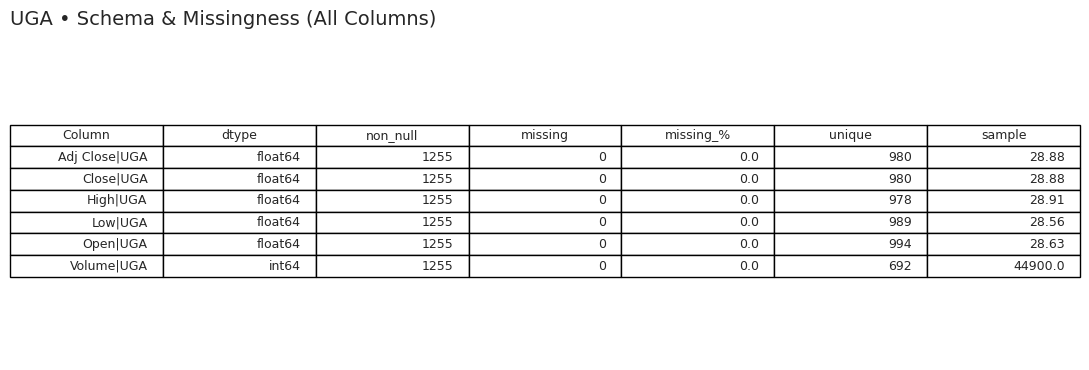

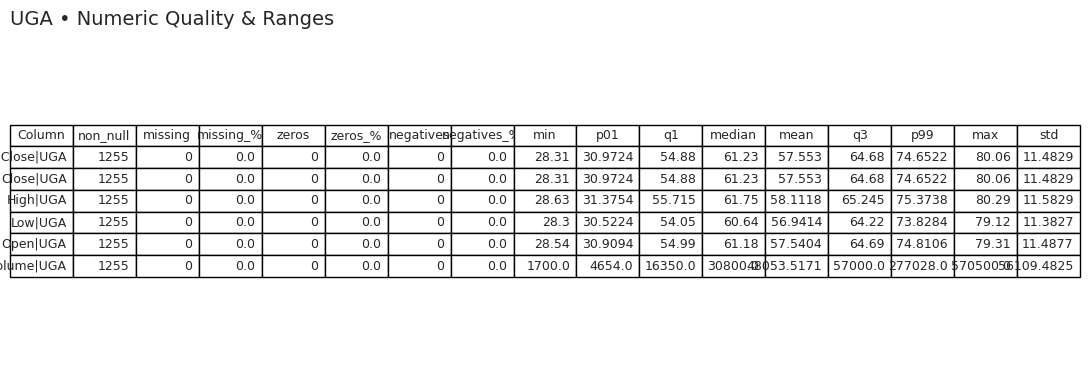

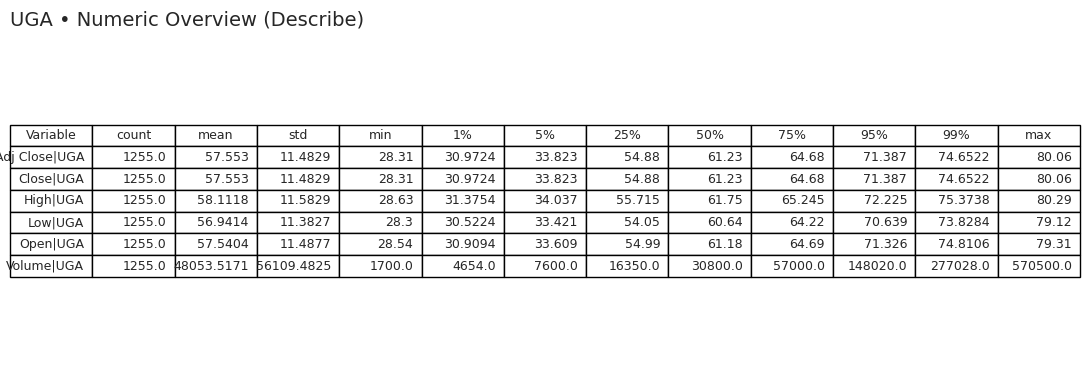

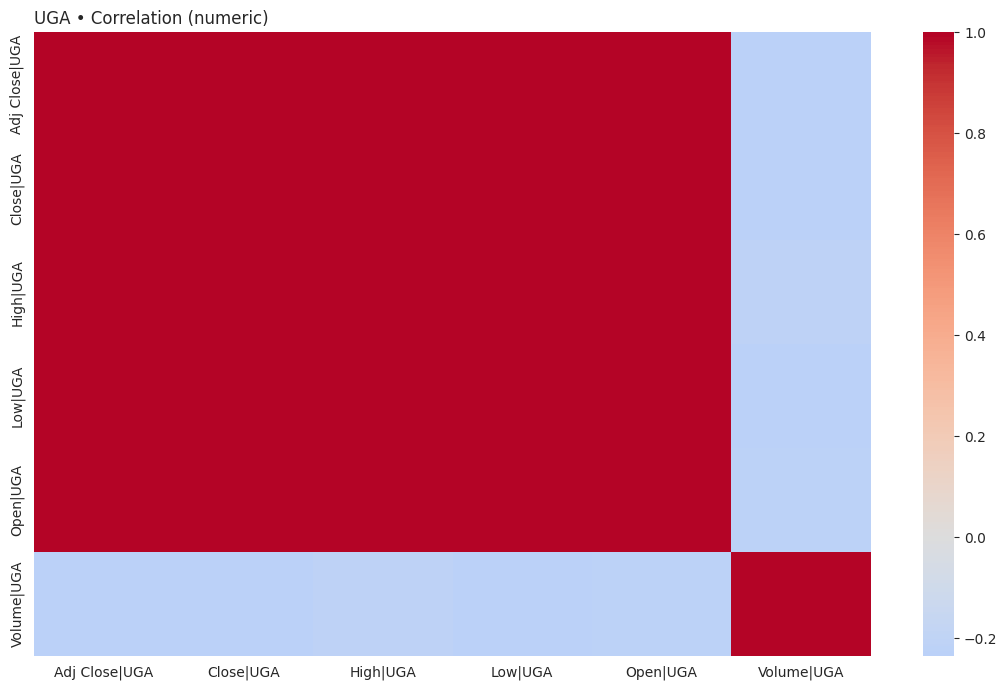

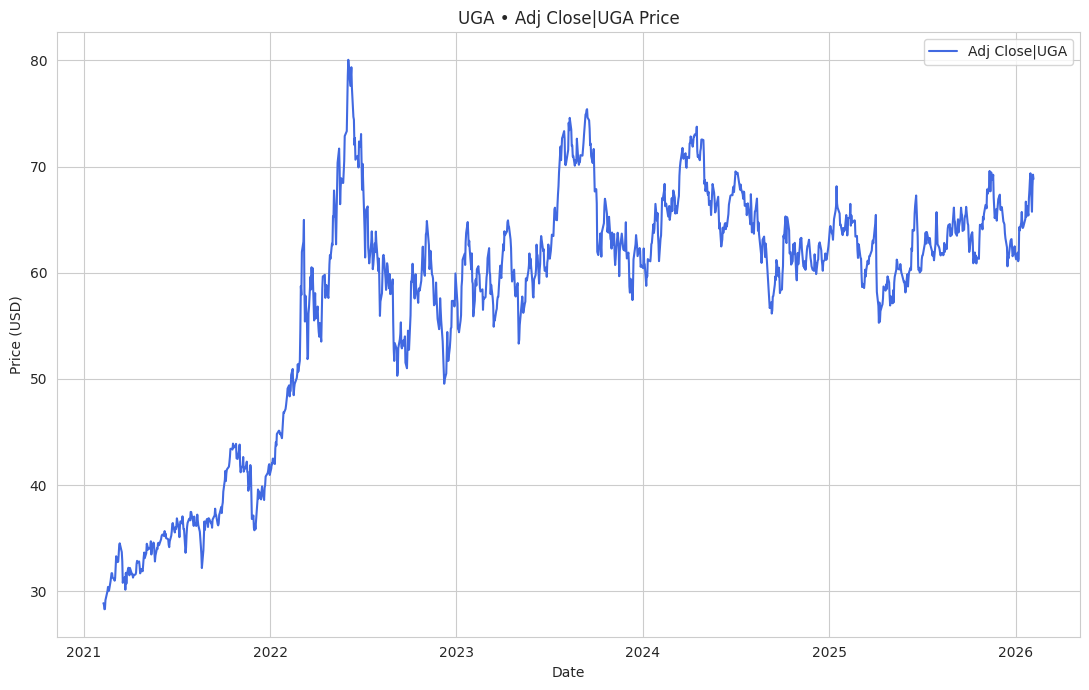

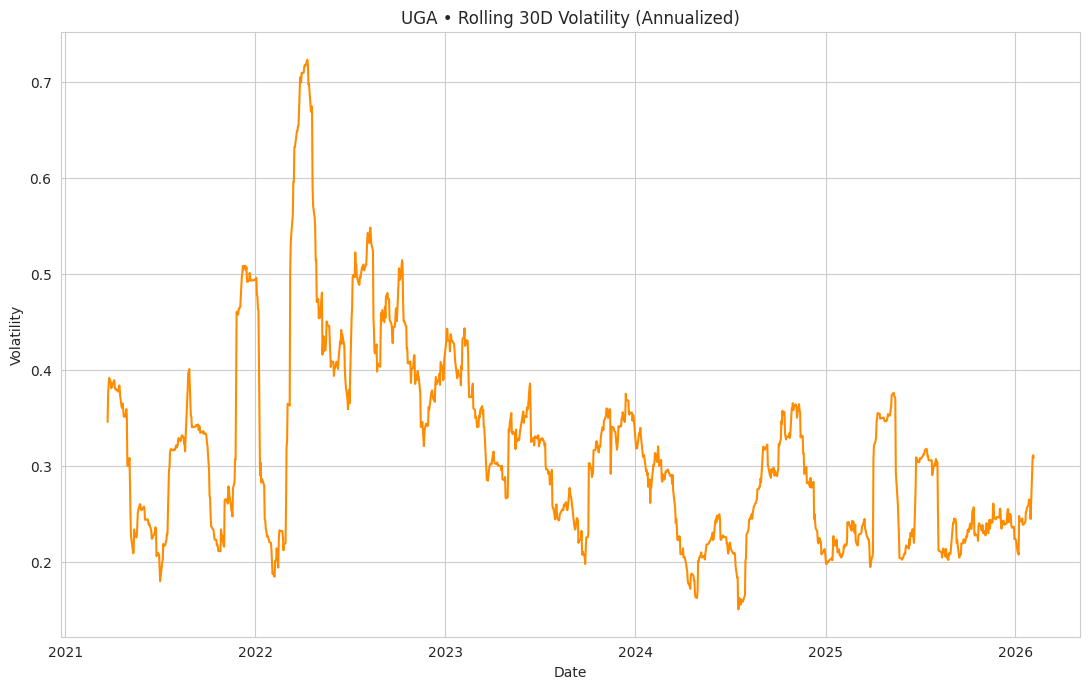

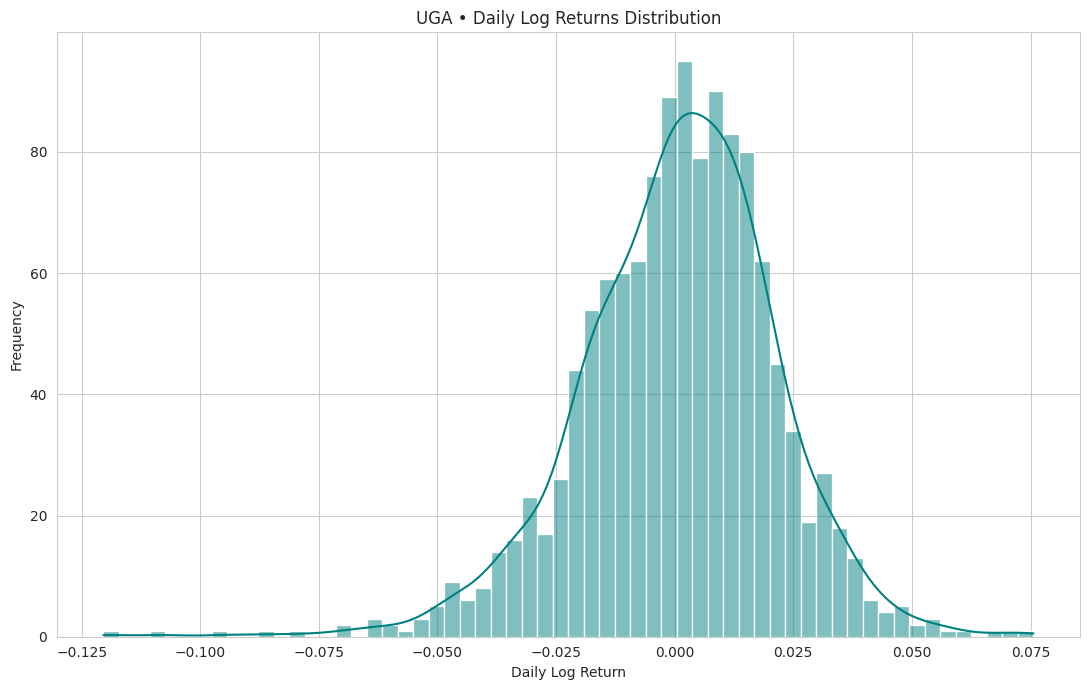

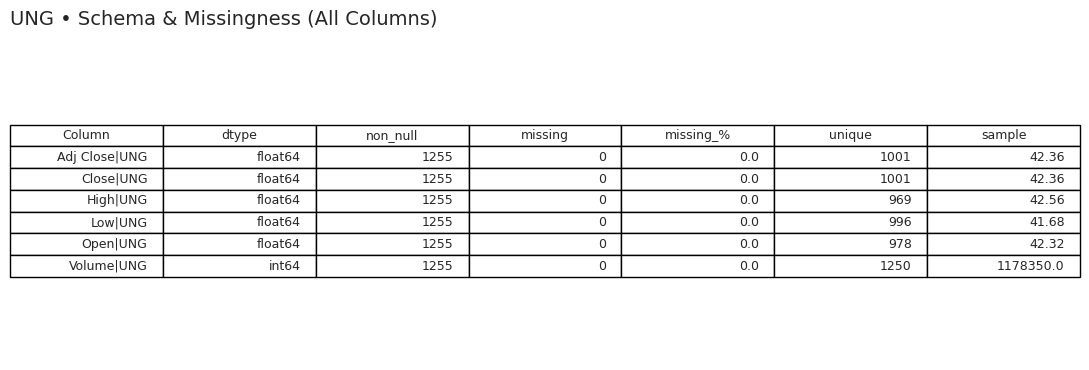

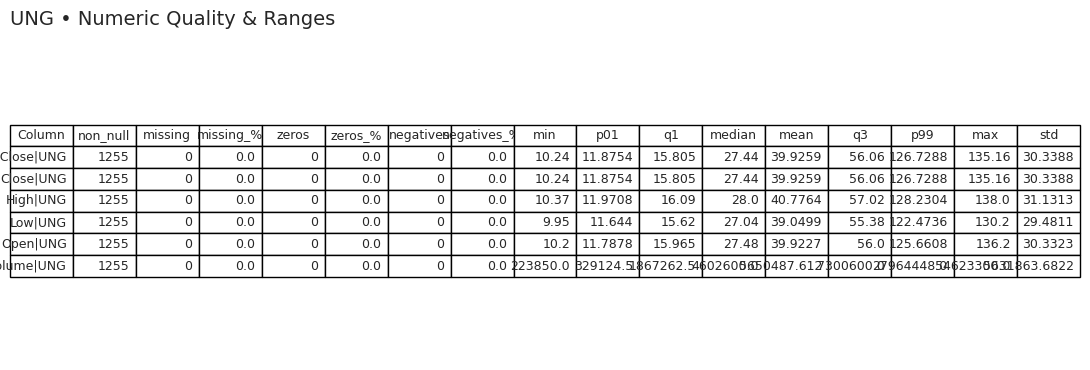

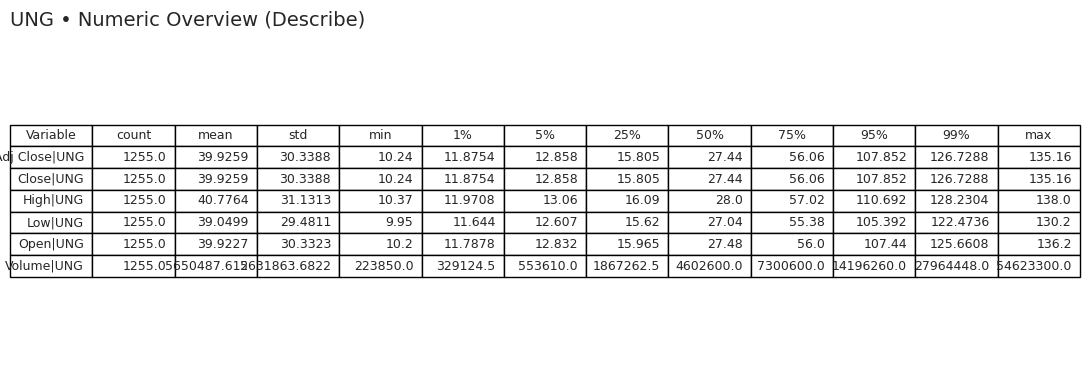

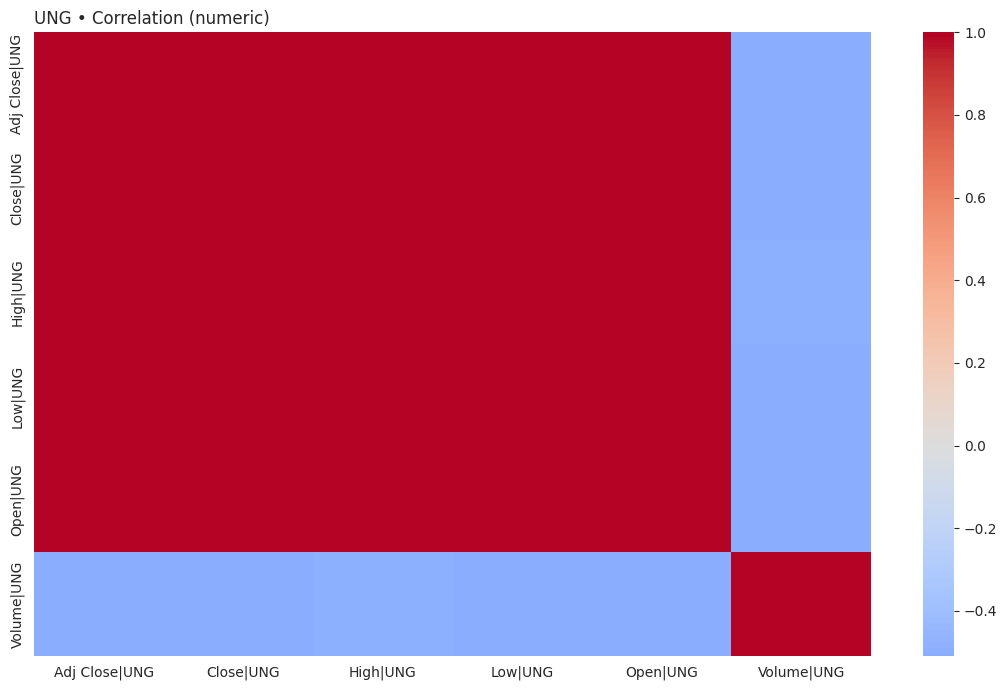

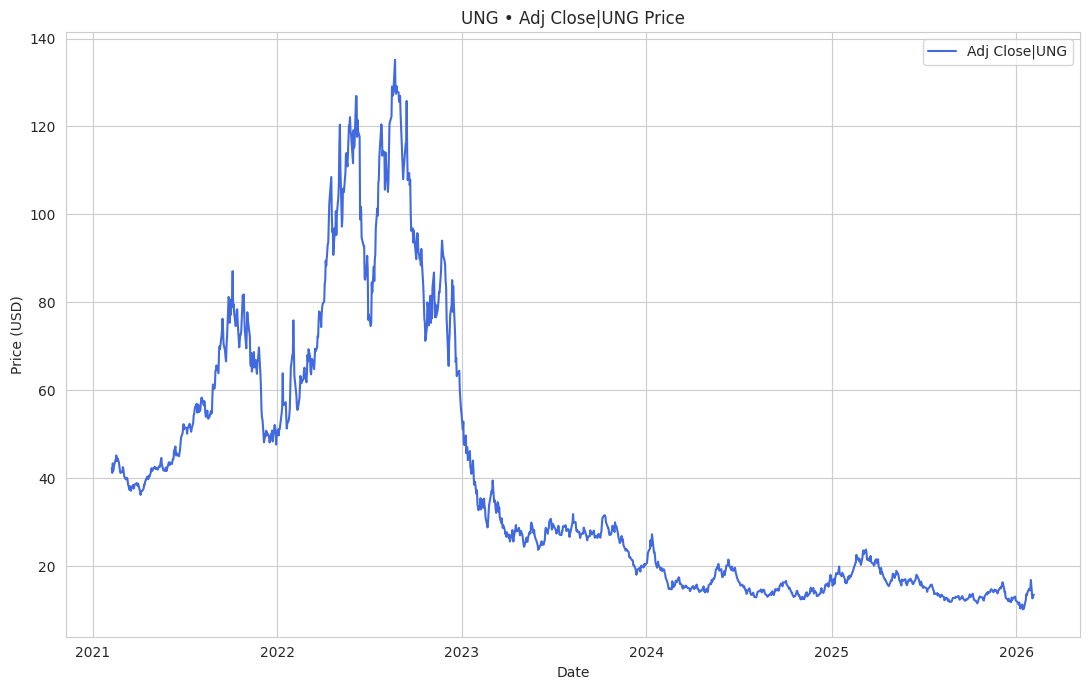

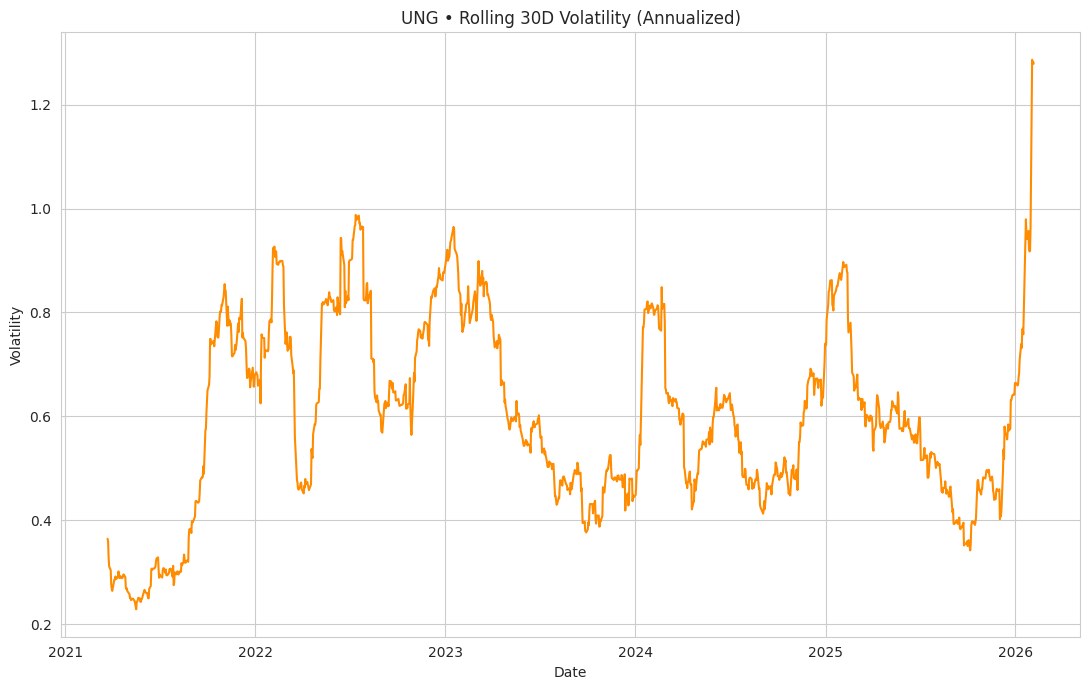

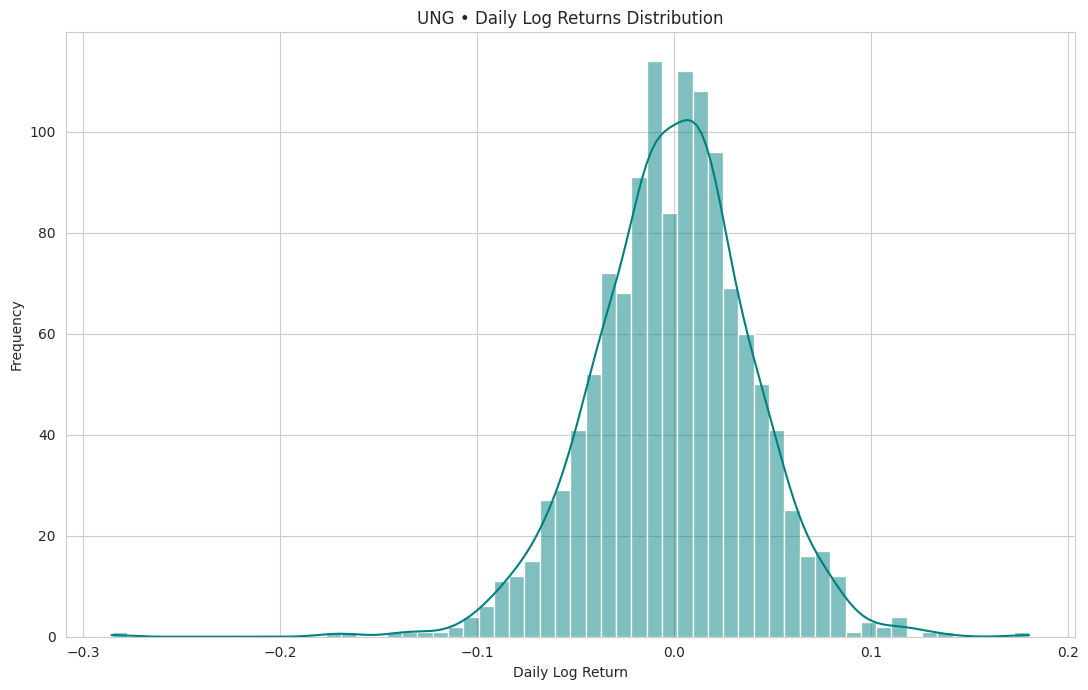

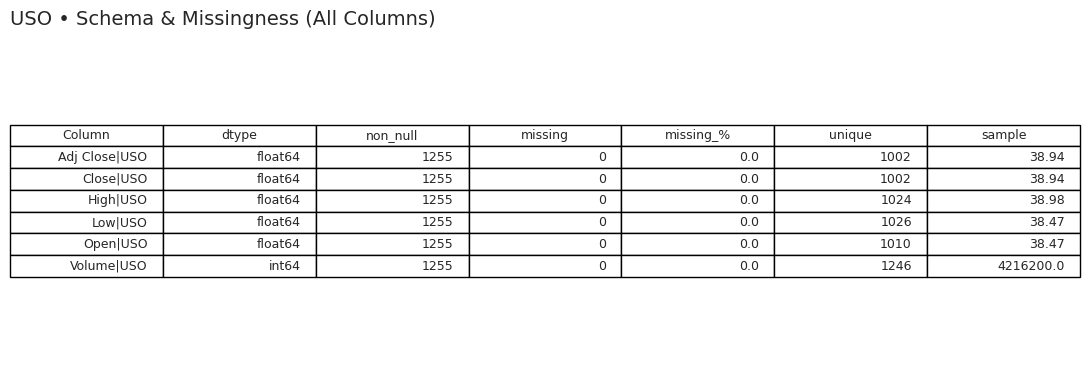

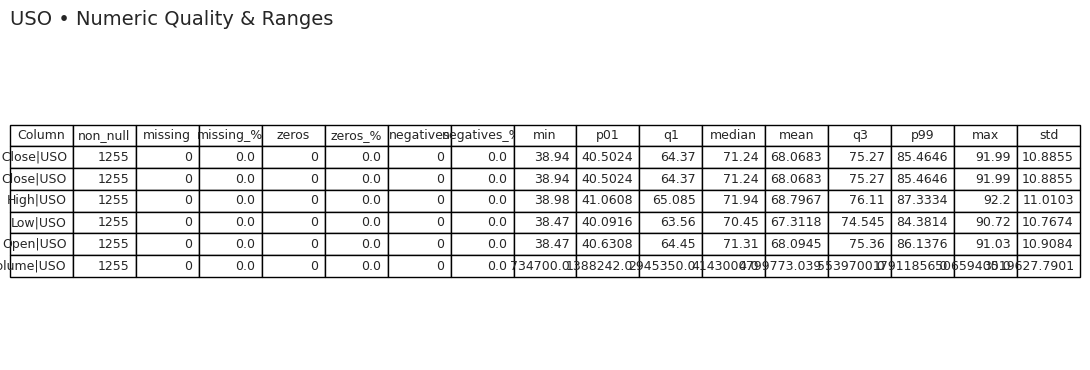

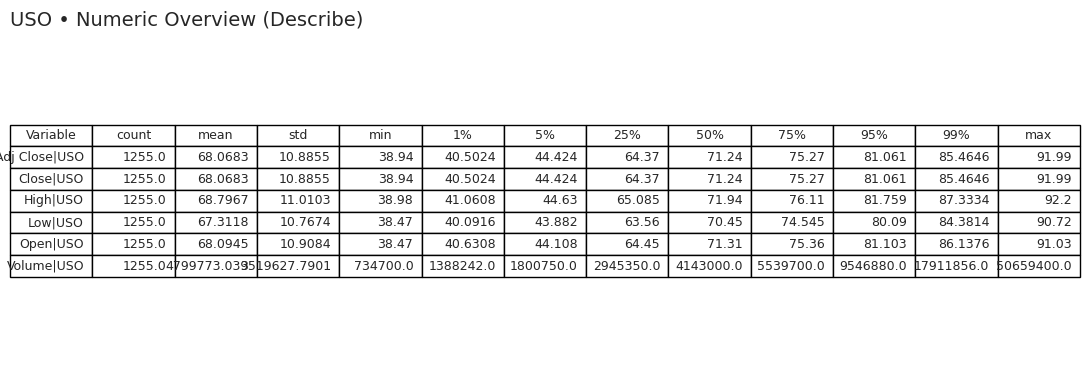

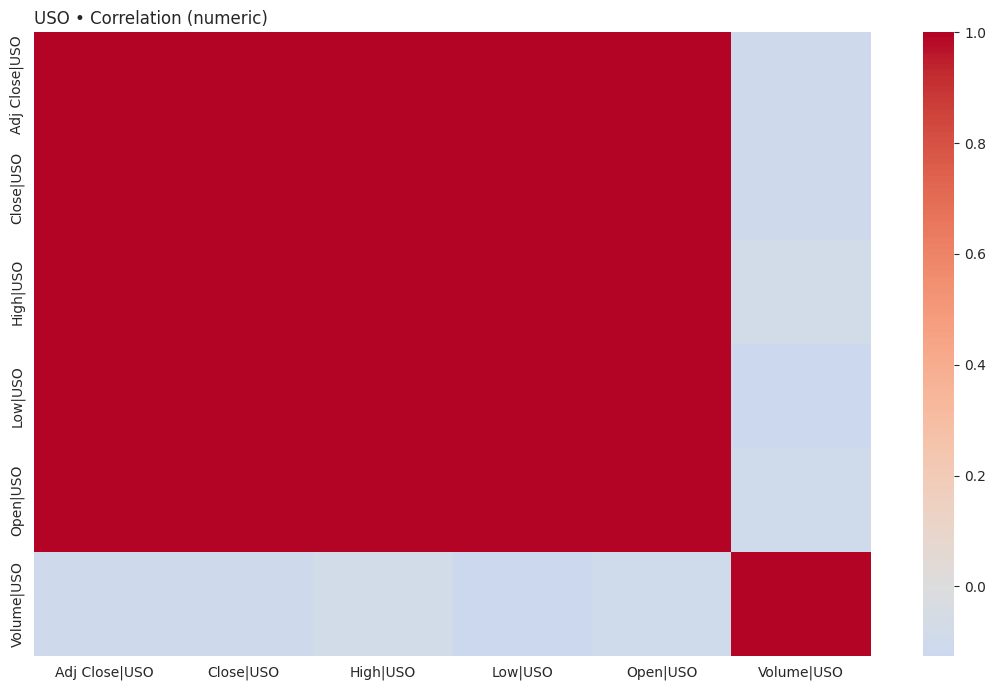

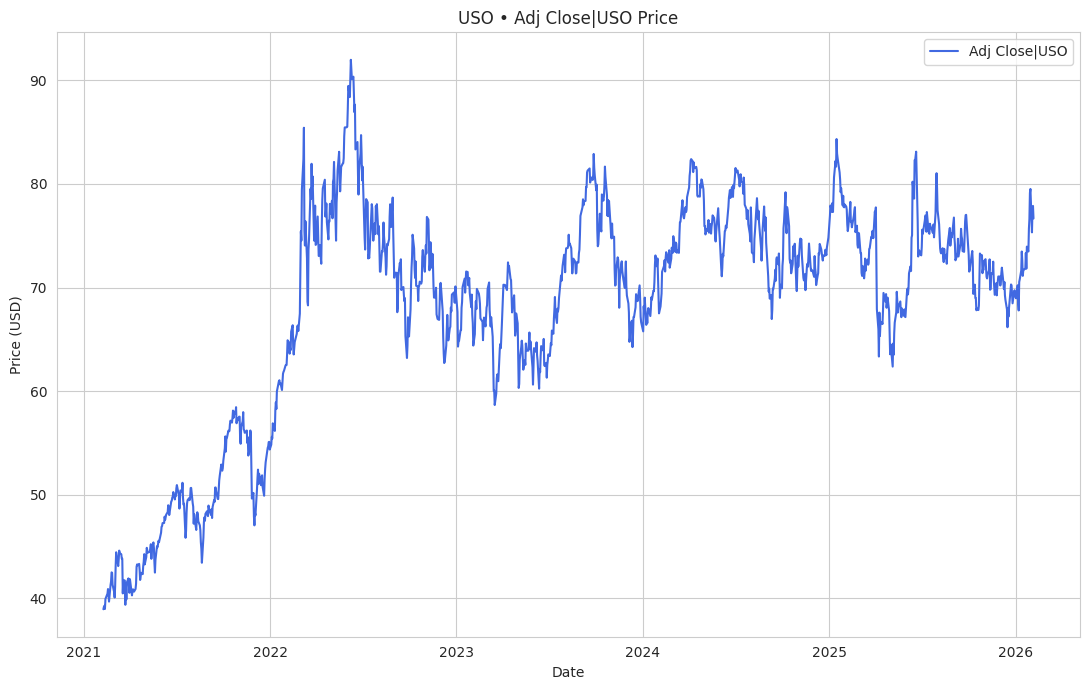

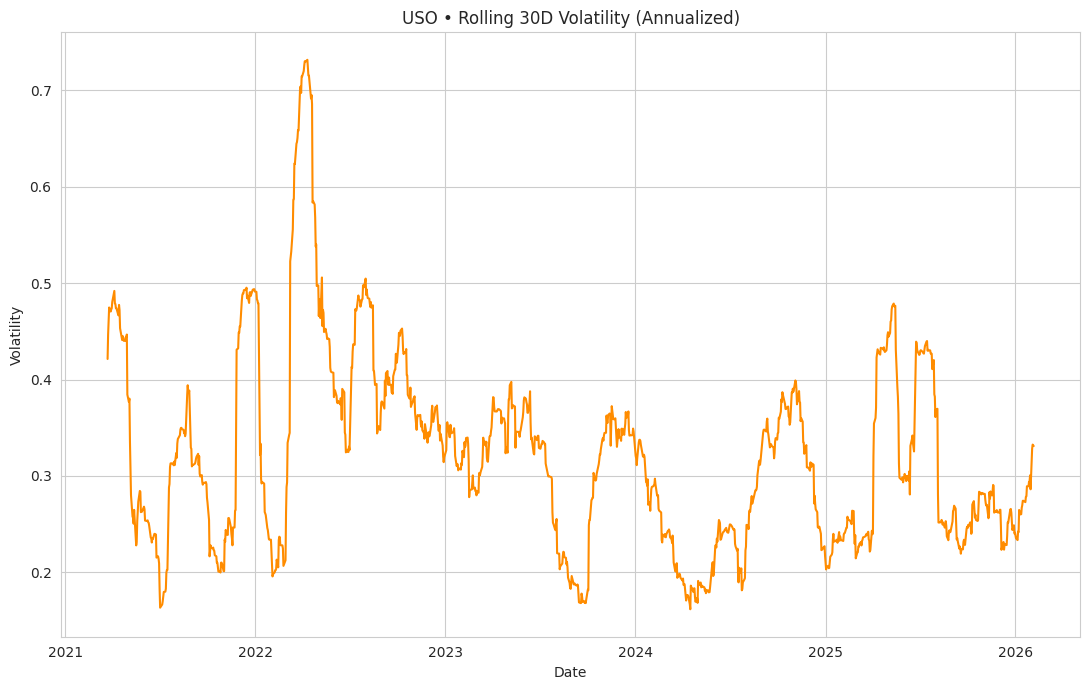

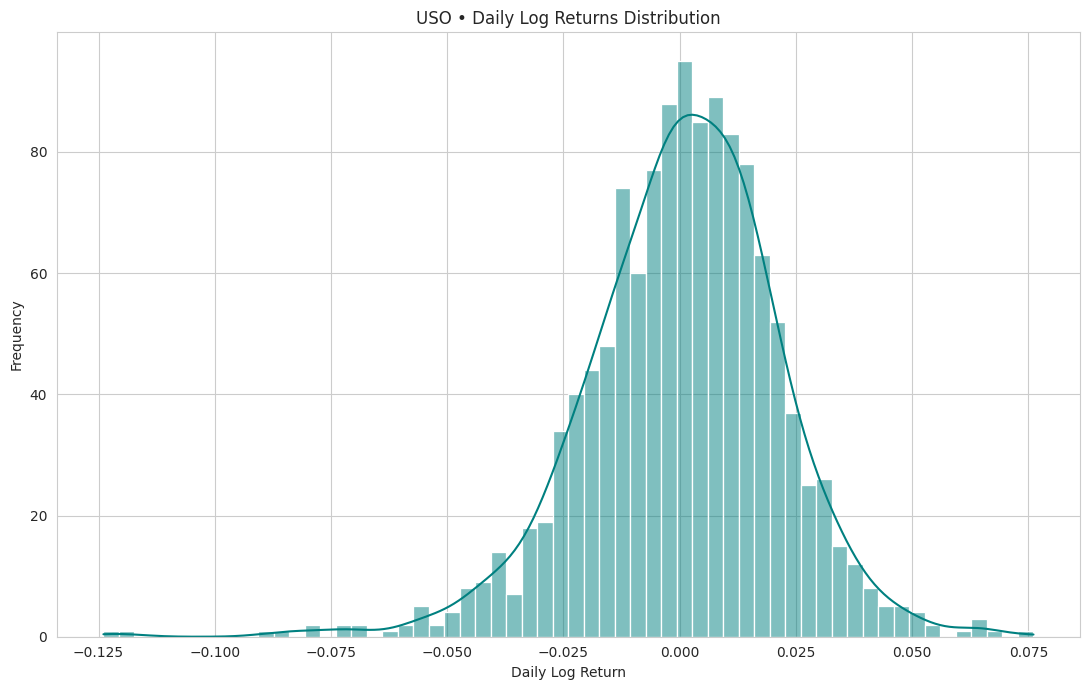

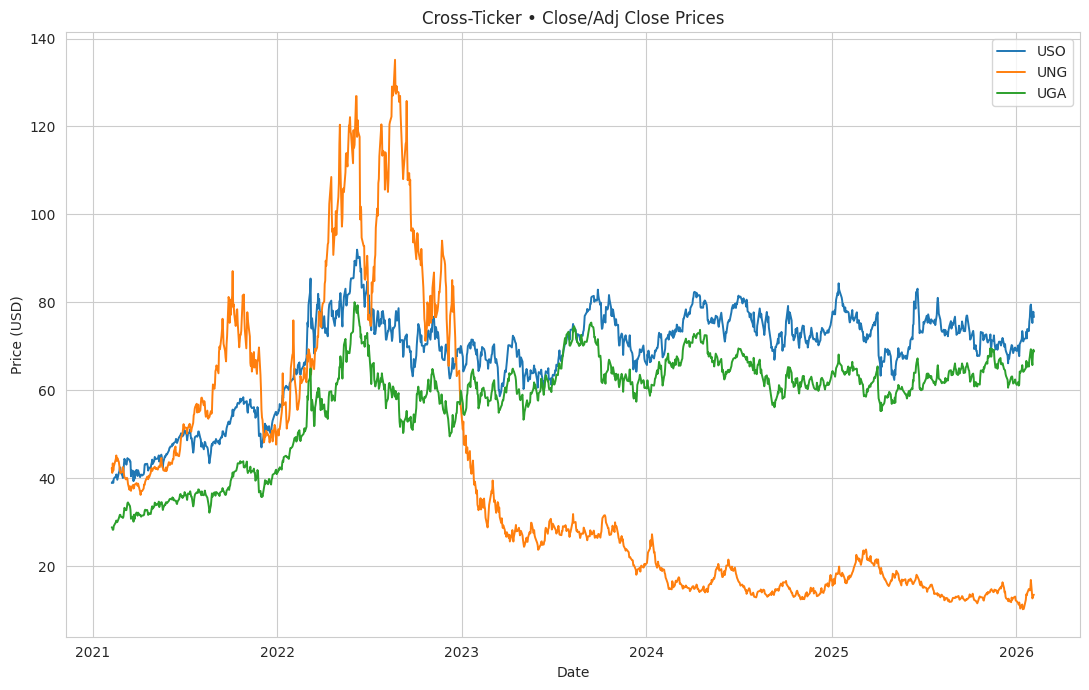

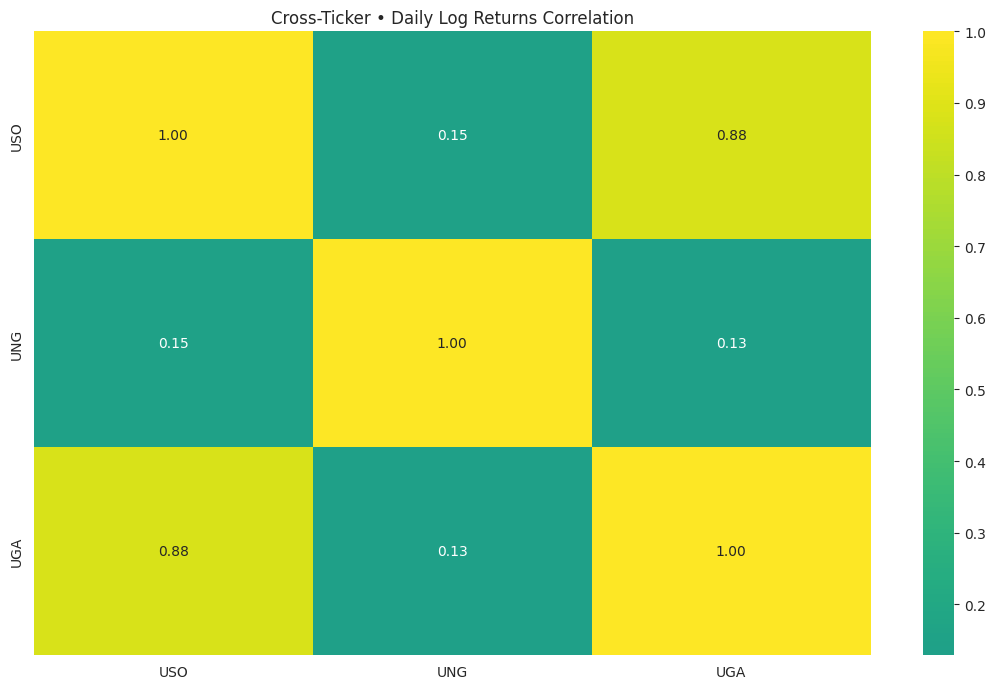

In [3]:
# -*- coding: utf-8 -*-
"""
EDA for energy ETFs (USO, UNG, UGA) using the 'ETF data.xlsx' file produced earlier.

What this script does
---------------------
1) Loads the ETF sheets from 'ETF data.xlsx' via your custom reader.
2) Performs EDA per ticker:
   - Schema & Missingness
   - Numeric Quality & Ranges
   - Numeric Overview (describe)
   - Correlation heatmap (numeric)
   - Close/Adj Close price trend
   - Rolling 30D annualized volatility
   - Daily log-returns distribution
3) Performs cross-ticker EDA:
   - Overlaid prices
   - Daily log-returns correlation heatmap
4) Saves all figures to 'EDA energy ETF report.pdf'

Notes
-----
- Expects the ETF sheets to have two header rows (as written by your download script).
"""

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from typing import Dict, List, Tuple, Optional, Any

# ----------------------------
# Load your ETF data
# ----------------------------
# If your reader is in another file, e.g., `reader_etf.py`, import it as:
# from reader_etf import read_etf_prices_xlsx
#
# For convenience here, we inline a minimal version that matches your earlier reader.
def _concat_two_levels_to_str(level0: Optional[object], level1: Optional[object], sep: str) -> str:
    parts = []
    for v in (level0, level1):
        if v is None:
            continue
        s = str(v).strip()
        if s != "" and s.lower() != "nan":
            parts.append(s)
    return sep.join(parts) if parts else ""

def read_etf_prices_xlsx(
    path: str,
    parse_dates: bool = True,
    sep: str = "|",
    numeric_cleanup: bool = True
) -> Dict[str, pd.DataFrame]:
    raw_sheets = pd.read_excel(path, sheet_name=None, header=None, engine="openpyxl")
    out: Dict[str, pd.DataFrame] = {}

    for sheet_name, df_raw in raw_sheets.items():
        # Need at least: 2 header rows + 1 ignored row + >=1 data row
        if df_raw.shape[0] < 4:
            continue

        header_row_0 = df_raw.iloc[0].tolist()
        header_row_1 = df_raw.iloc[1].tolist()

        flat_cols = [
            _concat_two_levels_to_str(h0, h1, sep=sep)
            for h0, h1 in zip(header_row_0, header_row_1)
        ]

        data = df_raw.iloc[3:].copy()
        data.columns = flat_cols

        first_col_name = data.columns[0]
        date_series = data[first_col_name]

        if parse_dates:
            date_series = pd.to_datetime(date_series, errors="coerce")

        data.index = date_series
        data.index.name = "Date"
        data = data.drop(columns=[first_col_name])

        data = data.dropna(axis=1, how="all")
        if parse_dates:
            data = data[~data.index.isna()]

        if len(data.columns) != len(set(data.columns)):
            seen = {}
            newcols = []
            for c in data.columns:
                if c not in seen:
                    seen[c] = 1
                    newcols.append(c)
                else:
                    seen[c] += 1
                    newcols.append(f"{c}{sep}{seen[c]}")
            data.columns = newcols

        if numeric_cleanup:
            data = data.apply(lambda col: col.astype(str).str.strip())
            data = data.replace({"": None, "nan": None, "NaN": None})
            data = data.apply(lambda col: col.str.replace(",", "", regex=False) if col.dtype == "object" else col)
            data = data.apply(lambda col: col.str.replace("%", "", regex=False) if col.dtype == "object" else col)

        data = data.apply(pd.to_numeric, errors="coerce")
        out[sheet_name] = data

    return out


# ----------------------------
# Plot styling
# ----------------------------
plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")


# ----------------------------
# Helpers
# ----------------------------
def _select_numeric_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Return only numeric columns."""
    return df.select_dtypes(include=[np.number]).copy()

def _infer_close_col(df: pd.DataFrame) -> Optional[str]:
    """
    Find a primary 'Close-like' column among flattened headers.
    Priority: 'Adj Close' then exact 'Close', then any column containing 'close'.
    """
    cols_lower = {str(c).lower(): c for c in df.columns}
    candidates = [
        next((cols_lower[k] for k in cols_lower if "adj close" in k), None),
        next((cols_lower[k] for k in cols_lower if k == "close"), None),
        next((cols_lower[k] for k in cols_lower if "close" in k), None),
    ]
    return next((c for c in candidates if c is not None), None)

def _daily_returns(series: pd.Series) -> pd.Series:
    """Compute daily log returns for a price series (no forward-fill to avoid bias)."""
    return np.log(series).diff()

def _safe_title(name: str) -> str:
    return str(name).strip() if name else "Unknown"

def _inject_index_as_column(df: pd.DataFrame, name: str = "Variable") -> pd.DataFrame:
    idx_name = df.index.name if df.index.name not in [None, ""] else name
    out = df.reset_index()
    if out.columns[0] != idx_name:
        out = out.rename(columns={out.columns[0]: idx_name})
    return out

def _table_figure_from_dataframe(
    df: pd.DataFrame, title: str, font_size: int = 9
) -> plt.Figure:
    fig_height = min(7, 1 + 0.35 * (len(df) + 2))
    fig, ax = plt.subplots(figsize=(11, fig_height))
    ax.axis("off")
    ax.set_title(title, fontsize=14, pad=12, loc="left")

    display_df = df.copy()
    tbl = ax.table(
        cellText=display_df.round(4).values.tolist(),
        colLabels=[str(c) for c in display_df.columns],
        loc="center",
        cellLoc="right",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1, 1.2)
    return fig

def _corr_heatmap(df: pd.DataFrame, title: str) -> plt.Figure:
    num = _select_numeric_cols(df)
    if num.empty:
        info_df = pd.DataFrame({"Message": ["No numeric columns found for correlation."]})
        info_df = _inject_index_as_column(info_df, "Info")
        return _table_figure_from_dataframe(info_df, f"{title} • Not Available")
    corr = num.corr()
    fig, ax = plt.subplots()
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, ax=ax)
    ax.set_title(title, loc="left")
    return fig

def _rolling_volatility(series: pd.Series, window: int = 30) -> pd.Series:
    rets = _daily_returns(series).dropna()
    return rets.rolling(window).std() * math.sqrt(252)


# ----------------------------
# Numeric EDA Checks
# ----------------------------
def _schema_and_missing_table(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    rows: List[Dict[str, Any]] = []
    for col in df.columns:
        s = df[col]
        non_null = int(s.notna().sum())
        missing = int(s.isna().sum())
        missing_pct = (missing / n * 100.0) if n > 0 else 0.0
        try:
            unique = int(s.nunique(dropna=True))
        except Exception:
            unique = np.nan
        sample = None
        if non_null > 0:
            try:
                sample = s.dropna().iloc[0]
            except Exception:
                sample = None
        rows.append(
            {
                "Column": str(col),
                "dtype": str(s.dtype),
                "non_null": non_null,
                "missing": missing,
                "missing_%": round(missing_pct, 2),
                "unique": unique,
                "sample": sample,
            }
        )
    out = pd.DataFrame(rows).set_index("Column")
    return out

def _numeric_quality_and_ranges(df: pd.DataFrame) -> pd.DataFrame:
    num = _select_numeric_cols(df)
    if num.empty:
        return pd.DataFrame({"Message": ["No numeric columns found."]})

    num = num.replace([np.inf, -np.inf], np.nan)
    n = len(num)
    rows: List[Dict[str, Any]] = []

    for col in num.columns:
        s = num[col]
        non_null = int(s.notna().sum())
        missing = int(s.isna().sum())
        zeros = int((s == 0).sum(skipna=True)) if non_null > 0 else 0
        negatives = int((s < 0).sum(skipna=True)) if non_null > 0 else 0

        if non_null > 0:
            _min = s.min()
            p01 = s.quantile(0.01)
            q1 = s.quantile(0.25)
            median = s.quantile(0.50)
            mean = s.mean()
            q3 = s.quantile(0.75)
            p99 = s.quantile(0.99)
            _max = s.max()
            std = s.std(ddof=1)
        else:
            _min = p01 = q1 = median = mean = q3 = p99 = _max = std = np.nan

        rows.append(
            {
                "Column": str(col),
                "non_null": non_null,
                "missing": missing,
                "missing_%": round((missing / n * 100.0) if n > 0 else 0.0, 2),
                "zeros": zeros,
                "zeros_%": round((zeros / n * 100.0) if n > 0 else 0.0, 2),
                "negatives": negatives,
                "negatives_%": round((negatives / n * 100.0) if n > 0 else 0.0, 2),
                "min": _min,
                "p01": p01,
                "q1": q1,
                "median": median,
                "mean": mean,
                "q3": q3,
                "p99": p99,
                "max": _max,
                "std": std,
            }
        )

    out = pd.DataFrame(rows).set_index("Column")
    return out


# ----------------------------
# EDA Core
# ----------------------------
def eda_single_ticker(name: str, df: pd.DataFrame) -> List[plt.Figure]:
    figs: List[plt.Figure] = []
    ticker = _safe_title(name)

    df = df.copy().sort_index()

    # Schema & Missingness
    schema_tbl = _schema_and_missing_table(df)
    schema_tbl = _inject_index_as_column(schema_tbl, "Variable")
    figs.append(_table_figure_from_dataframe(schema_tbl, f"{ticker} • Schema & Missingness (All Columns)"))

    # Numeric quality & ranges
    numeric_quality_tbl = _numeric_quality_and_ranges(df)
    numeric_quality_tbl = _inject_index_as_column(numeric_quality_tbl, "Variable")
    figs.append(_table_figure_from_dataframe(numeric_quality_tbl, f"{ticker} • Numeric Quality & Ranges"))

    # Numeric overview (describe)
    num = _select_numeric_cols(df)
    if not num.empty:
        overview = num.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
        overview = _inject_index_as_column(overview, "Variable")
        figs.append(_table_figure_from_dataframe(overview, f"{ticker} • Numeric Overview (Describe)"))
    else:
        info_df = pd.DataFrame({"Message": ["No numeric columns to describe."]})
        info_df = _inject_index_as_column(info_df, "Info")
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Describe"))

    # Correlation heatmap (numeric)
    figs.append(_corr_heatmap(num if not num.empty else df, f"{ticker} • Correlation (numeric)"))

    # Price plot & derived analytics
    close_col = _infer_close_col(df)
    if close_col is not None:
        price = df[close_col].astype(float)

        # Price over time
        fig, ax = plt.subplots()
        ax.plot(price.index, price.values, label=close_col, color="royalblue", lw=1.5)
        ax.set_title(f"{ticker} • {close_col} Price")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price (USD)")
        ax.legend(loc="best")
        figs.append(fig)

        # Rolling volatility (30-day)
        vol30 = _rolling_volatility(price, window=30)
        fig, ax = plt.subplots()
        ax.plot(vol30.index, vol30.values, color="darkorange", lw=1.5)
        ax.set_title(f"{ticker} • Rolling 30D Volatility (Annualized)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Volatility")
        figs.append(fig)

        # Return distribution
        rets = _daily_returns(price).dropna()
        fig, ax = plt.subplots()
        sns.histplot(rets, bins=60, kde=True, ax=ax, color="teal")
        ax.set_title(f"{ticker} • Daily Log Returns Distribution")
        ax.set_xlabel("Daily Log Return")
        ax.set_ylabel("Frequency")
        figs.append(fig)
    else:
        info_df = pd.DataFrame({
            "Message": [f"No 'Close' or 'Adj Close' column detected for {ticker}. Price plot, volatility, and returns are skipped."]
        })
        info_df = _inject_index_as_column(info_df, "Info")
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Price Columns Not Found"))

    return figs

def eda_cross_ticker(frames: Dict[str, pd.DataFrame]) -> List[plt.Figure]:
    figs: List[plt.Figure] = []

    # Collect Close/Adj Close series
    price_cols = {}
    for name, df in frames.items():
        col = _infer_close_col(df)
        if col is not None:
            price_cols[name] = df[col].astype(float)

    if price_cols:
        prices = pd.DataFrame(price_cols).sort_index()

        # Overlay prices
        fig, ax = plt.subplots()
        for name in prices.columns:
            ax.plot(prices.index, prices[name], lw=1.4, label=name)
        ax.set_title("Cross-Ticker • Close/Adj Close Prices")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price (USD)")
        ax.legend(loc="best")
        figs.append(fig)

        # Returns correlation
        rets = prices.apply(np.log).diff().dropna()
        corr = rets.corr()
        fig, ax = plt.subplots()
        sns.heatmap(corr, cmap="viridis", center=0, annot=True, fmt=".2f", ax=ax)
        ax.set_title("Cross-Ticker • Daily Log Returns Correlation")
        figs.append(fig)
    else:
        info_df = pd.DataFrame({"Message": ["No close-like columns found; cross-ticker analysis skipped."]})
        info_df = _inject_index_as_column(info_df, "Info")
        figs.append(_table_figure_from_dataframe(info_df, "Cross-Ticker • Price Columns Not Found"))

    return figs


# ----------------------------
# Report Orchestration
# ----------------------------
def build_energy_etf_report(
    frames: Dict[str, pd.DataFrame],
    pdf_title: str = "EDA energy ETF report.pdf",
    show_plots: bool = True,
) -> None:
    """
    Create a multi-page PDF report and (optionally) show plots.
    """
    ordered_items = sorted(frames.items(), key=lambda kv: kv[0])

    figs: List[plt.Figure] = []
    for name, df in ordered_items:
        figs.extend(eda_single_ticker(name, df))

    figs.extend(eda_cross_ticker(frames))

    # Save to PDF
    with PdfPages(pdf_title) as pdf:
        # Cover page
        cover_fig, ax = plt.subplots()
        ax.axis("off")
        ax.text(0.0, 0.9, "EDA Energy ETF Report", fontsize=22, fontweight="bold", ha="left", va="top")
        tickers_list = ", ".join(sorted(frames.keys()))
        ax.text(0.0, 0.78, f"Tickers: {tickers_list}", fontsize=12, ha="left", va="top")
        ax.text(0.0, 0.72, "Contents:", fontsize=14, fontweight="bold", ha="left", va="top")
        contents = [
            "• Schema & Missingness (all columns) per ticker",
            "• Numeric quality & ranges (numeric columns) per ticker",
            "• Numeric overview (describe) per ticker",
            "• Correlation heatmap (numeric columns) per ticker",
            "• Close/Adj Close price trend (if available)",
            "• Rolling 30-day annualized volatility (if available)",
            "• Daily log returns distribution (if available)",
            "• Cross-ticker price overlay",
            "• Cross-ticker daily return correlation heatmap",
        ]
        for i, line in enumerate(contents):
            ax.text(0.02, 0.66 - i * 0.05, line, fontsize=12, ha="left", va="top")
        pdf.savefig(cover_fig)
        plt.close(cover_fig)

        # Content pages
        for fig in figs:
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ PDF saved: {pdf_title}")

    # Optional on-screen display
    if show_plots:
        display_figs: List[plt.Figure] = []
        for name, df in ordered_items:
            display_figs.extend(eda_single_ticker(name, df))
        display_figs.extend(eda_cross_ticker(frames))
        for fig in display_figs:
            plt.show()


# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    # Path to your saved Excel file
    xlsx_path = "ETF data.xlsx"

    # Load ETF frames (USO, UNG, UGA) with flattened columns and datetime index
    frames = read_etf_prices_xlsx(xlsx_path, sep="|", numeric_cleanup=True, parse_dates=True)

    # (Optional) restrict to the three ETFs explicitly, if others exist:
    frames = {k: v for k, v in frames.items() if k in {"USO", "UNG", "UGA"}}

    if not frames:
        raise RuntimeError("No ETF sheets (USO, UNG, UGA) found in 'ETF data.xlsx'.")

    build_energy_etf_report(frames, pdf_title="EDA energy ETF report.pdf", show_plots=True)

## Engineered Features

In [4]:
import pandas as pd
import numpy as np

# ================================================================
# Feature Engineering for ETF Data (USO, UNG, UGA)
# ================================================================
def engineer_features_for_ticker(
    df: pd.DataFrame,
    ticker: str
) -> pd.DataFrame:
    """
    Adds engineered features for a given ETF ticker.

    Includes:
        - HL / OC spreads
        - SMA & EMA (5/10/20)
        - Lagged prices (1–3)
        - Daily log returns + lagged returns
        - Autocorrelation features
        - Seasonal features (month, day_of_week, quarter, etc.)
    """

    df = df.copy()

    # -----------------------------------
    # Seasonal Features
    # -----------------------------------
    df["month"]         = df.index.month
    df["day_of_week"]   = df.index.dayofweek
    df["quarter"]       = df.index.quarter
    df["year"]          = df.index.year
    df["is_month_end"]  = df.index.is_month_end.astype(int)
    df["is_month_start"] = df.index.is_month_start.astype(int)

    # -----------------------------------
    # Price column names
    # -----------------------------------
    adj_col   = f"Adj Close|{ticker}"
    close_col = f"Close|{ticker}"
    high_col  = f"High|{ticker}"
    low_col   = f"Low|{ticker}"
    open_col  = f"Open|{ticker}"

    price_col = adj_col if adj_col in df.columns else close_col

    price = pd.to_numeric(df.get(price_col), errors="coerce")
    close = pd.to_numeric(df.get(close_col, price), errors="coerce")

    # -----------------------------------
    # Spread Features
    # -----------------------------------
    df[f"HL_spread|{ticker}"] = (
        pd.to_numeric(df.get(high_col), errors="coerce") -
        pd.to_numeric(df.get(low_col), errors="coerce")
    )

    df[f"OC_spread|{ticker}"] = (
        pd.to_numeric(df.get(open_col), errors="coerce") -
        pd.to_numeric(df.get(close_col), errors="coerce")
    )

    # -----------------------------------
    # SMA / EMA Features
    # -----------------------------------
    for w in (5, 10, 20):
        df[f"SMA_{w}|{ticker}"] = price.rolling(w, min_periods=1).mean()
        df[f"EMA_{w}|{ticker}"] = price.ewm(span=w, adjust=False, min_periods=1).mean()

    # -----------------------------------
    # Lagged Prices
    # -----------------------------------
    for k in (1, 2, 3):
        df[f"lag_{k}|{ticker}"] = price.shift(k)

    # -----------------------------------
    # Price Autocorrelations
    # -----------------------------------
    for k in (1, 2, 3):
        df[f"autocorr_{k}|{ticker}"] = price.corr(price.shift(k))

    # -----------------------------------
    # Log Returns
    # -----------------------------------
    df[f"log_ret|{ticker}"] = np.log(price / price.shift(1))
    ret = df[f"log_ret|{ticker}"]

    # -----------------------------------
    # Lagged Returns and Return Autocorrelations
    # -----------------------------------
    for k in (1, 2, 3):
        df[f"lag_ret_{k}|{ticker}"] = ret.shift(k)
        df[f"autocorr_ret_{k}|{ticker}"] = ret.corr(ret.shift(k))

    return df


# ================================================================
# Apply feature engineering across tickers
# ================================================================
def engineer_features(frames: dict) -> dict:
    updated = {}
    for ticker, df in frames.items():
        updated[ticker] = engineer_features_for_ticker(df, ticker)
    return updated


# ================================================================
# Example usage
# ================================================================
if __name__ == "__main__":
    # frames = read_etf_prices_xlsx("ETF data.xlsx")
    # frames = {"USO": uso_df, "UNG": ung_df, "UGA": uga_df}

    engineered = engineer_features(frames)

    uso_df = engineered["USO"]
    ung_df = engineered["UNG"]
    uga_df = engineered["UGA"]


## EDA on Engineered Features

/tmp/ipykernel_6285/441747956.py:254: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


✅ PDF saved: Engineered Feature EDA.pdf


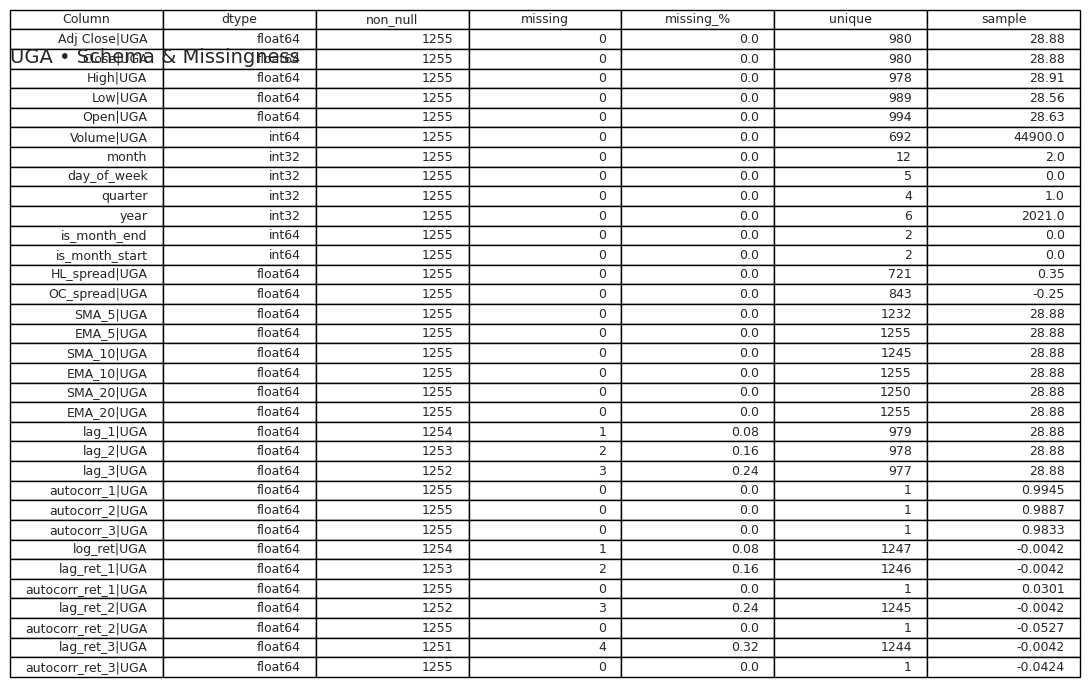

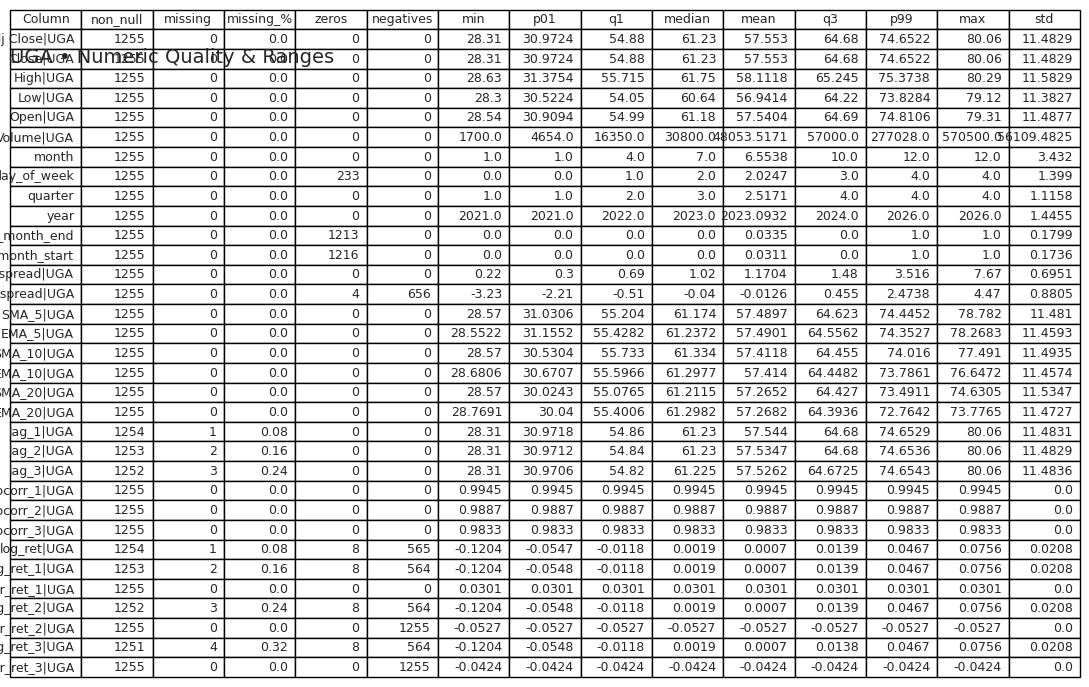

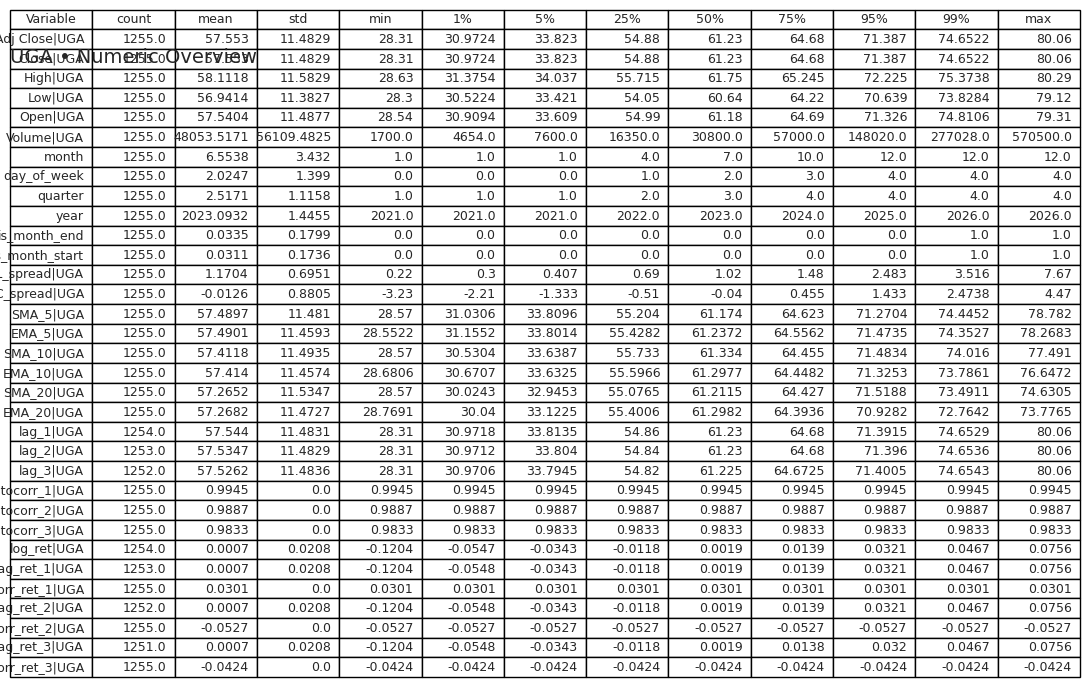

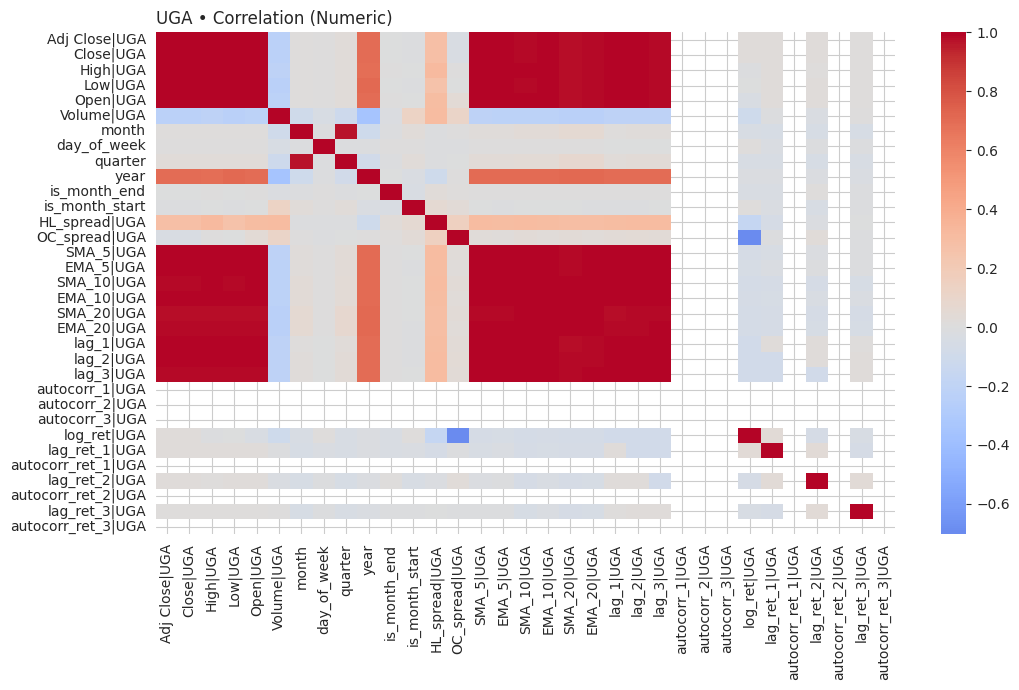

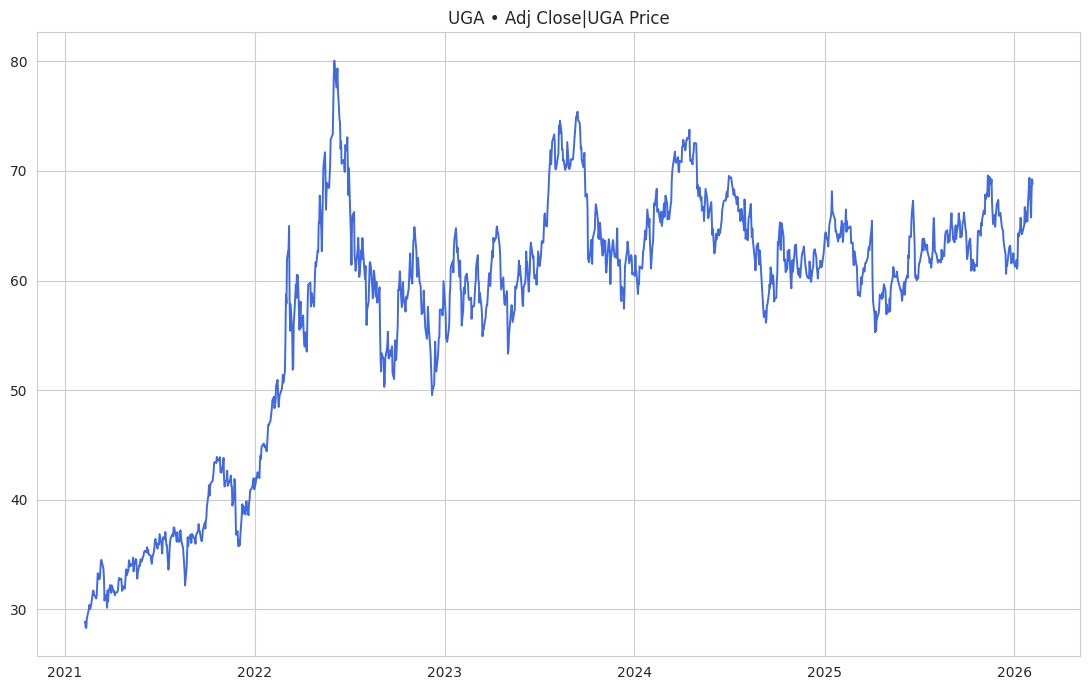

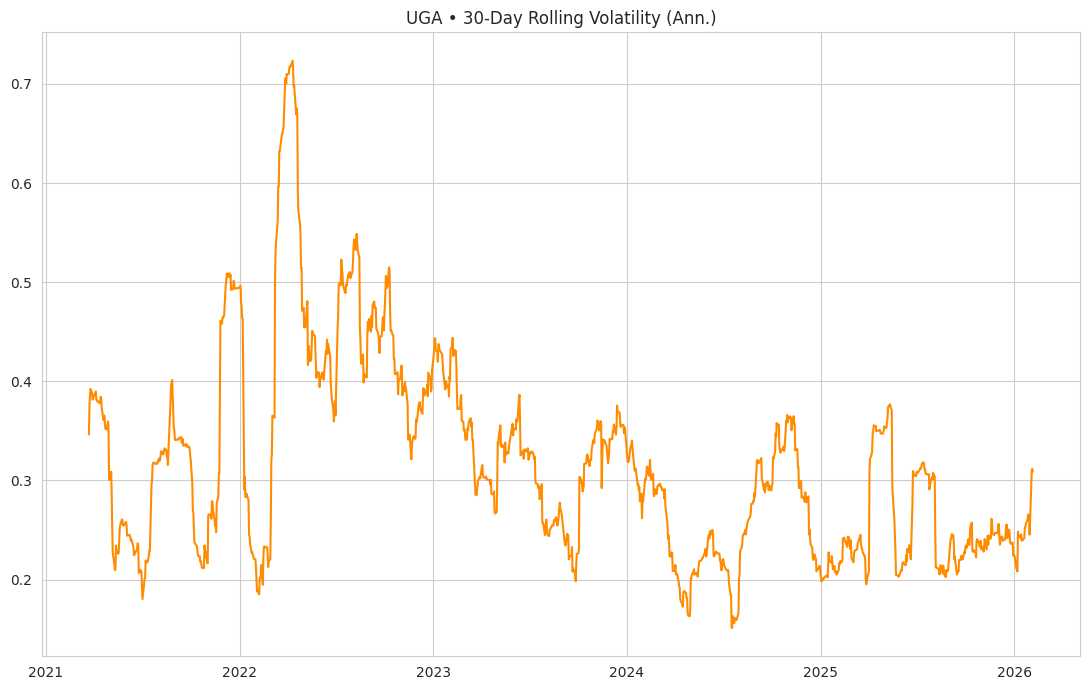

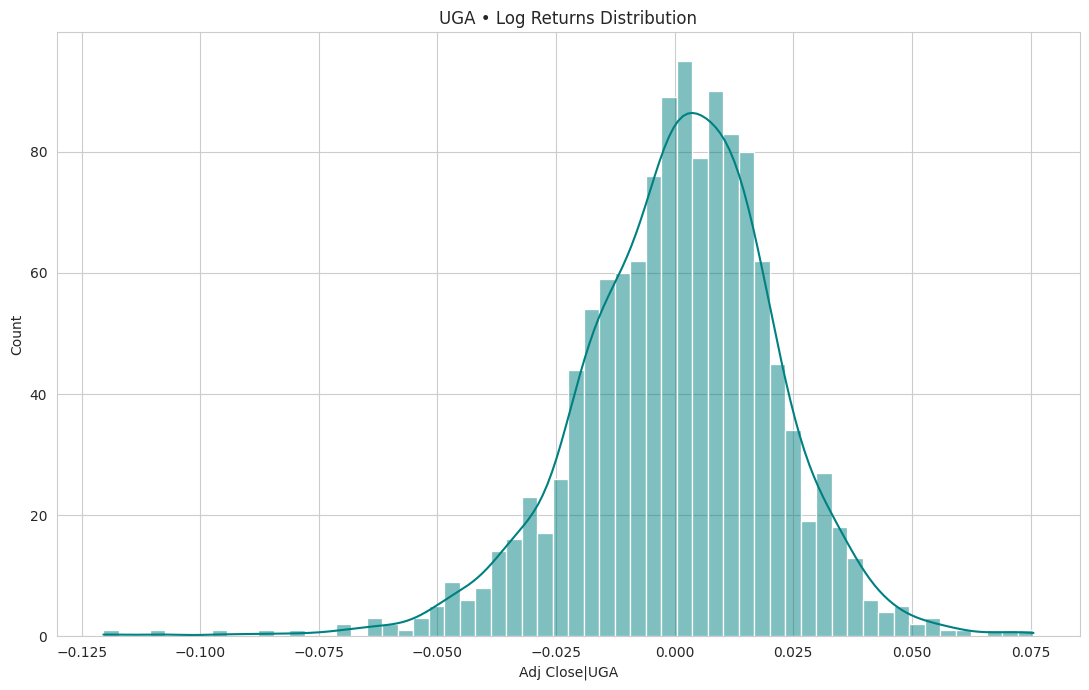

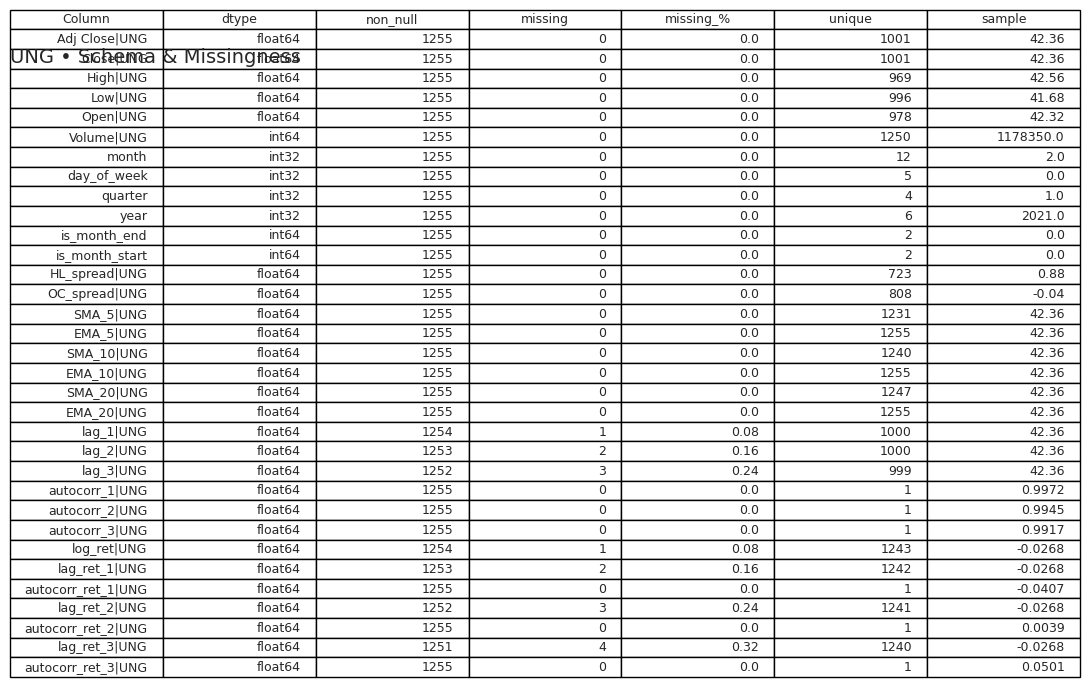

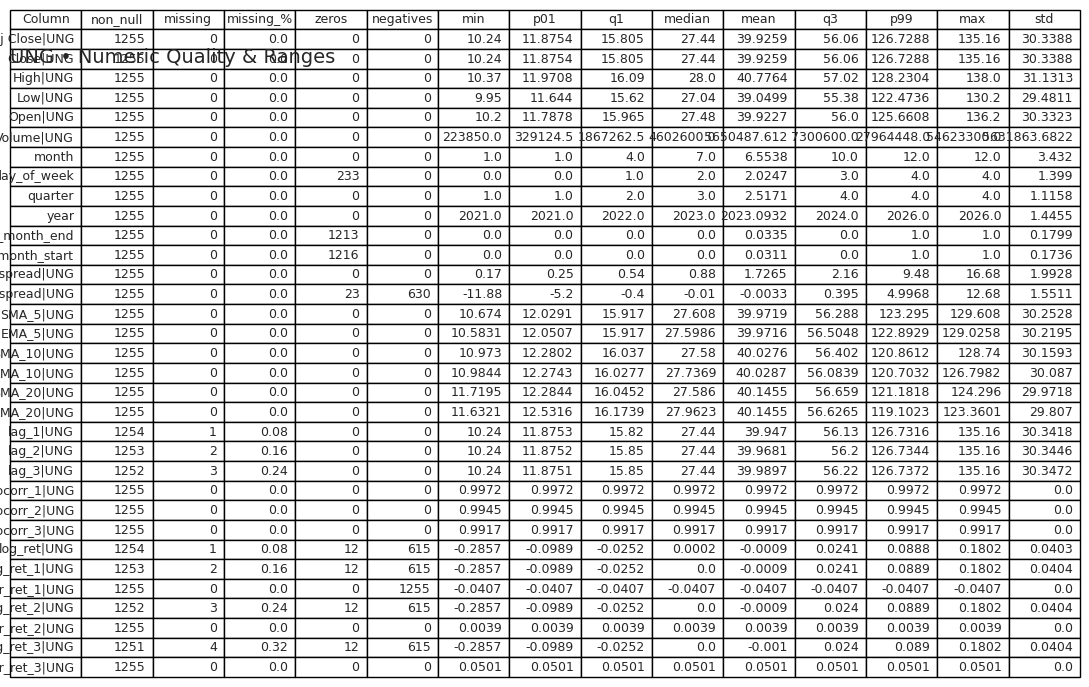

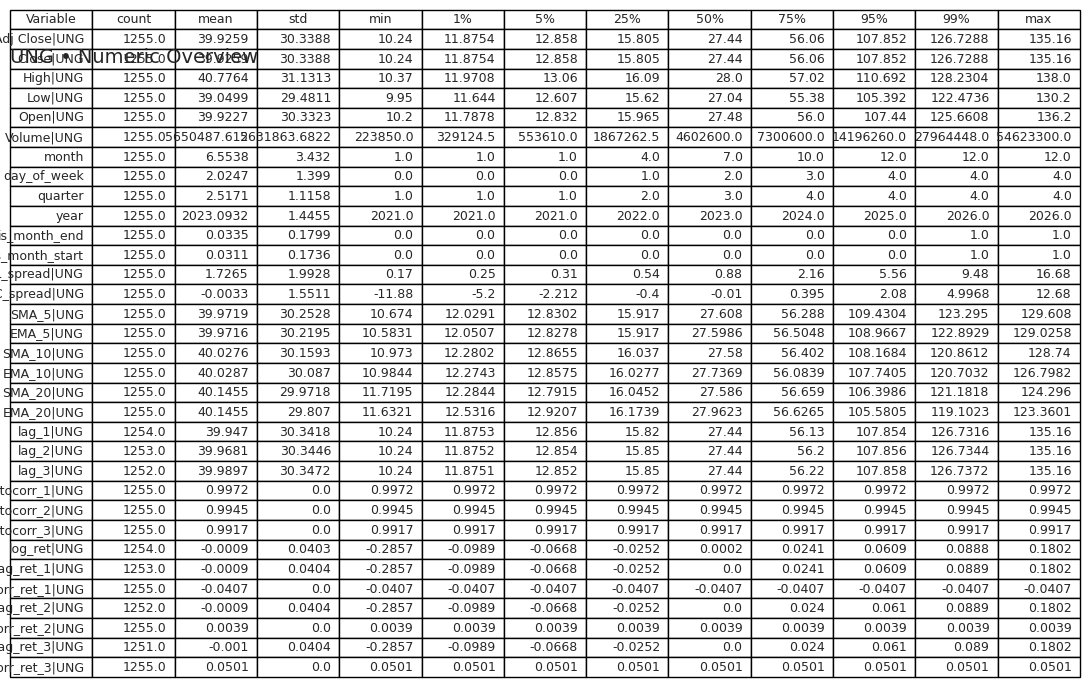

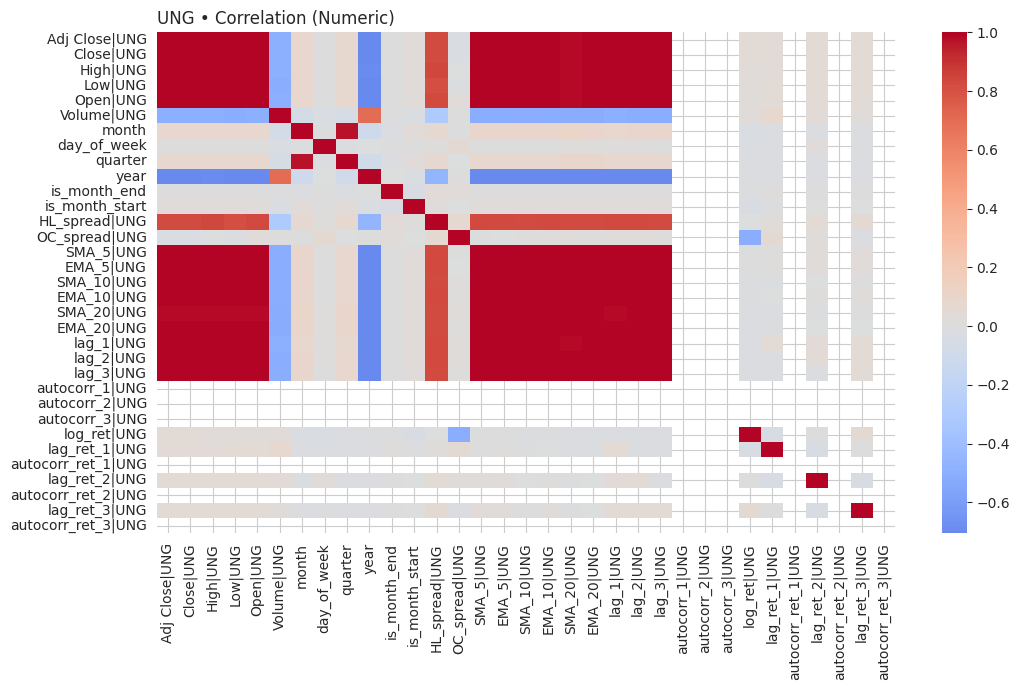

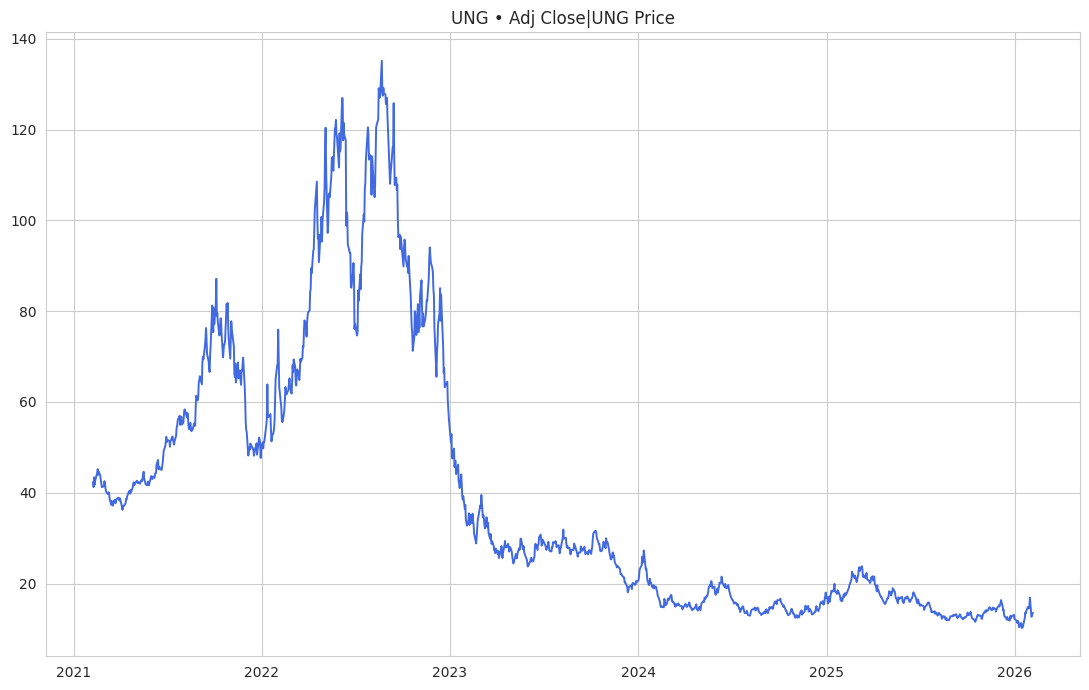

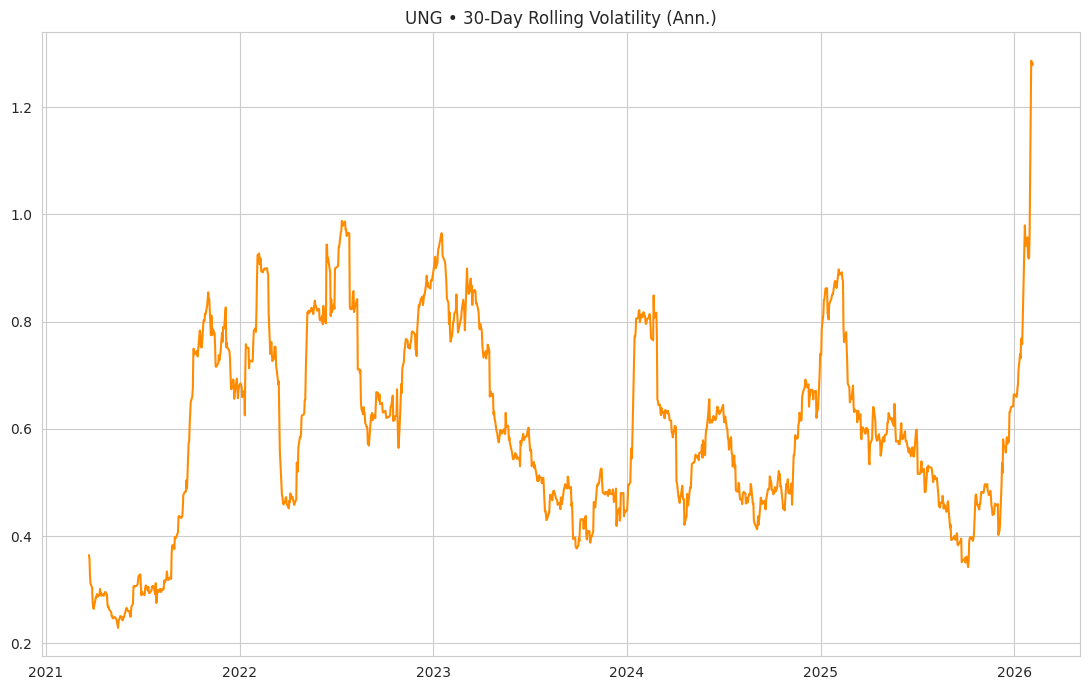

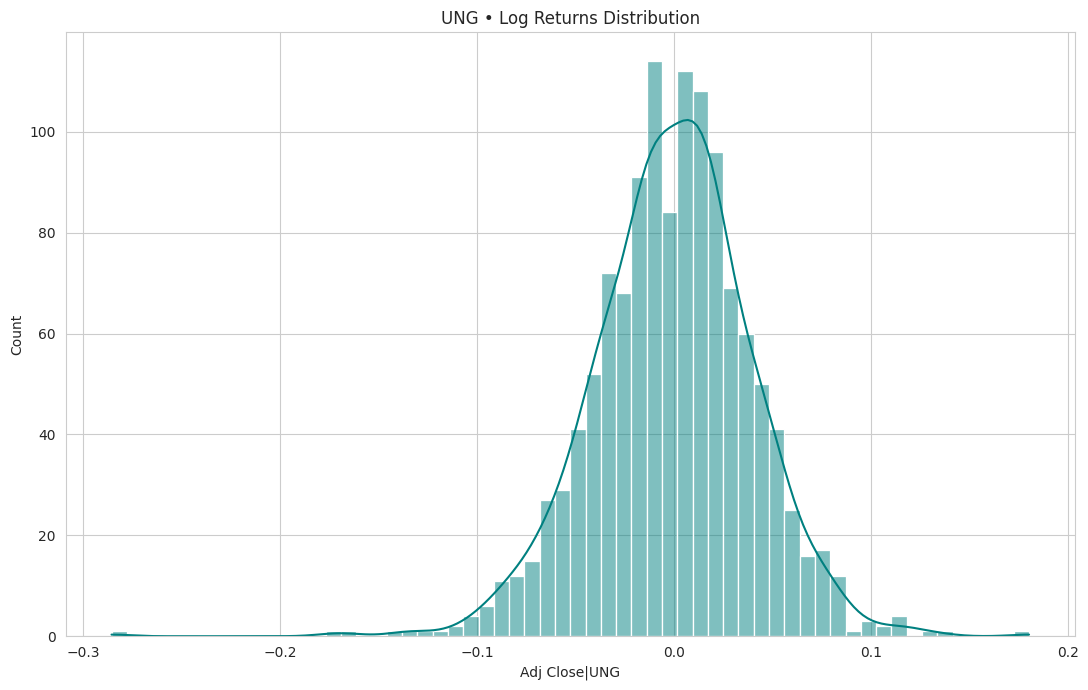

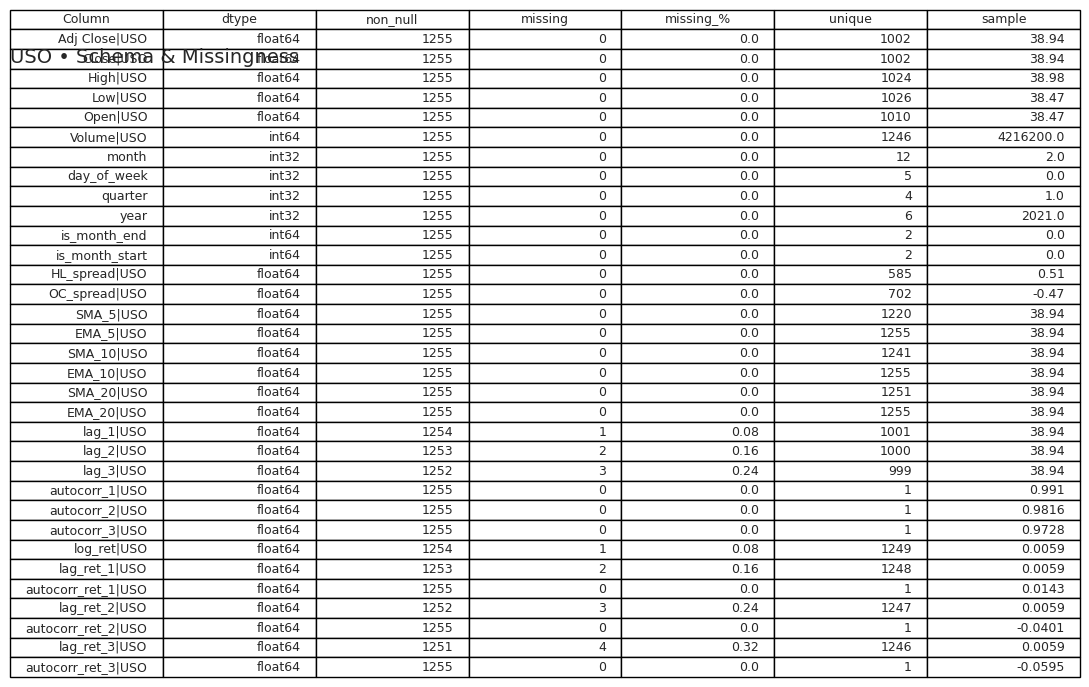

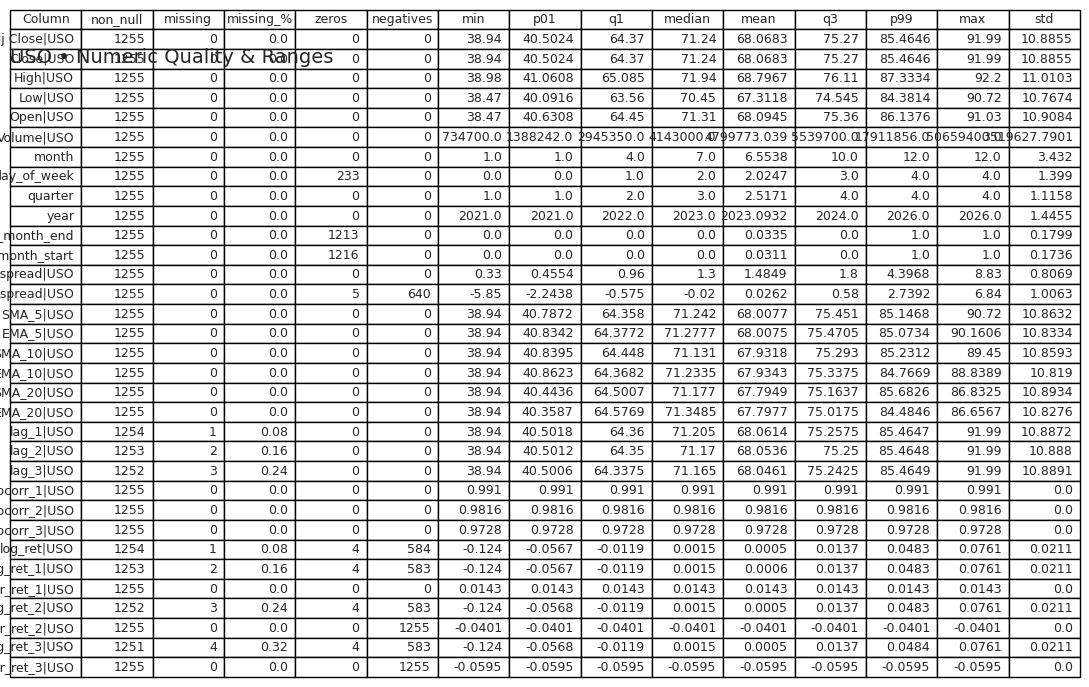

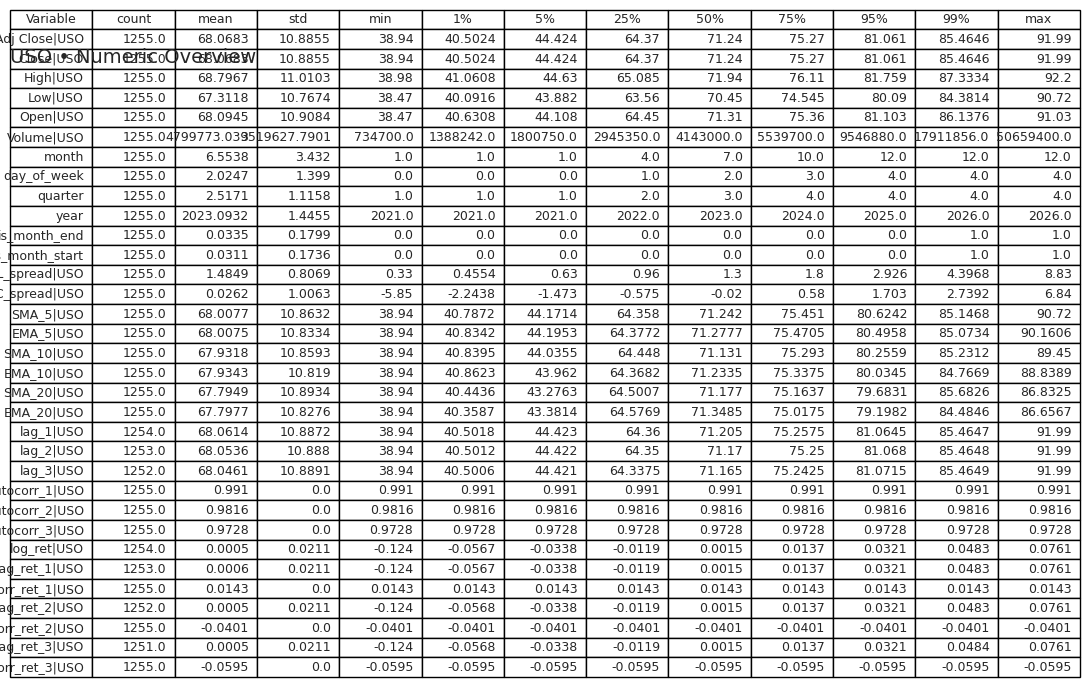

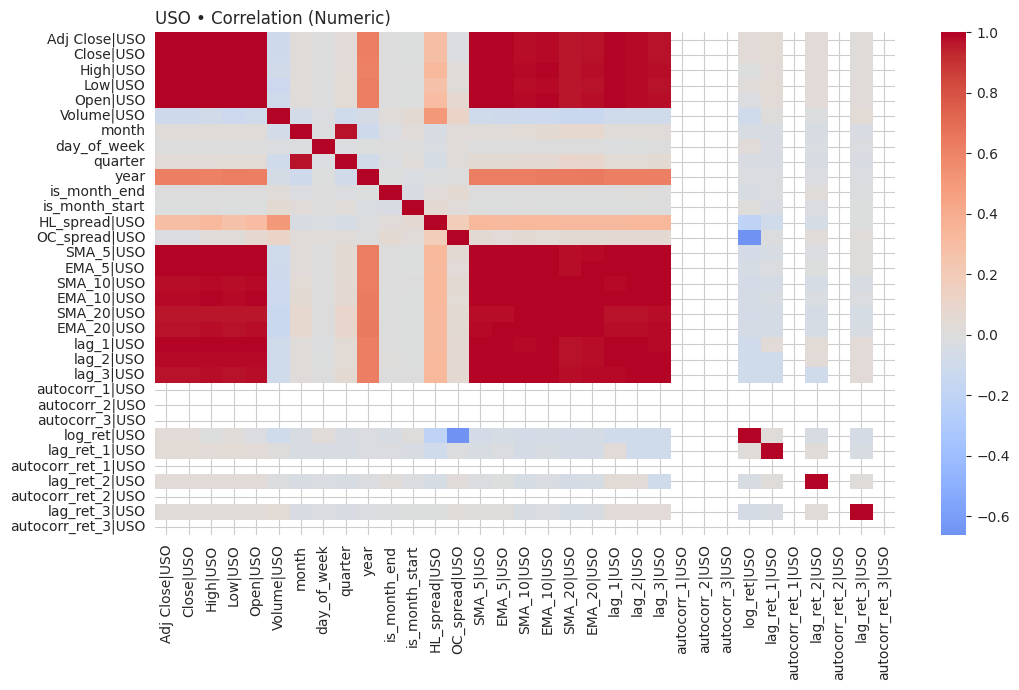

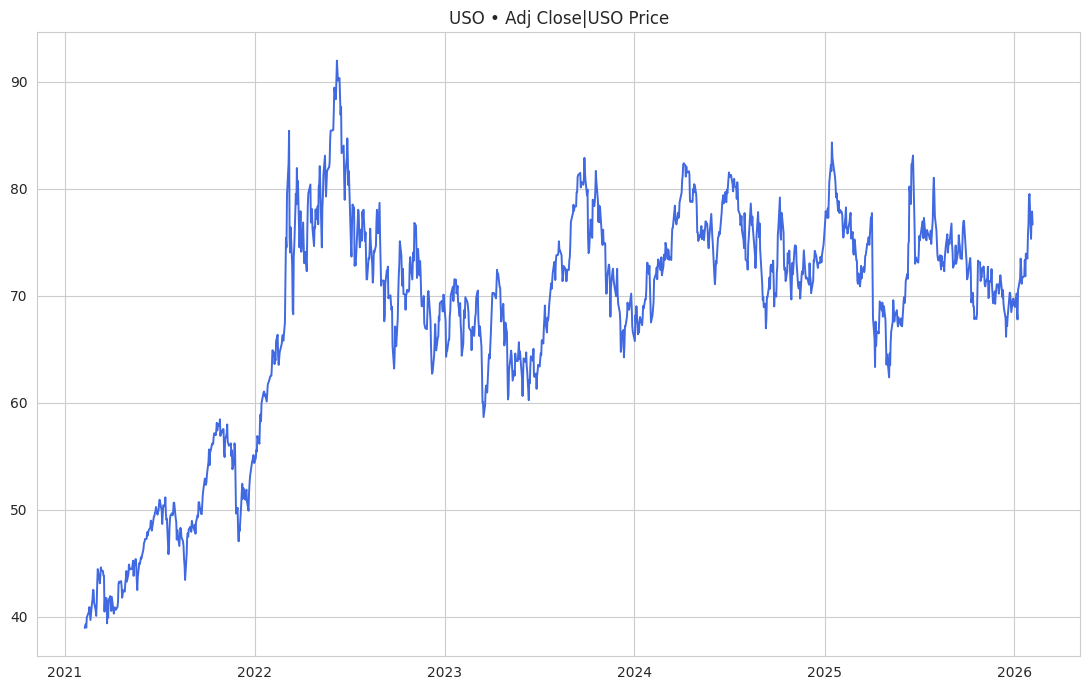

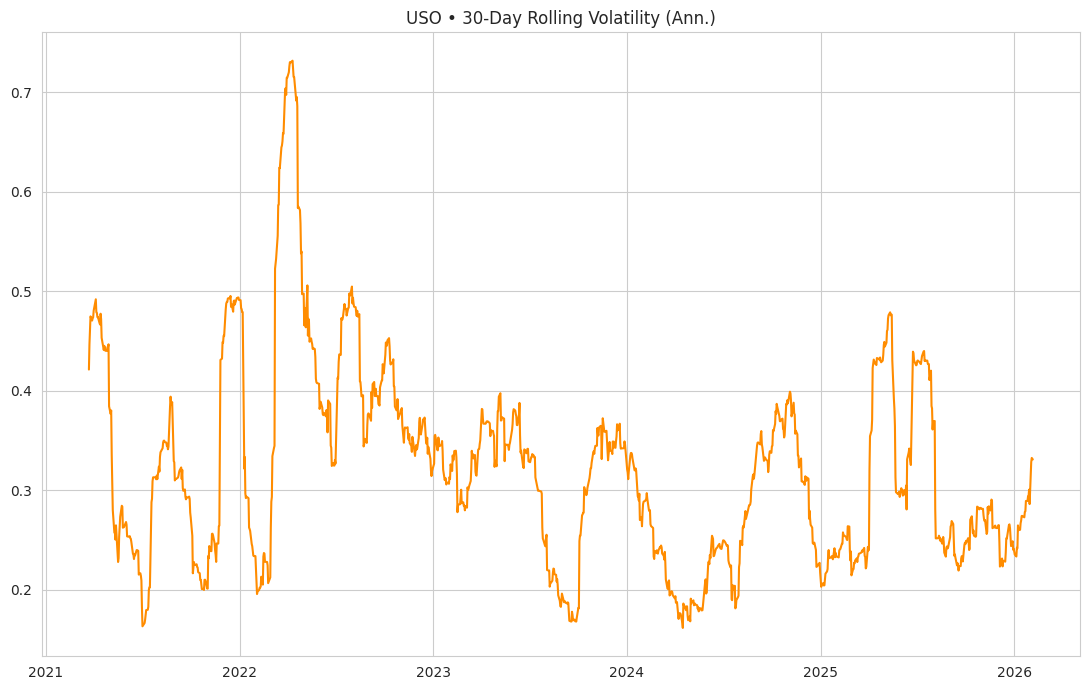

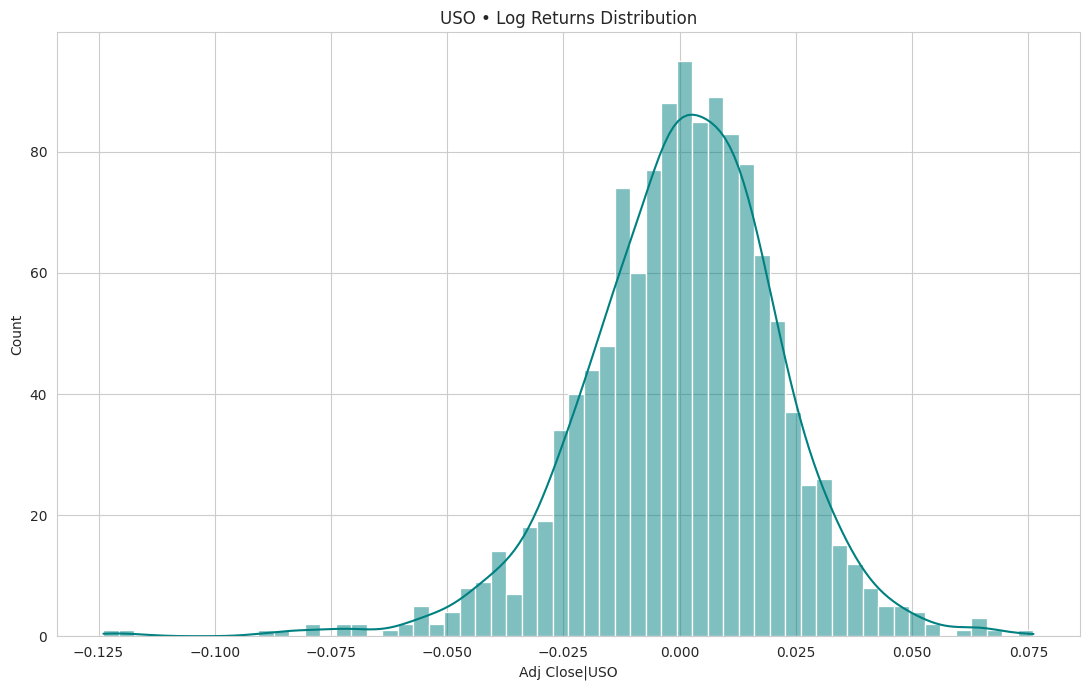

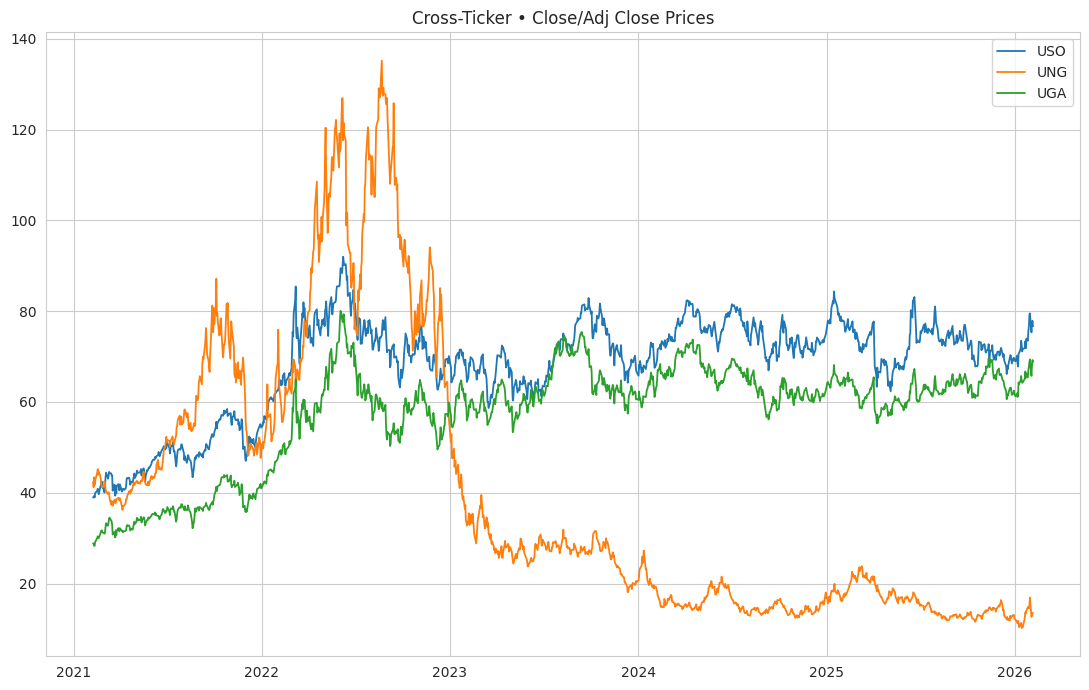

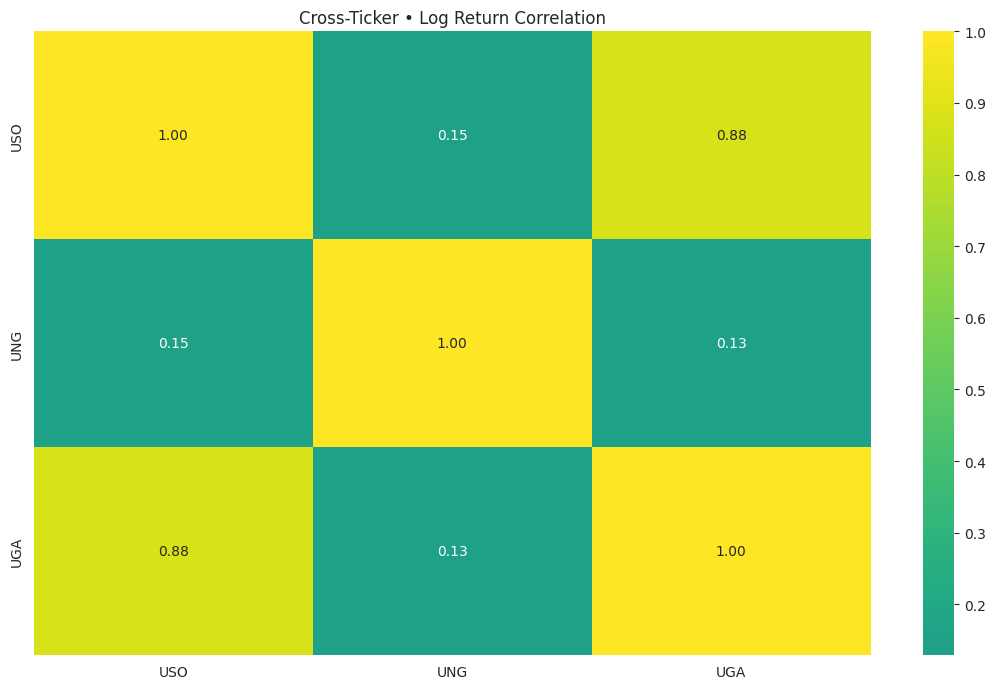

In [6]:
# -*- coding: utf-8 -*-
"""
Engineered Feature EDA Report for Energy ETFs (USO, UNG, UGA)

This version is modified to run directly on the following 
already-loaded DataFrames:

    uso_df, ung_df, uga_df

It does NOT read Excel files and does NOT require multi-index headers.

The report includes:
    • Schema & Missingness
    • Numeric Quality & Ranges
    • Numeric Overview (Describe)
    • Correlation Heatmap
    • Price Trend (Close/Adj Close)
    • Rolling 30-Day Volatility
    • Daily Log Return Distribution
    • Cross-Ticker Overlaid Prices
    • Cross-Ticker Return Correlation

Output:
    Engineered Feature EDA.pdf
"""

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from typing import Dict, List, Optional, Any

# --------------------------------------
# Plot Styling
# --------------------------------------
plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")


# --------------------------------------
# Helpers
# --------------------------------------
def _safe_title(name: str) -> str:
    return str(name).strip() if name else "Unknown"

def _select_numeric_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include=[np.number]).copy()

def _infer_close_col(df: pd.DataFrame) -> Optional[str]:
    """
    Attempts to infer a close-like column:
      - prefers columns containing 'Adj Close'
      - otherwise exact 'Close'
      - otherwise any column containing 'close'
    """
    cols = {str(c).lower(): c for c in df.columns}

    # Priority search
    for key in cols:
        if "adj close" in key:
            return cols[key]
    if "close" in cols:
        return cols["close"]
    for key in cols:
        if "close" in key:
            return cols[key]

    return None

def _daily_returns(series: pd.Series) -> pd.Series:
    return np.log(series).diff()

def _inject_index_as_column(df: pd.DataFrame, name: str = "Variable") -> pd.DataFrame:
    idx_name = df.index.name if df.index.name not in [None, ""] else name
    out = df.reset_index()
    if out.columns[0] != idx_name:
        out = out.rename(columns={out.columns[0]: idx_name})
    return out

def _table_figure_from_dataframe(
    df: pd.DataFrame, title: str, font_size: int = 9
) -> plt.Figure:
    fig_height = min(7, 1 + 0.35 * (len(df) + 2))
    fig, ax = plt.subplots(figsize=(11, fig_height))
    ax.axis("off")
    ax.set_title(title, fontsize=14, pad=12, loc="left")

    display_df = df.copy()

    tbl = ax.table(
        cellText=display_df.round(4).values.tolist(),
        colLabels=[str(c) for c in display_df.columns],
        loc="center",
        cellLoc="right",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1, 1.2)

    return fig

def _corr_heatmap(df: pd.DataFrame, title: str) -> plt.Figure:
    num = _select_numeric_cols(df)
    if num.empty:
        info = pd.DataFrame({"Message": ["No numeric columns."]})
        info = _inject_index_as_column(info)
        return _table_figure_from_dataframe(info, title + " • Not Available")

    corr = num.corr()
    fig, ax = plt.subplots()
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, ax=ax)
    ax.set_title(title, loc="left")
    return fig

def _rolling_volatility(series: pd.Series, window: int = 30) -> pd.Series:
    rets = _daily_returns(series).dropna()
    return rets.rolling(window).std() * math.sqrt(252)


# --------------------------------------
# Numeric EDA Tables
# --------------------------------------
def _schema_and_missing_table(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    n = len(df)

    for col in df.columns:
        s = df[col]
        non_null = s.notna().sum()
        missing = s.isna().sum()
        missing_pct = (missing / n * 100) if n > 0 else 0

        try:
            unique = s.nunique(dropna=True)
        except:
            unique = np.nan

        sample = s.dropna().iloc[0] if non_null > 0 else None

        rows.append({
            "Column": col,
            "dtype": str(s.dtype),
            "non_null": non_null,
            "missing": missing,
            "missing_%": round(missing_pct, 2),
            "unique": unique,
            "sample": sample
        })

    return pd.DataFrame(rows).set_index("Column")

def _numeric_quality_and_ranges(df: pd.DataFrame) -> pd.DataFrame:
    num = _select_numeric_cols(df)
    if num.empty:
        return pd.DataFrame({"Message": ["No numeric columns found."]})

    num = num.replace([np.inf, -np.inf], np.nan)
    rows = []

    for col in num.columns:
        s = num[col]
        non_null = s.notna().sum()
        missing = s.isna().sum()

        zeros = (s == 0).sum() if non_null > 0 else 0
        negatives = (s < 0).sum() if non_null > 0 else 0

        if non_null > 0:
            stats = {
                "min": s.min(),
                "p01": s.quantile(0.01),
                "q1": s.quantile(0.25),
                "median": s.quantile(0.5),
                "mean": s.mean(),
                "q3": s.quantile(0.75),
                "p99": s.quantile(0.99),
                "max": s.max(),
                "std": s.std()
            }
        else:
            stats = {k: np.nan for k in 
                ["min","p01","q1","median","mean","q3","p99","max","std"]}

        rows.append({
            "Column": col,
            "non_null": non_null,
            "missing": missing,
            "missing_%": round(missing/len(num)*100, 2),
            "zeros": zeros,
            "negatives": negatives,
            **stats
        })

    return pd.DataFrame(rows).set_index("Column")


# --------------------------------------
# Single Ticker EDA
# --------------------------------------
def eda_single_ticker(name: str, df: pd.DataFrame) -> List[plt.Figure]:
    figs = []
    ticker = _safe_title(name)

    df = df.copy().sort_index()

    # Schema table
    schema = _schema_and_missing_table(df)
    schema = _inject_index_as_column(schema)
    figs.append(_table_figure_from_dataframe(schema, f"{ticker} • Schema & Missingness"))

    # Numeric ranges
    numqlt = _numeric_quality_and_ranges(df)
    numqlt = _inject_index_as_column(numqlt)
    figs.append(_table_figure_from_dataframe(numqlt, f"{ticker} • Numeric Quality & Ranges"))

    # Describe
    num = _select_numeric_cols(df)
    if not num.empty:
        desc = num.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
        desc = _inject_index_as_column(desc)
        figs.append(_table_figure_from_dataframe(desc, f"{ticker} • Numeric Overview"))
    else:
        msg = pd.DataFrame({"Message": ["No numeric columns."]})
        figs.append(_table_figure_from_dataframe(msg, f"{ticker} • Describe"))

    # Correlation
    figs.append(_corr_heatmap(df, f"{ticker} • Correlation (Numeric)"))

    # Price plots
    close_col = _infer_close_col(df)
    if close_col:
        price = df[close_col].astype(float)

        # Price TS
        fig, ax = plt.subplots()
        ax.plot(price.index, price.values, color="royalblue", lw=1.4)
        ax.set_title(f"{ticker} • {close_col} Price")
        figs.append(fig)

        # Rolling vol
        vol = _rolling_volatility(price)
        fig, ax = plt.subplots()
        ax.plot(vol.index, vol.values, color="darkorange")
        ax.set_title(f"{ticker} • 30-Day Rolling Volatility (Ann.)")
        figs.append(fig)

        # Return distribution
        rets = _daily_returns(price).dropna()
        fig, ax = plt.subplots()
        sns.histplot(rets, bins=60, kde=True, color="teal")
        ax.set_title(f"{ticker} • Log Returns Distribution")
        figs.append(fig)

    else:
        msg = pd.DataFrame({
            "Message": [f"No Close/Adj Close column found for {ticker}."]
        })
        figs.append(_table_figure_from_dataframe(msg, f"{ticker} • Price Not Available"))

    return figs


# --------------------------------------
# Cross-Ticker EDA (USO, UNG, UGA)
# --------------------------------------
def eda_cross_ticker(frames: Dict[str, pd.DataFrame]) -> List[plt.Figure]:
    figs = []
    prices_dict = {}

    for name, df in frames.items():
        col = _infer_close_col(df)
        if col:
            prices_dict[name] = df[col].astype(float)

    if prices_dict:
        prices = pd.DataFrame(prices_dict).sort_index()

        # Price overlay
        fig, ax = plt.subplots()
        for c in prices.columns:
            ax.plot(prices.index, prices[c], lw=1.3, label=c)
        ax.legend()
        ax.set_title("Cross-Ticker • Close/Adj Close Prices")
        figs.append(fig)

        # Return correlation
        rets = prices.apply(np.log).diff().dropna()
        corr = rets.corr()

        fig, ax = plt.subplots()
        sns.heatmap(corr, cmap="viridis", annot=True, fmt=".2f", center=0)
        ax.set_title("Cross-Ticker • Log Return Correlation")
        figs.append(fig)

    return figs


# --------------------------------------
# Build Report
# --------------------------------------
def build_engineered_feature_eda(
    frames: Dict[str, pd.DataFrame],
    pdf_title: str = "Engineered Feature EDA.pdf",
    show_plots: bool = True
):
    ordered_items = sorted(frames.items(), key=lambda x: x[0])
    figs = []

    # Per ticker
    for name, df in ordered_items:
        figs.extend(eda_single_ticker(name, df))

    # Cross-Ticker
    figs.extend(eda_cross_ticker(frames))

    # Write PDF
    with PdfPages(pdf_title) as pdf:
        cover, ax = plt.subplots()
        ax.axis("off")
        ax.text(0, 0.9, "Engineered Feature EDA", fontsize=22, weight="bold")
        ax.text(0, 0.78, "Tickers: " + ", ".join(frames.keys()), fontsize=12)

        lines = [
            "• Schema & Missingness",
            "• Numeric Quality & Ranges",
            "• Numeric Overview",
            "• Correlation Heatmap",
            "• Price Trend & Volatility",
            "• Log-Return Distribution",
            "• Cross-Ticker Price Overlay",
            "• Cross-Ticker Return Correlation",
        ]
        for i, l in enumerate(lines):
            ax.text(0.02, 0.66 - i*0.05, l, fontsize=12)

        pdf.savefig(cover)
        plt.close(cover)

        for fig in figs:
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ PDF saved: {pdf_title}")

    if show_plots:
        for name, df in ordered_items:
            for fig in eda_single_ticker(name, df):
                plt.show()

        for fig in eda_cross_ticker(frames):
            plt.show()


# --------------------------------------
# Example Usage
# --------------------------------------
if __name__ == "__main__":
    # YOU ALREADY HAVE THESE IN MEMORY:
    # uso_df, ung_df, uga_df

    frames = {
        "USO": uso_df,
        "UNG": ung_df,
        "UGA": uga_df,
    }

    build_engineered_feature_eda(frames)

## Generate EDF Report

/tmp/ipykernel_6285/3423864328.py:361: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)
/tmp/ipykernel_6285/3423864328.py:445: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res, x="Group", y="AvgRet", palette="Blues_d", ax=ax)
/tmp/ipykernel_6285/3423864328.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/tmp/ipykernel_6285/3423864328.py:361: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

✅ PDF saved: Energy ETF report.pdf


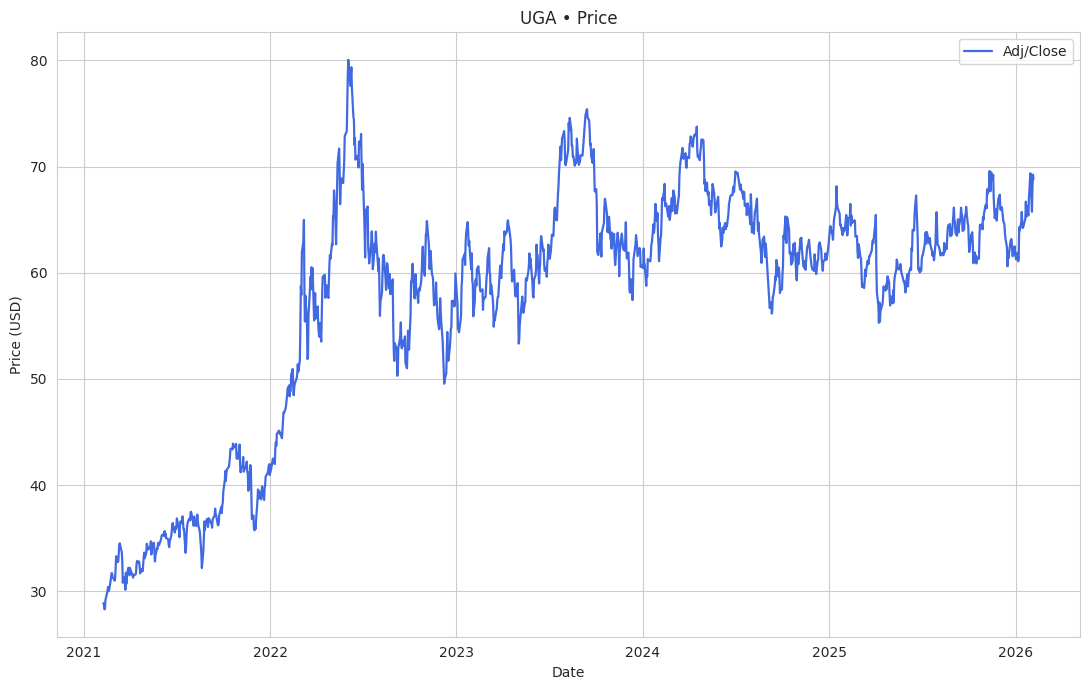

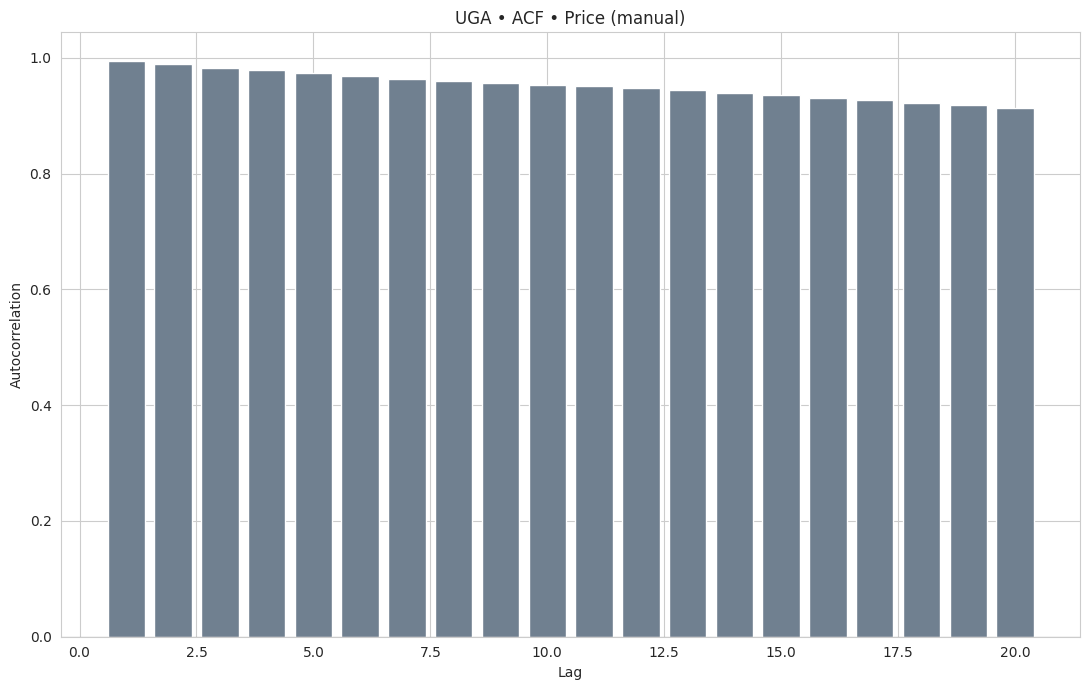

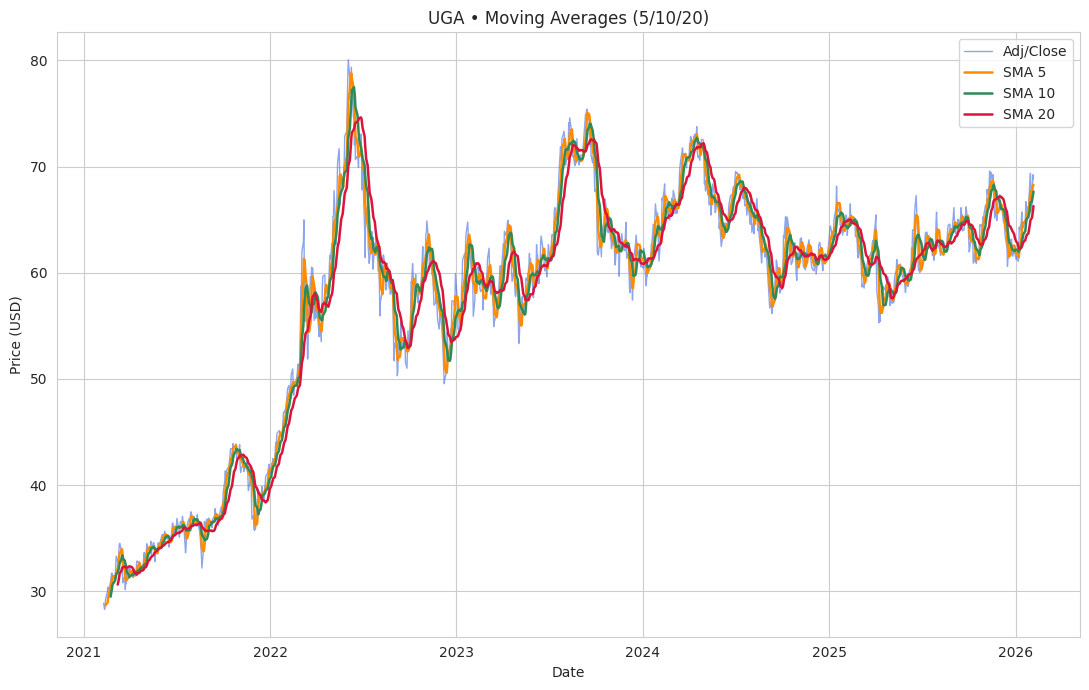

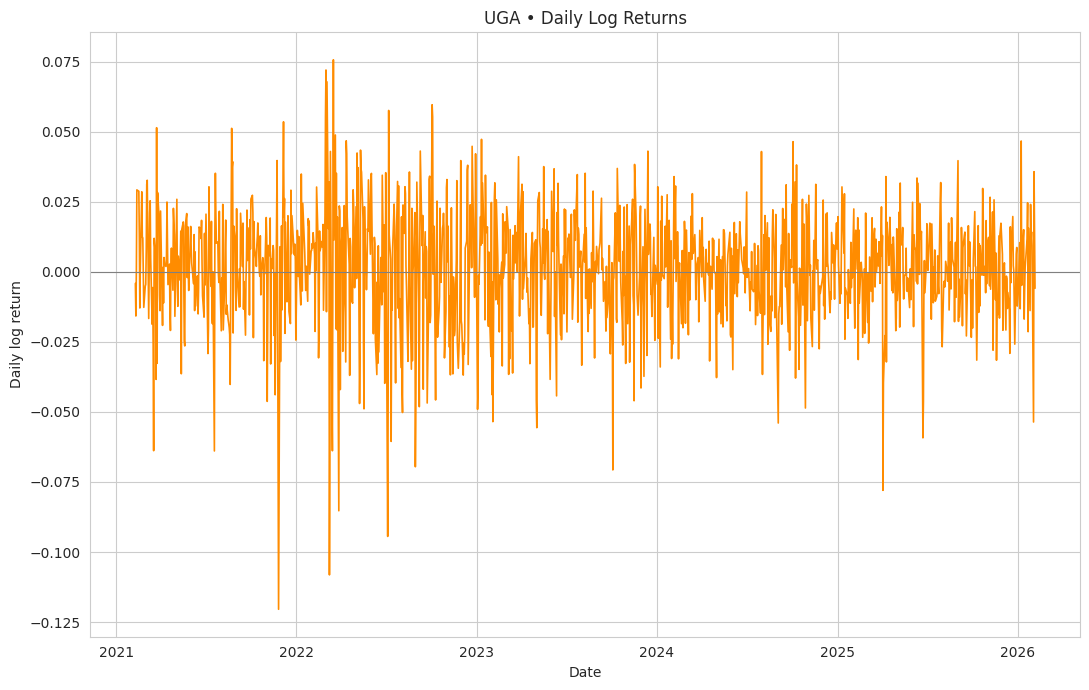

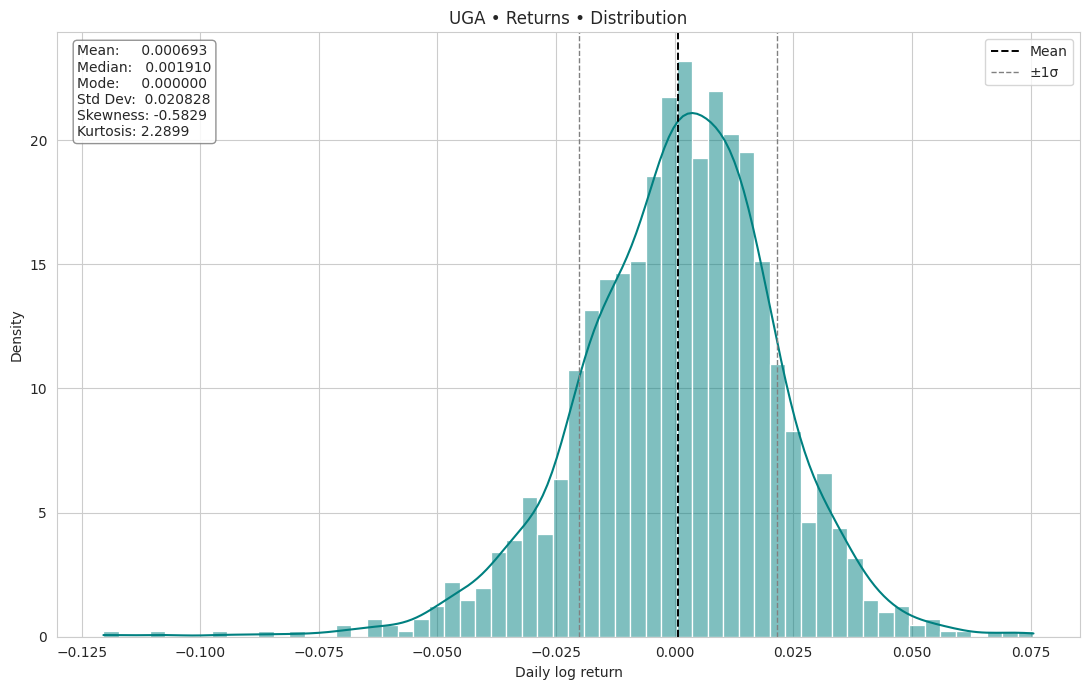

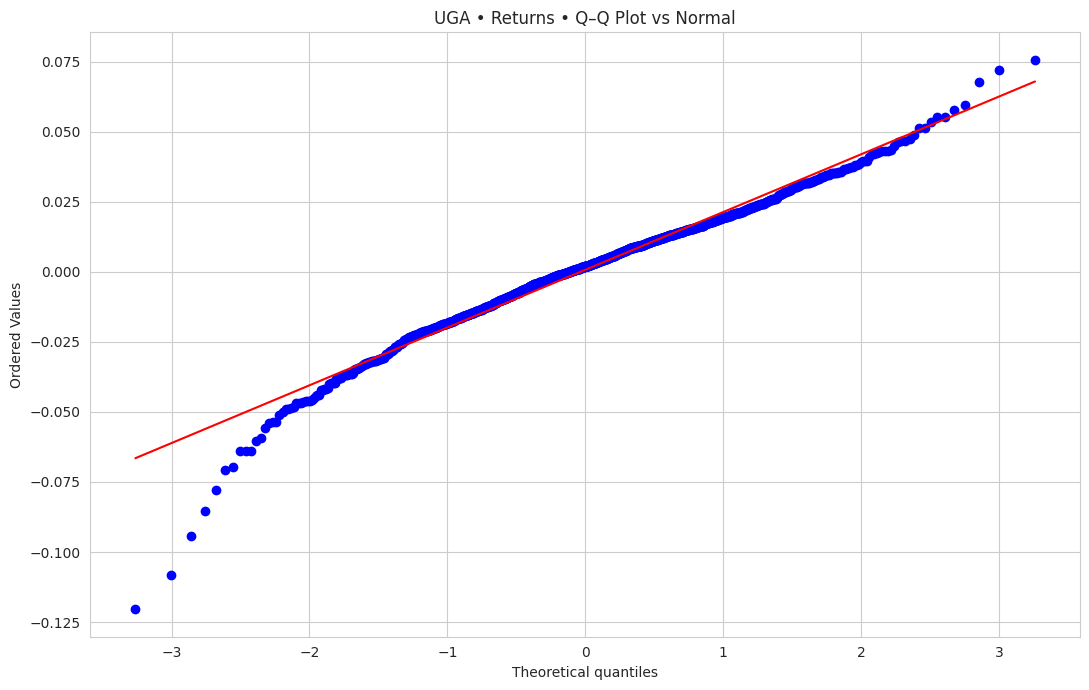

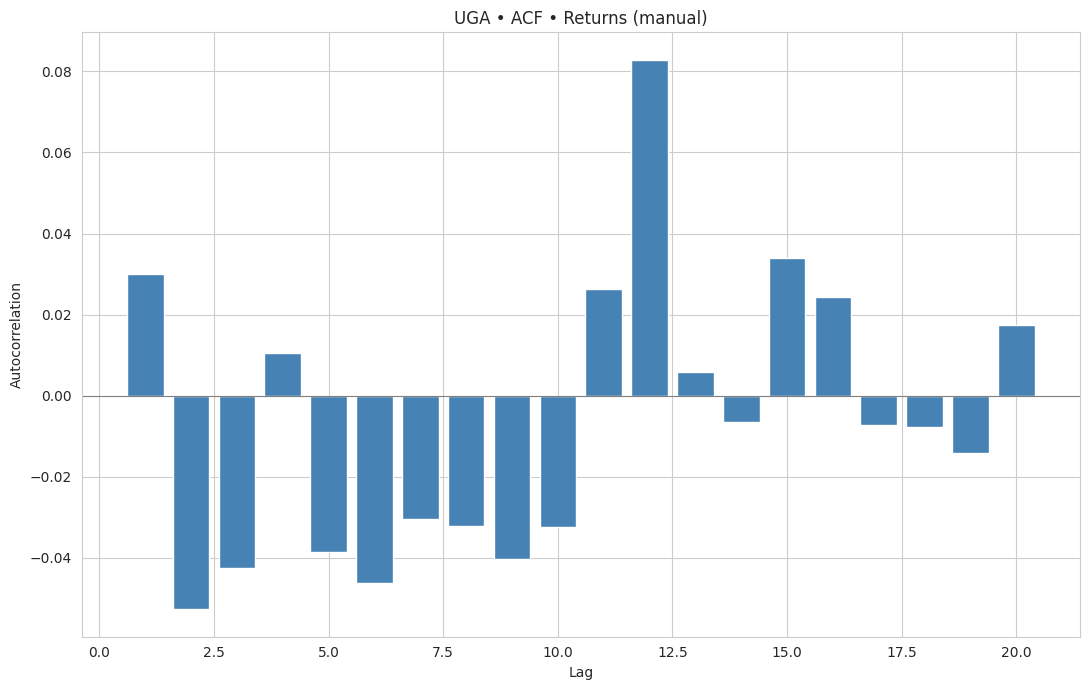

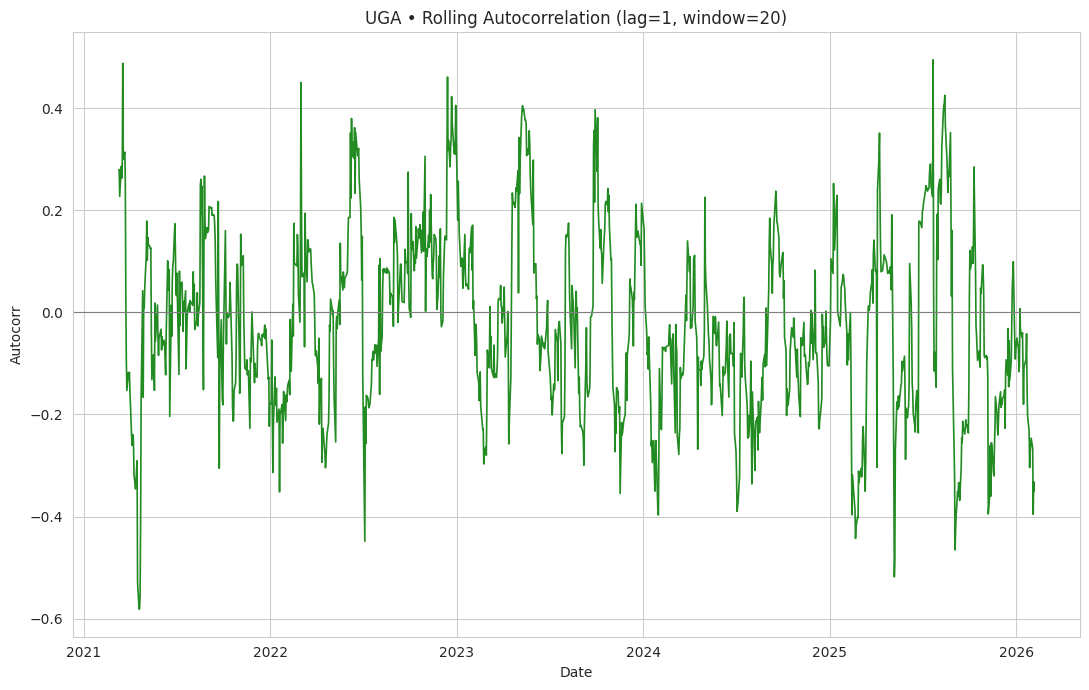

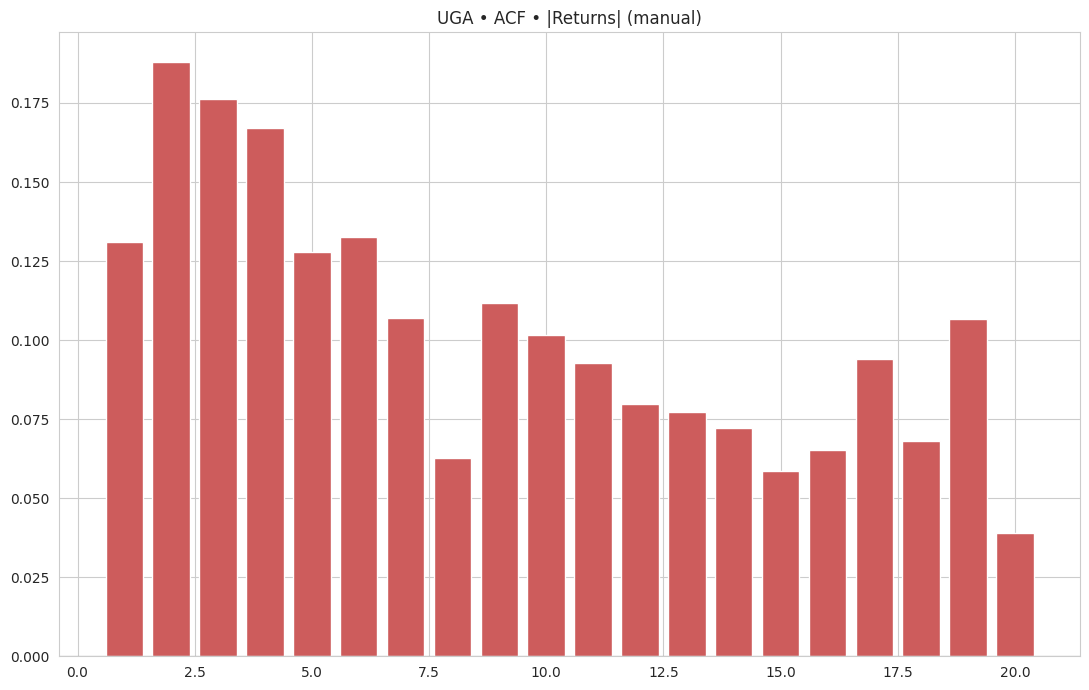

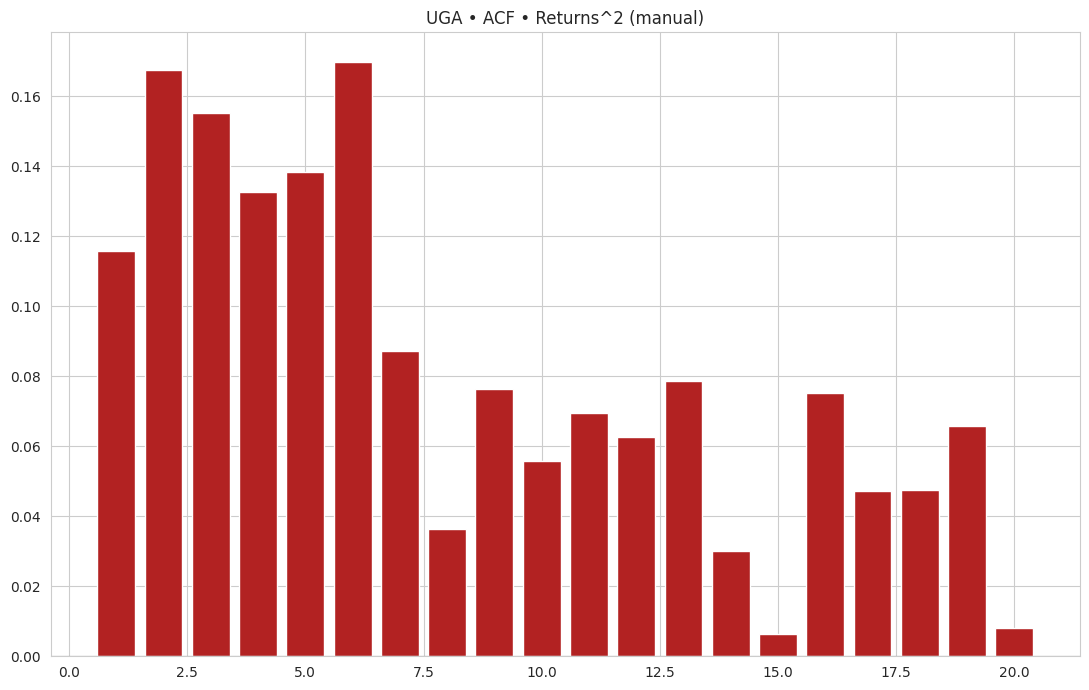

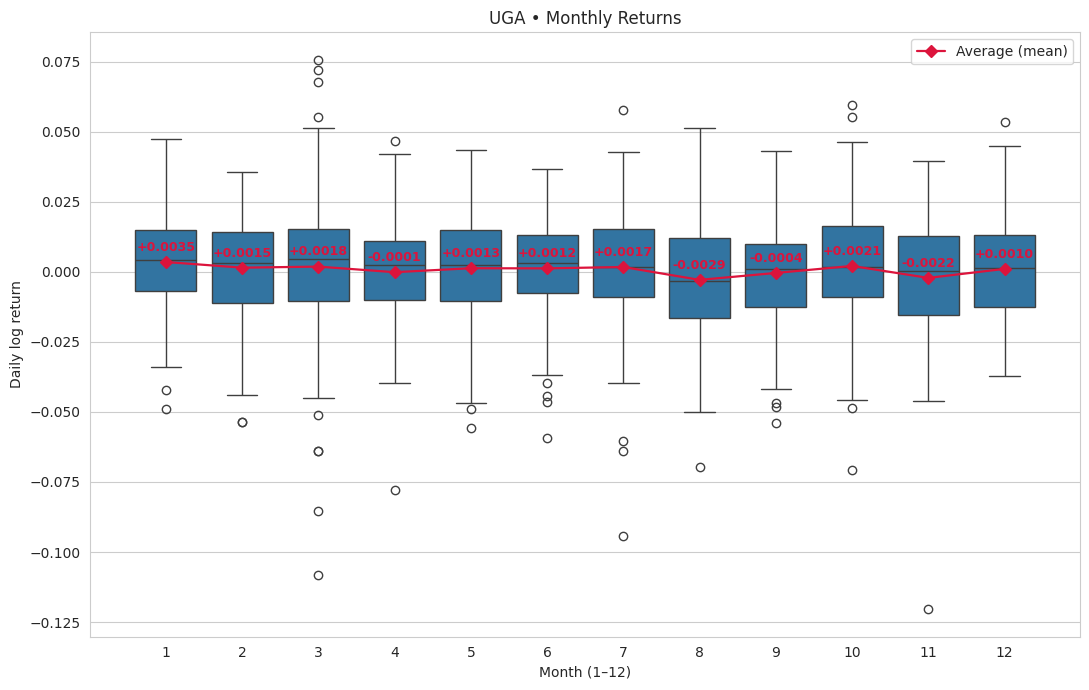

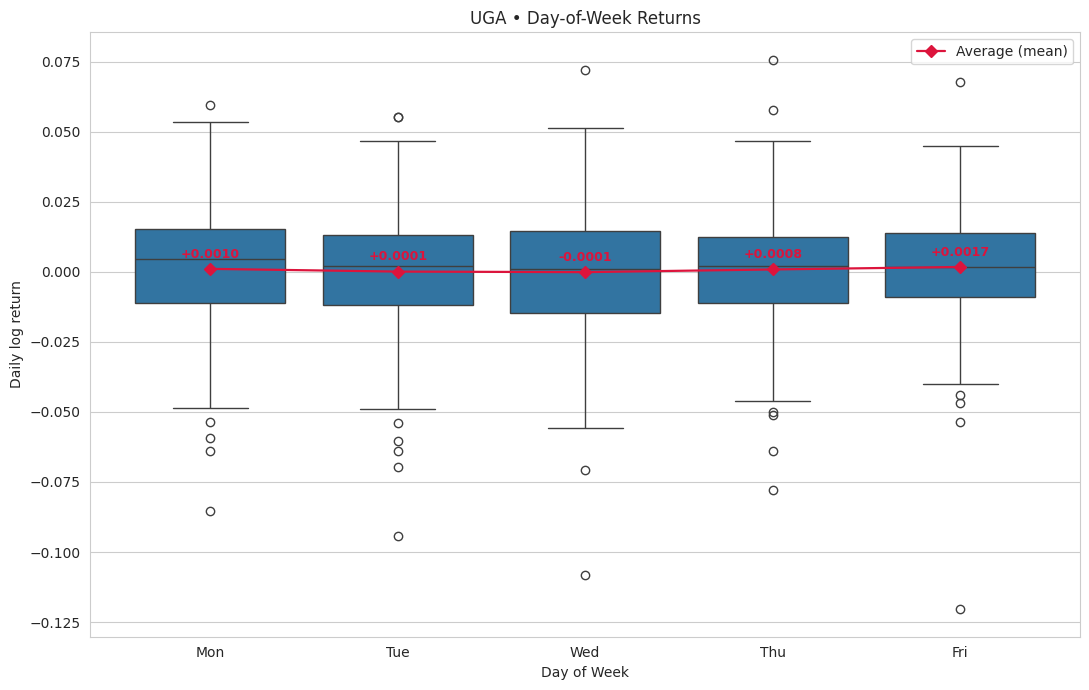

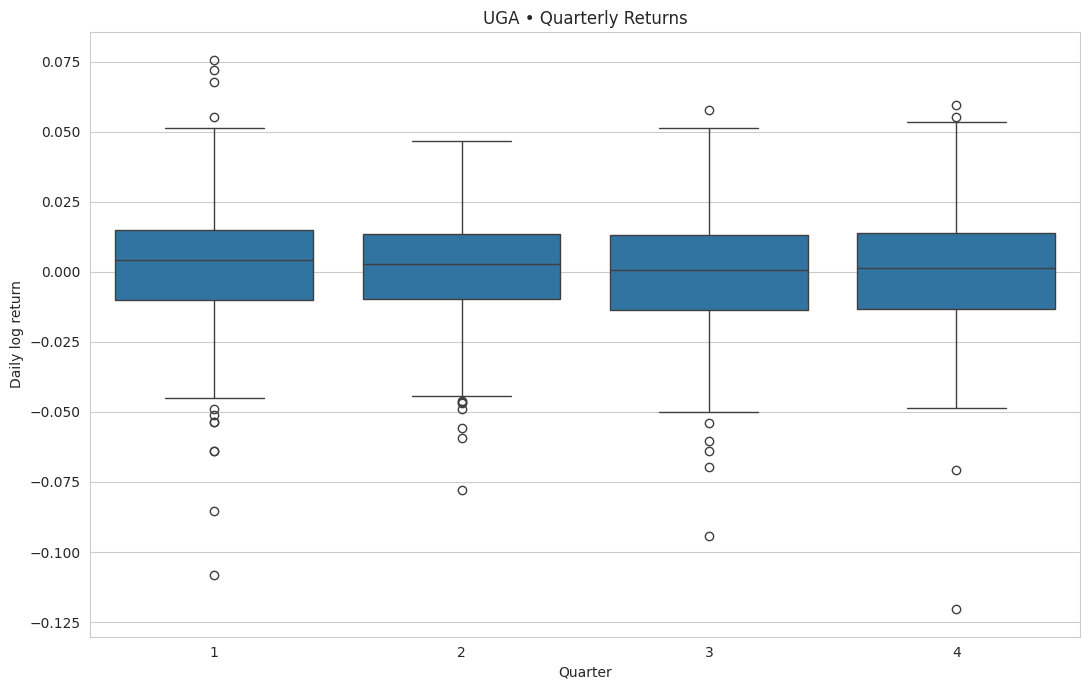

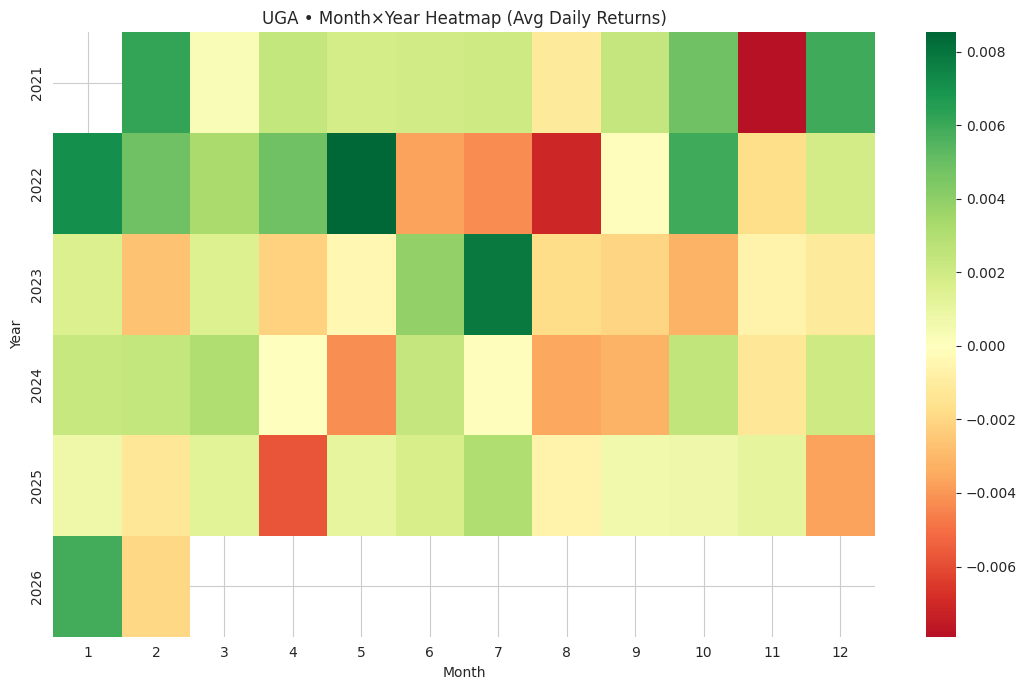

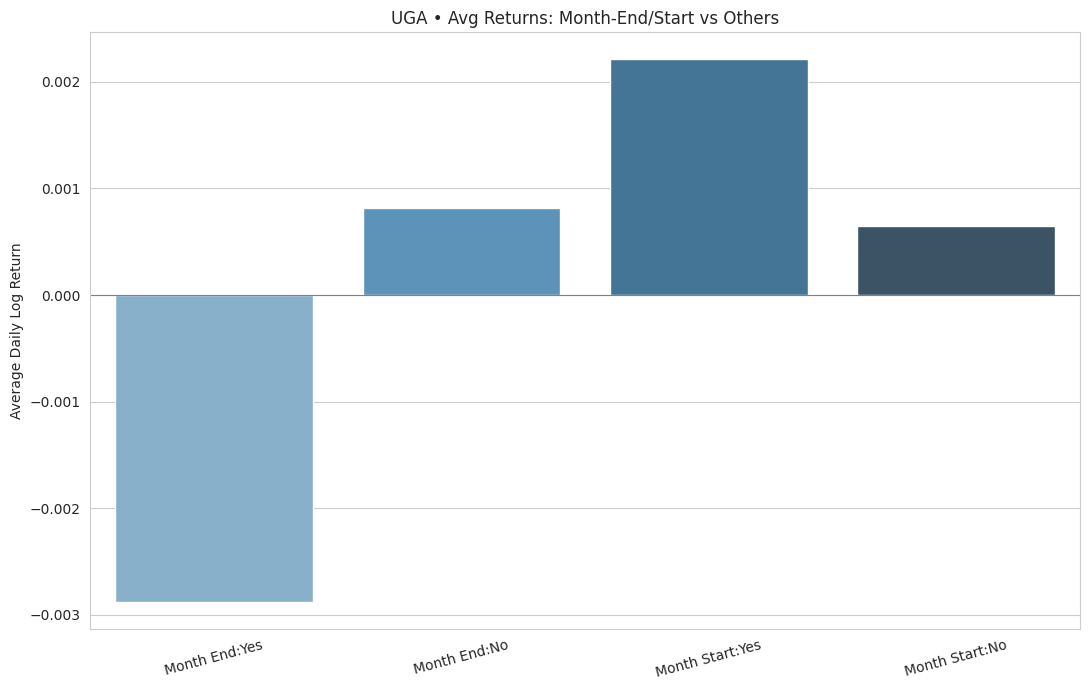

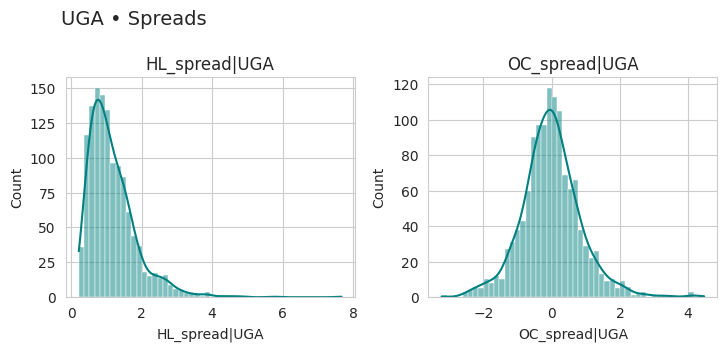

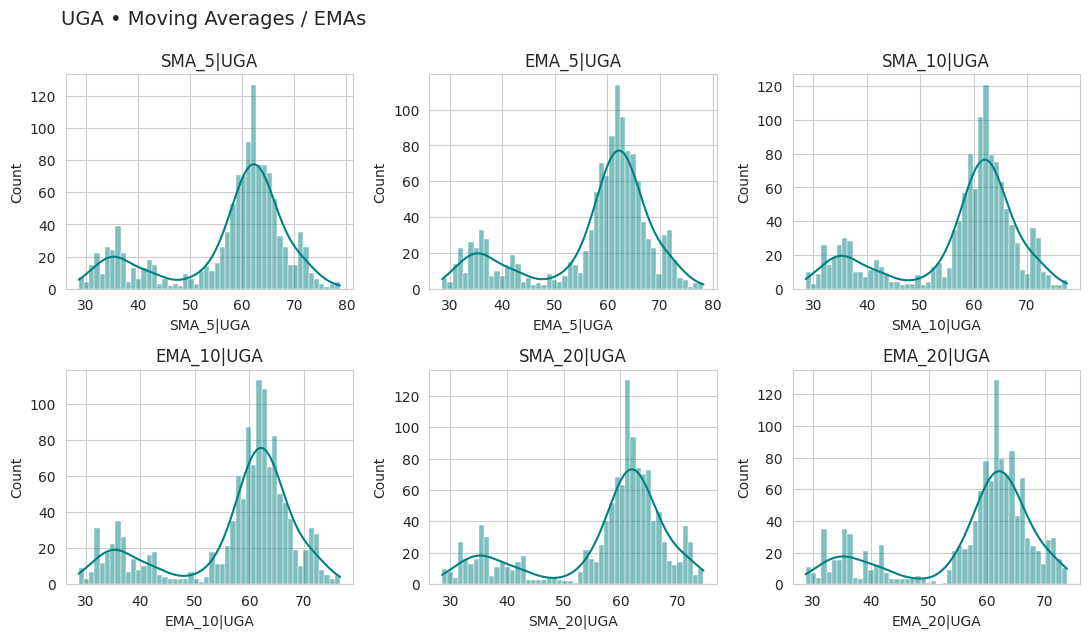

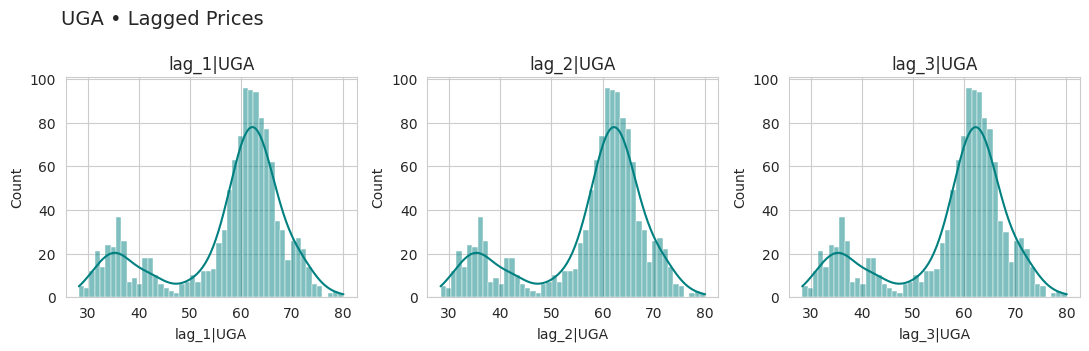

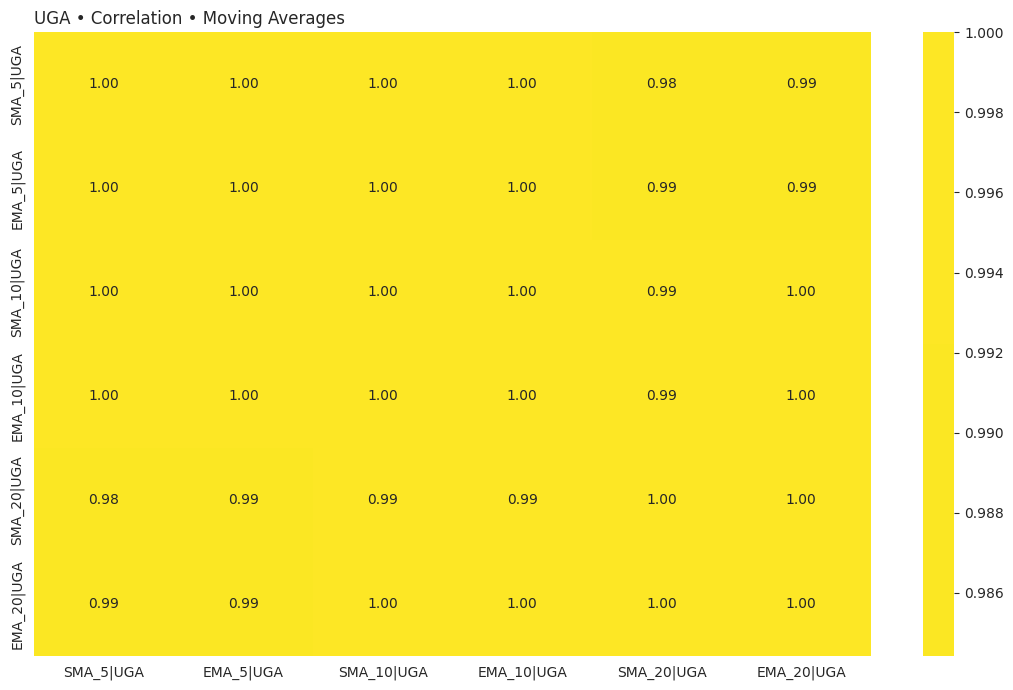

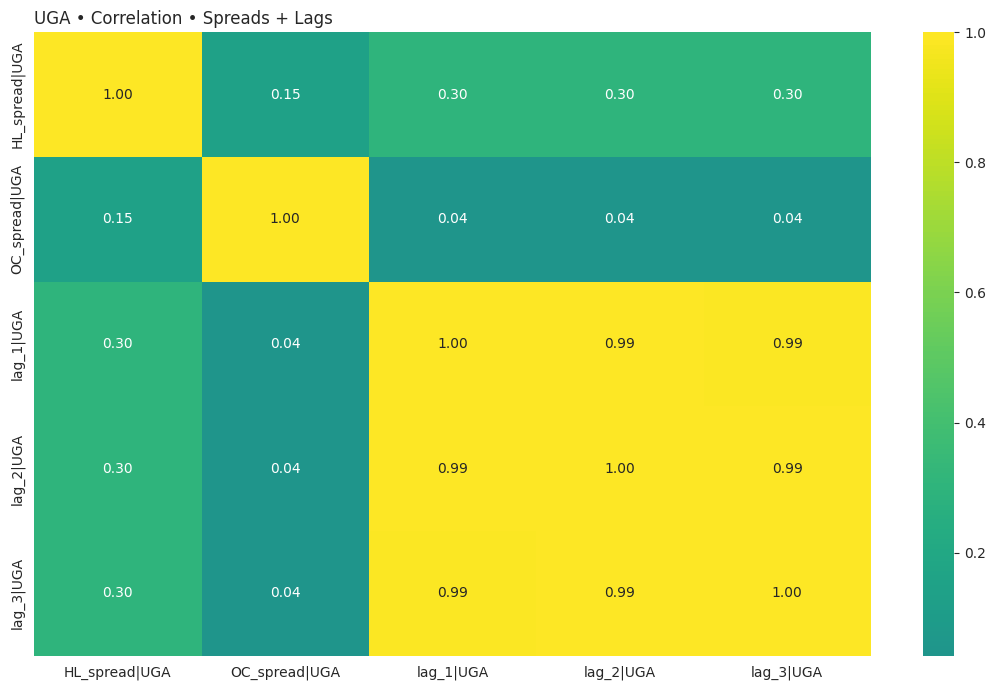

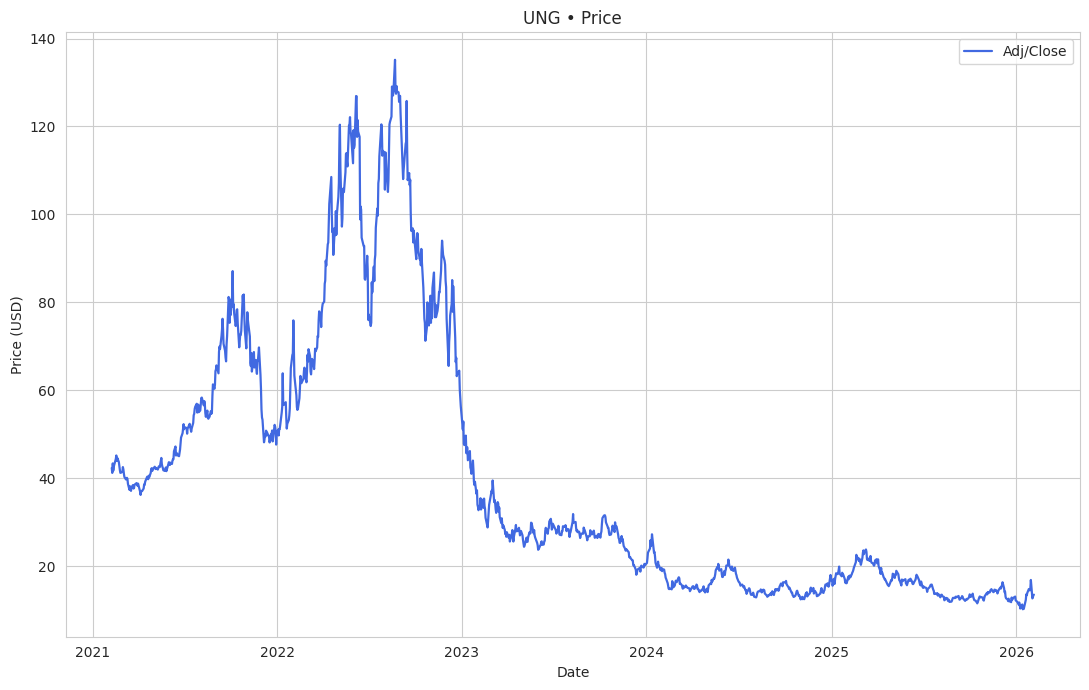

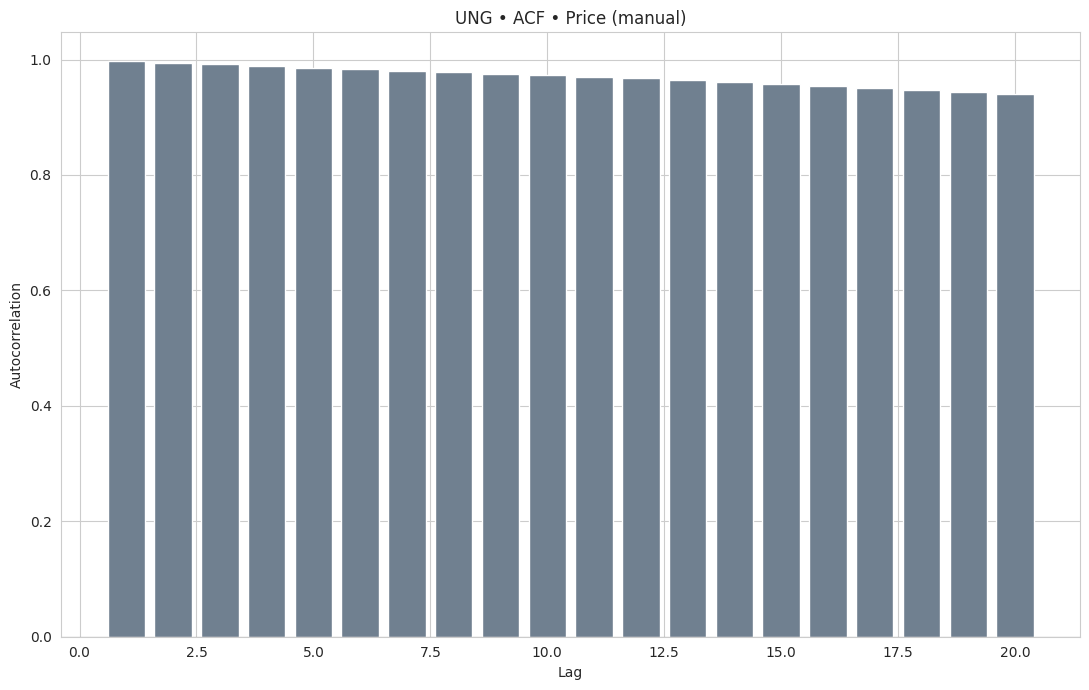

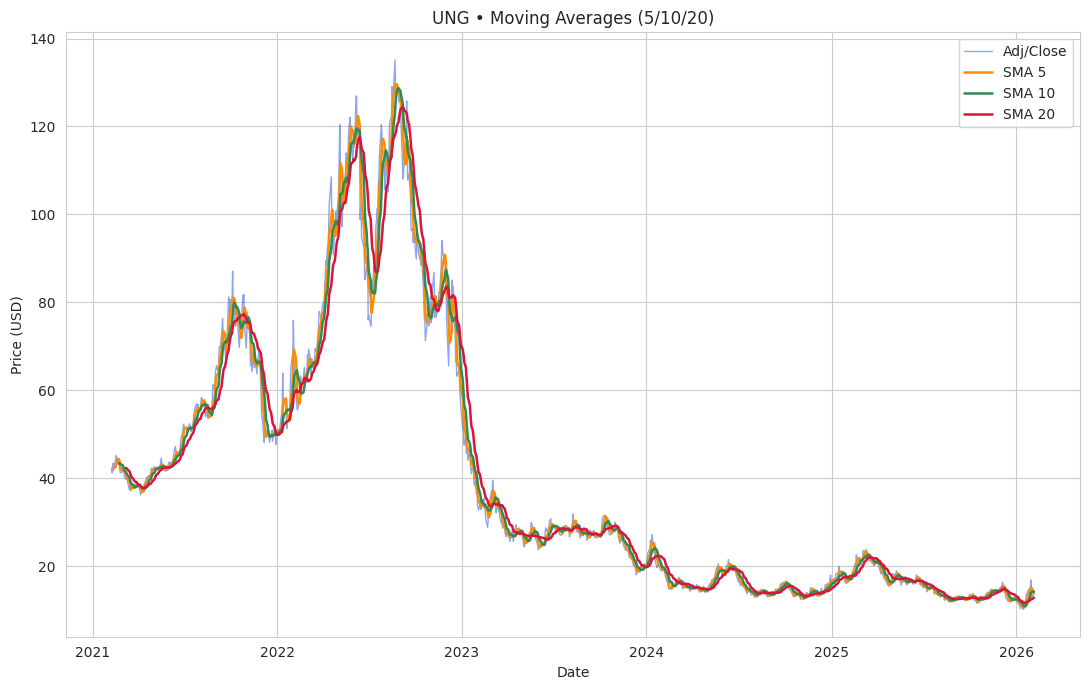

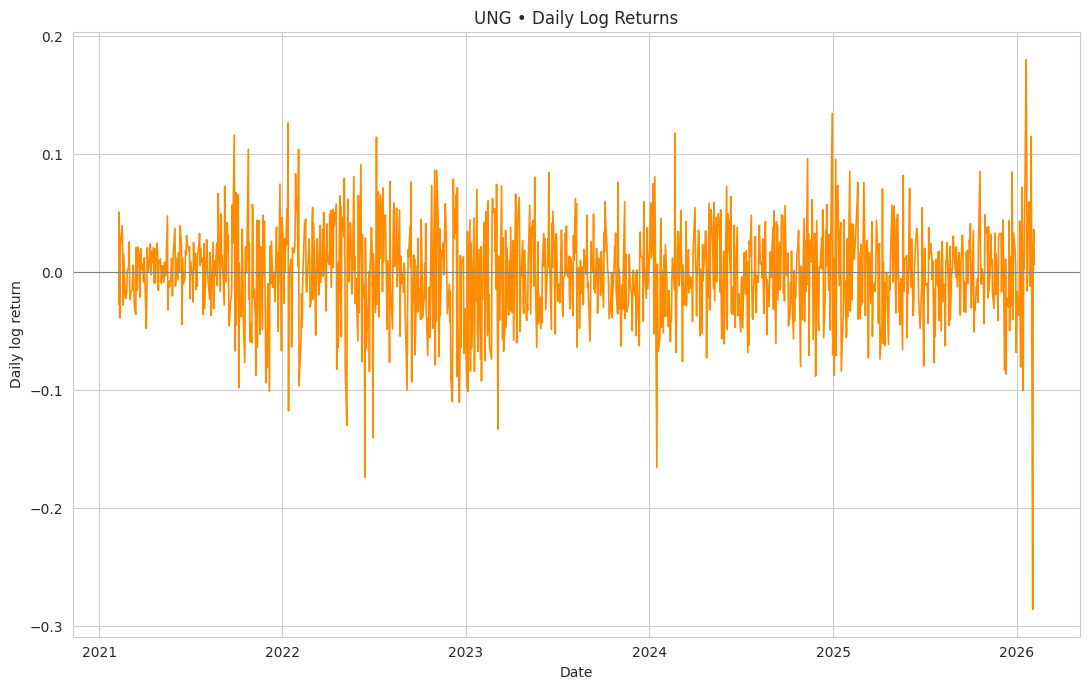

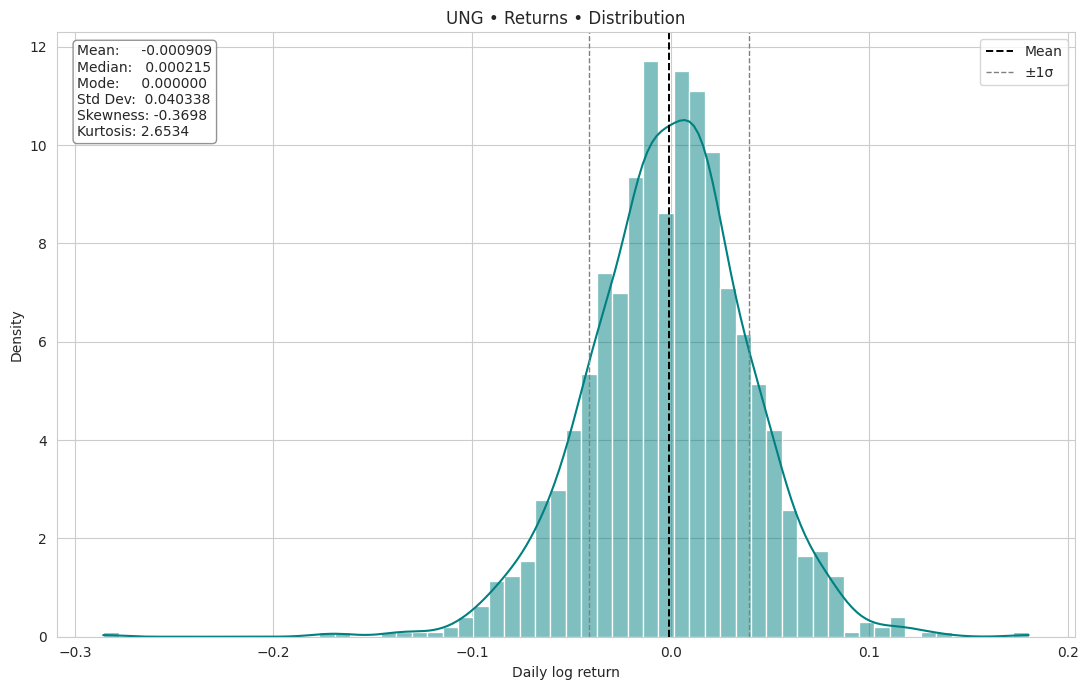

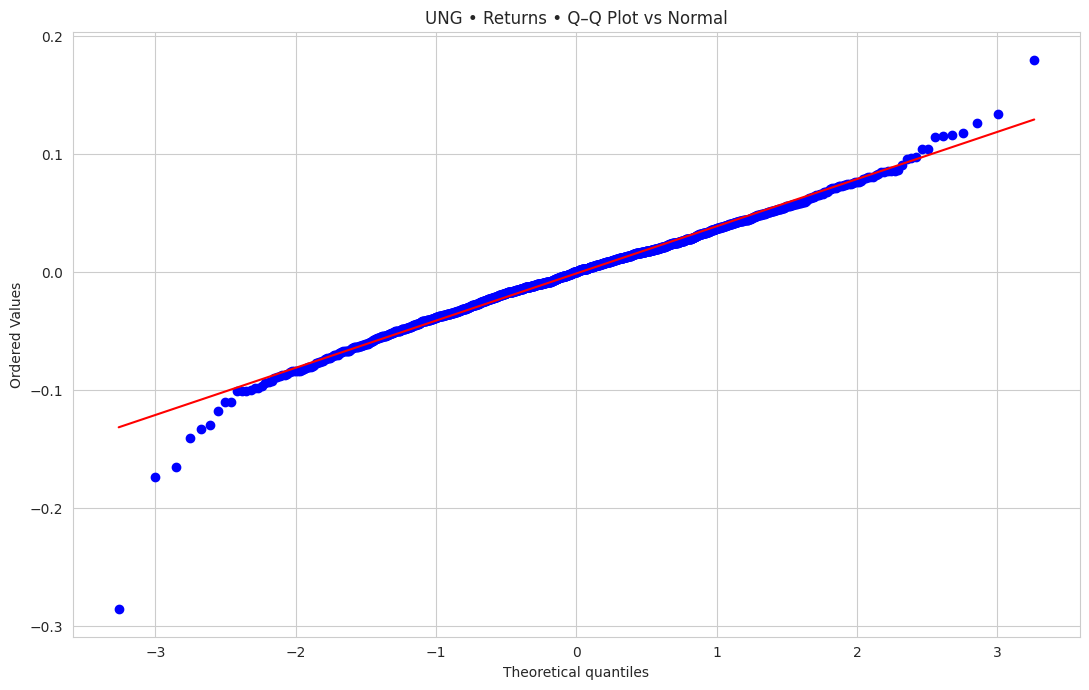

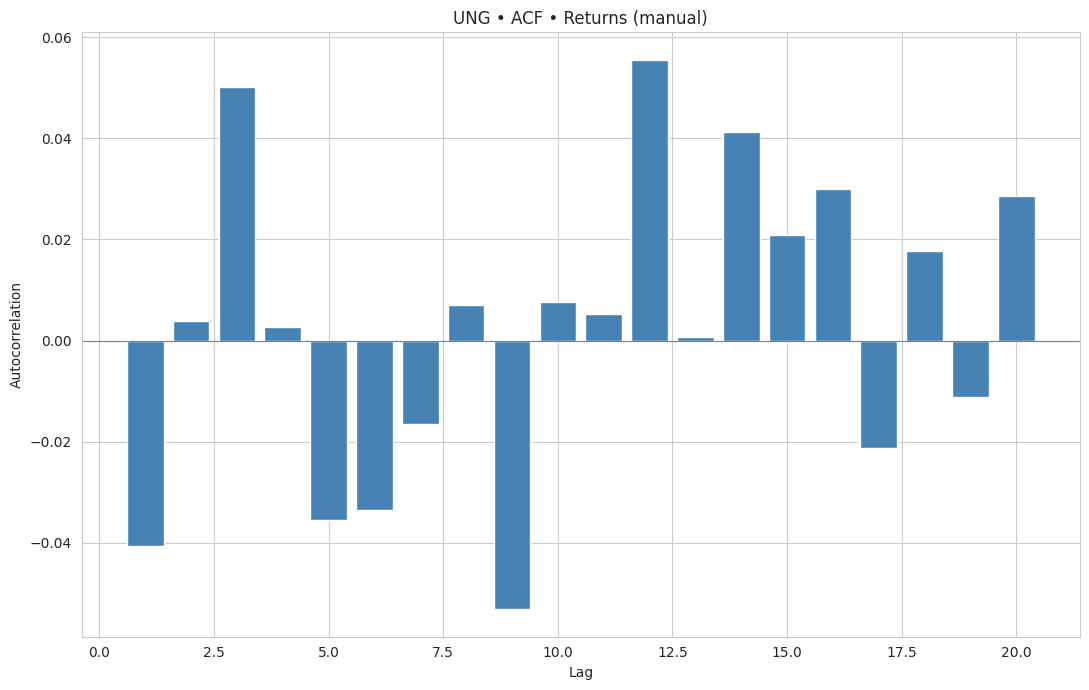

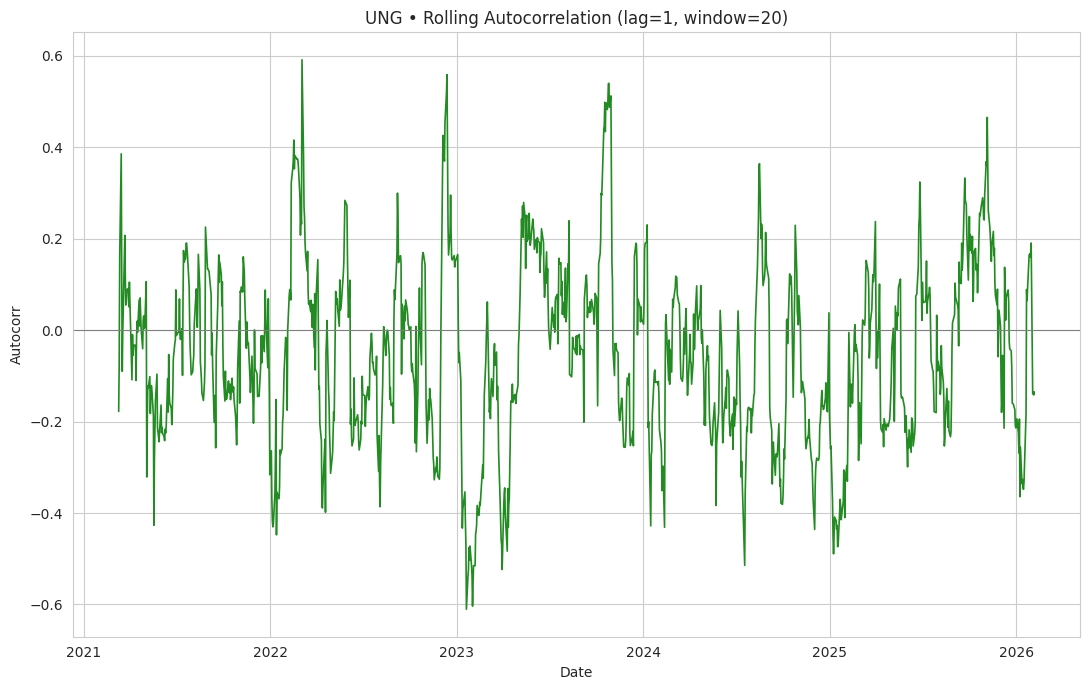

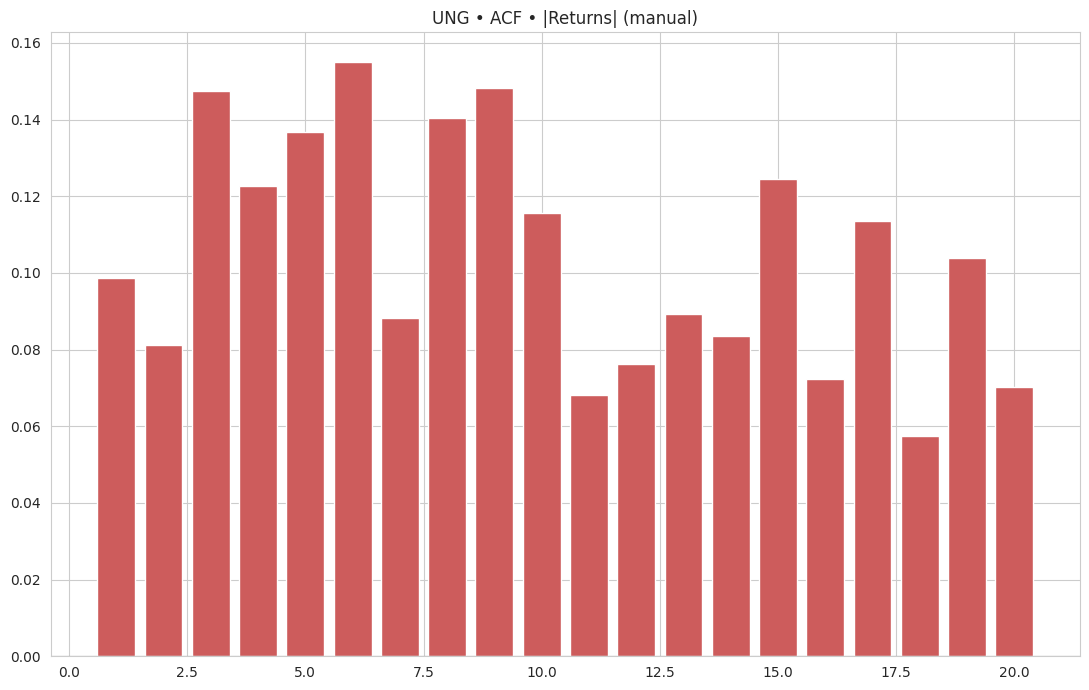

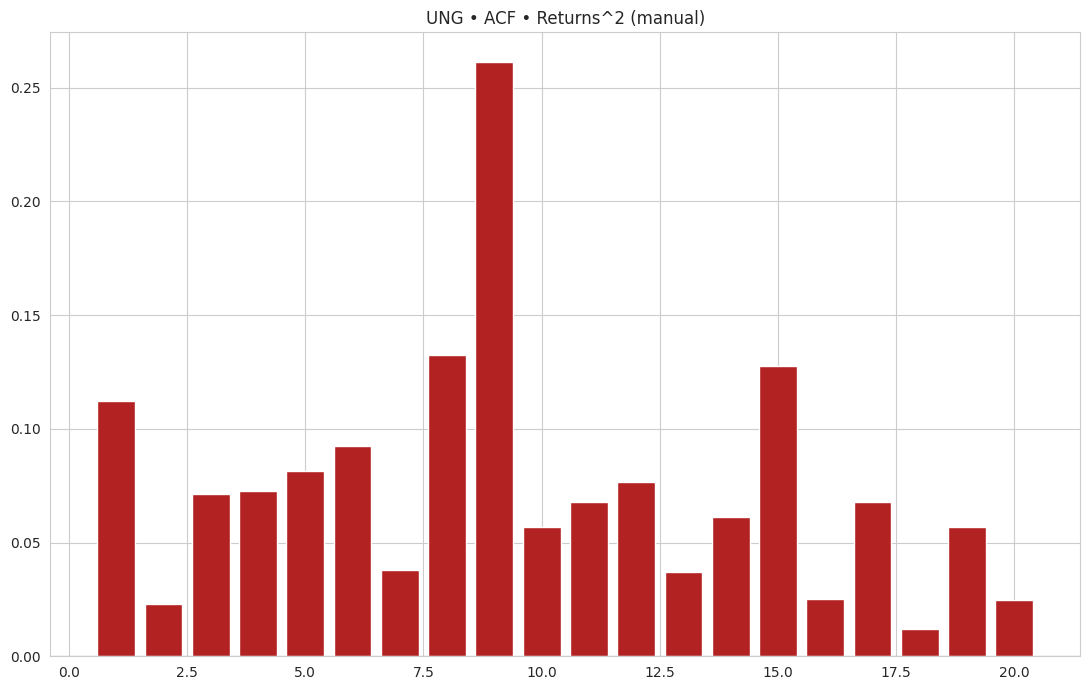

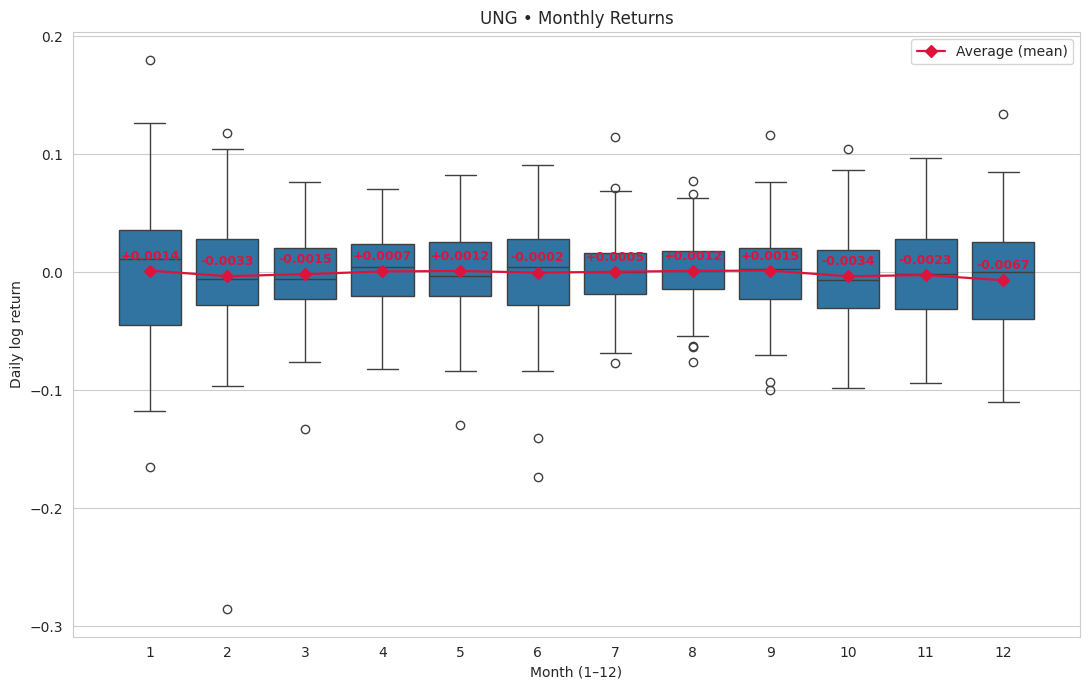

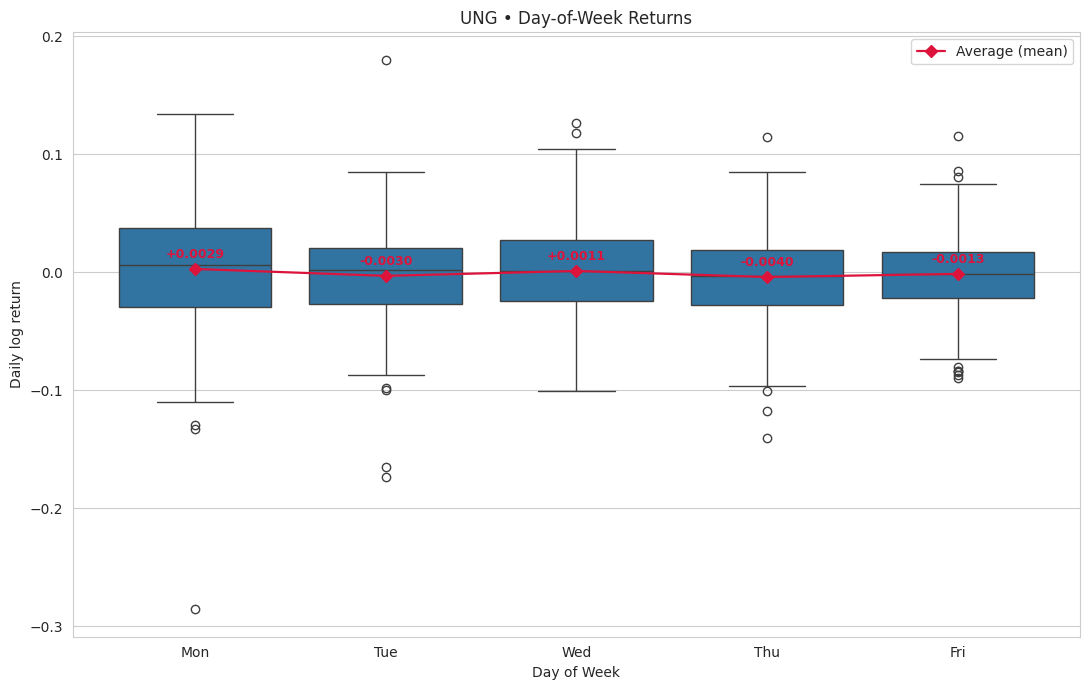

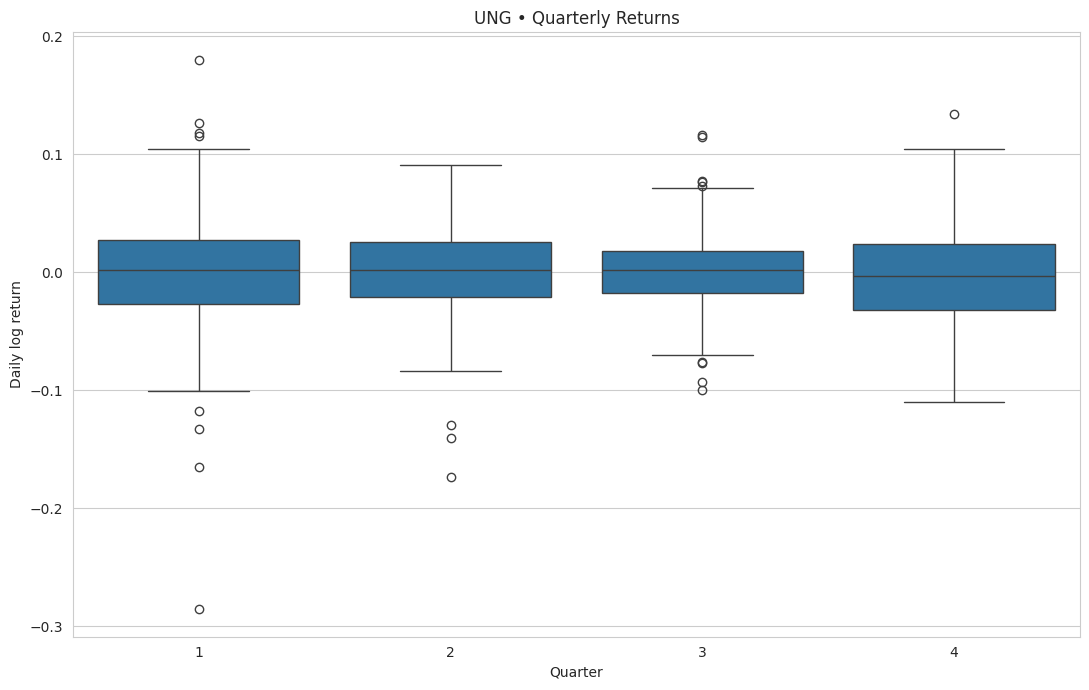

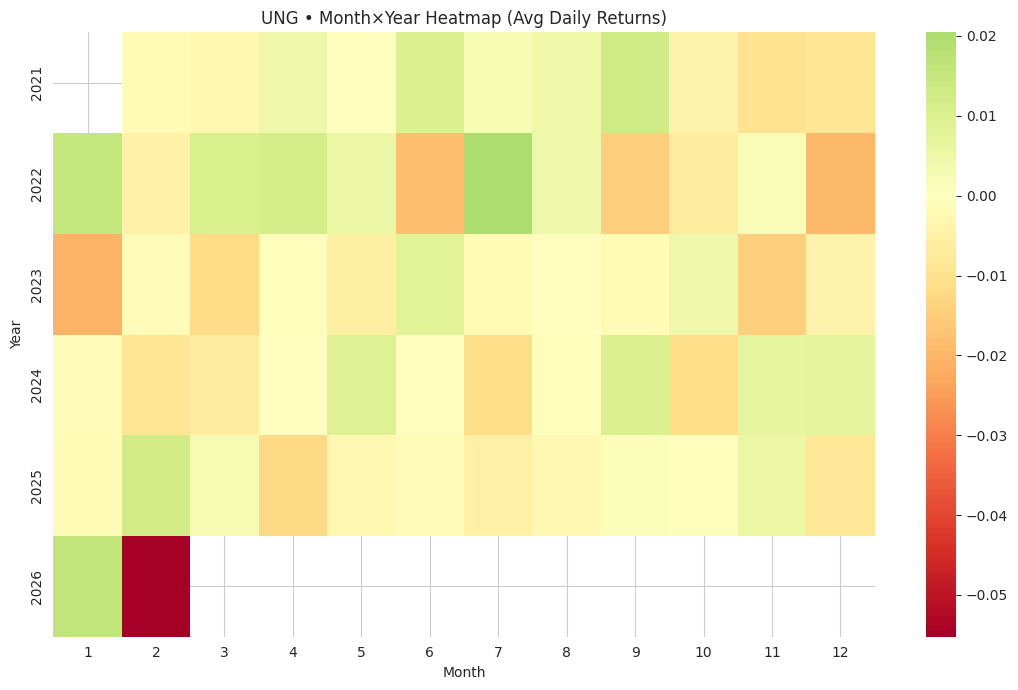

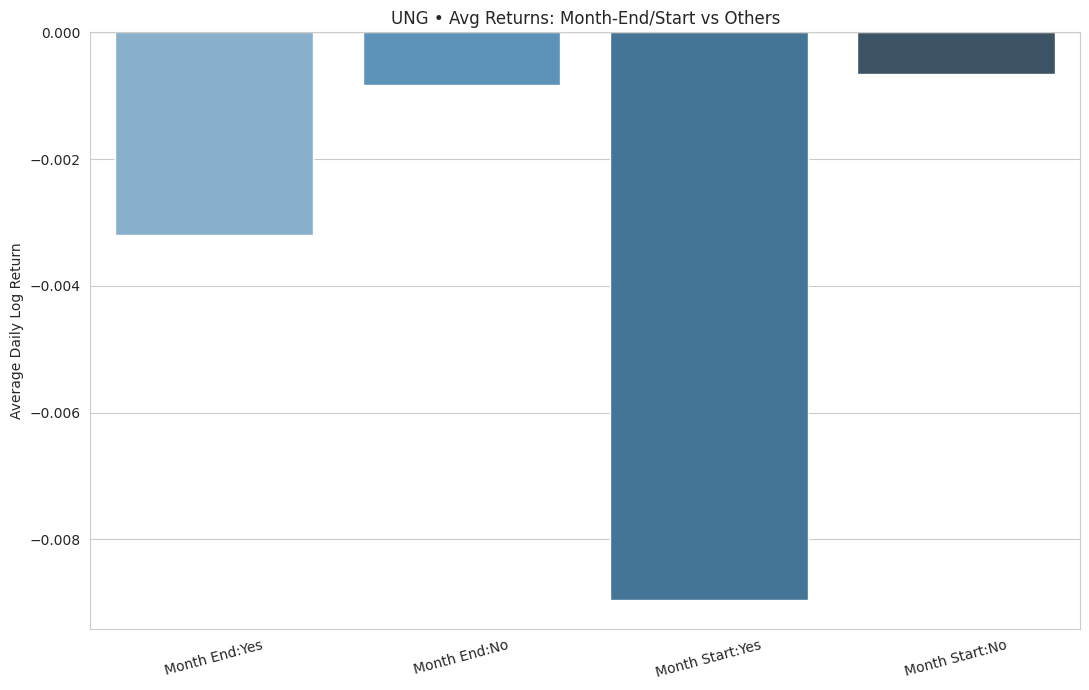

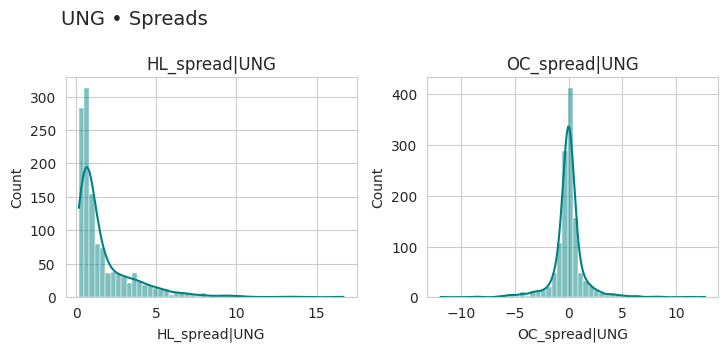

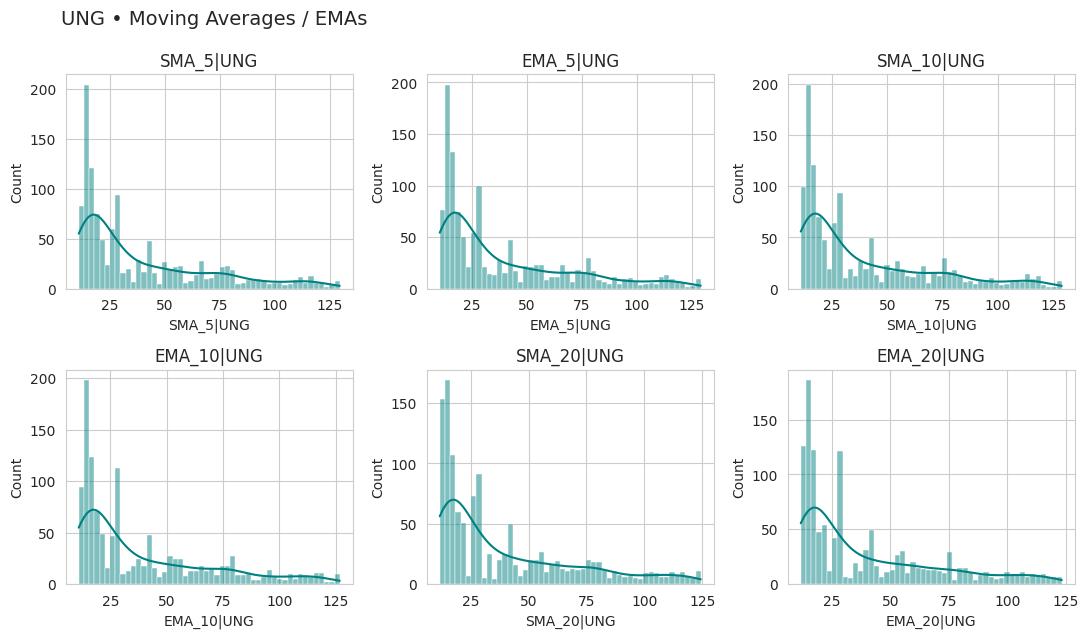

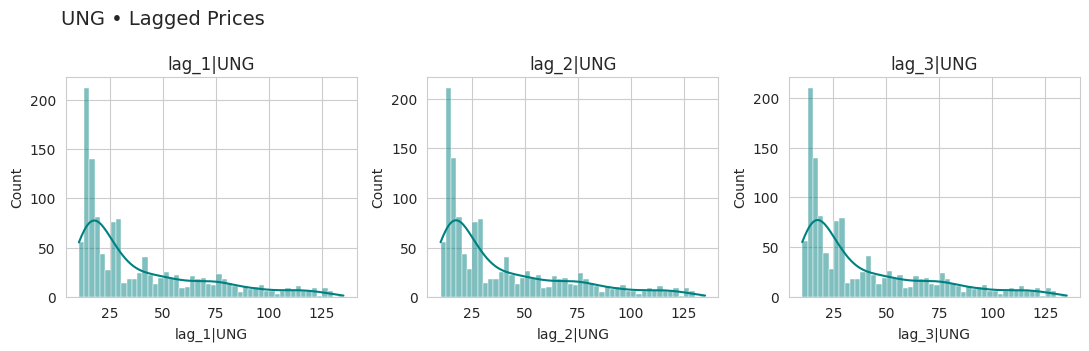

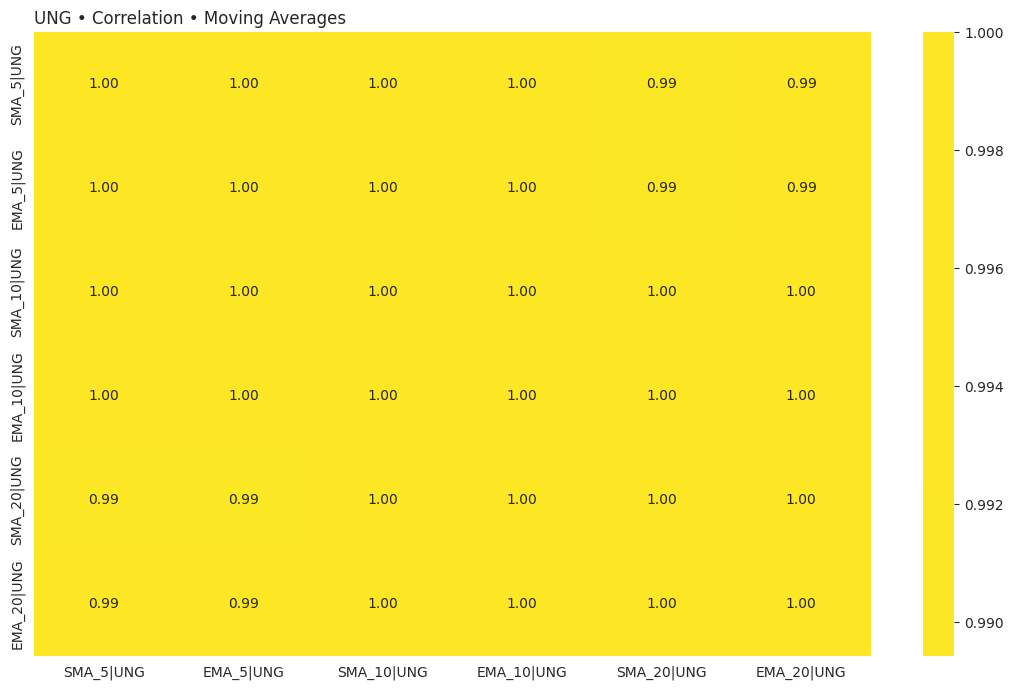

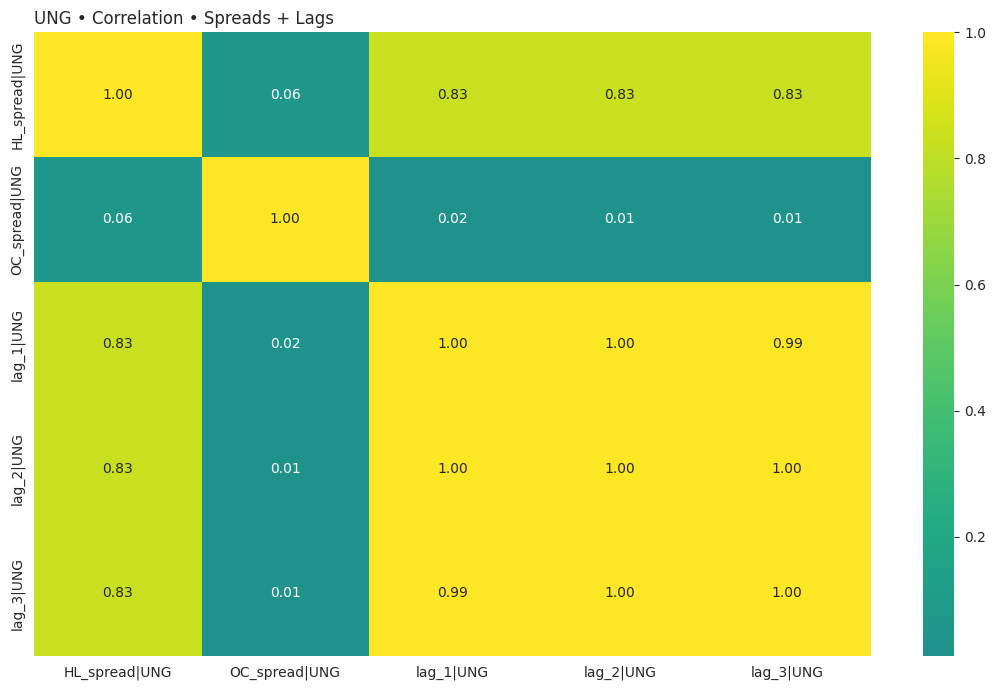

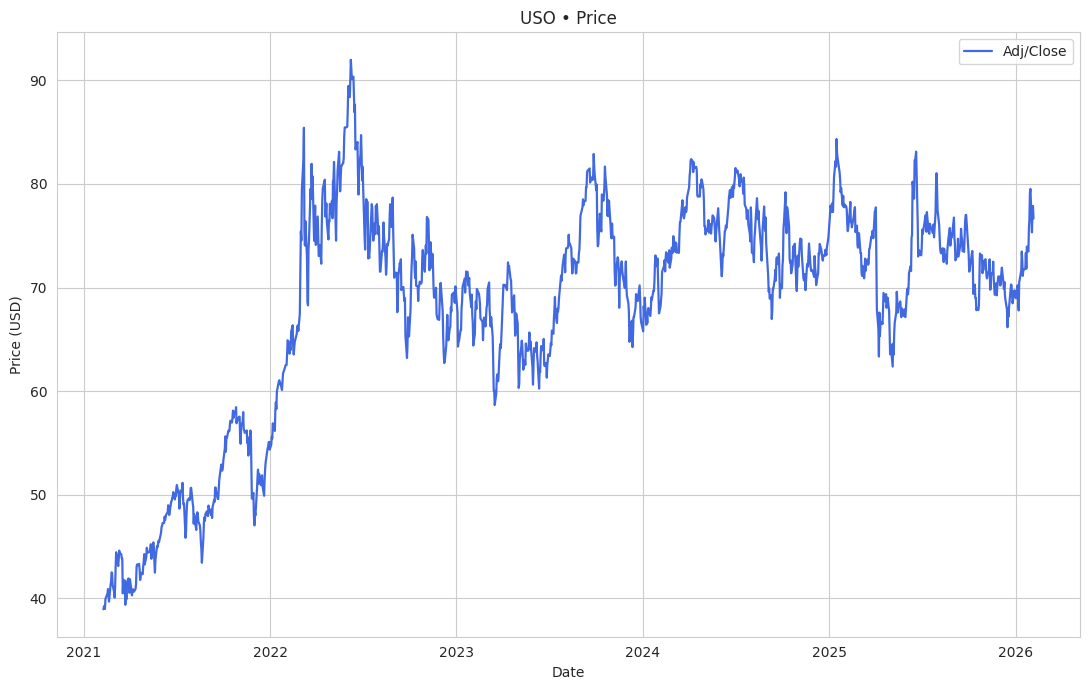

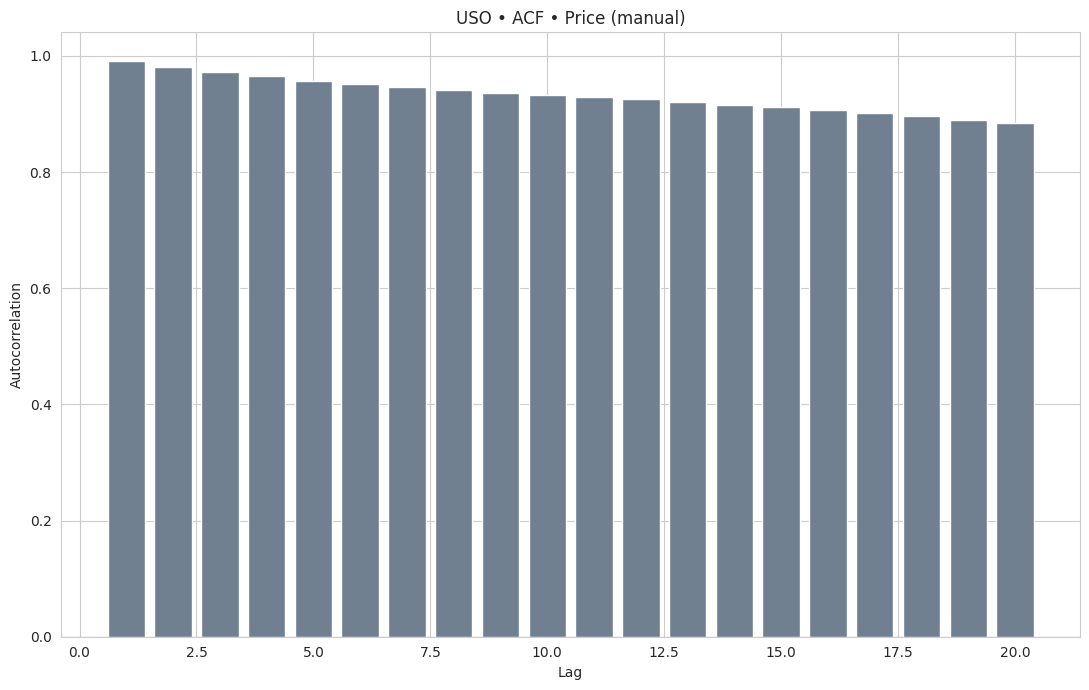

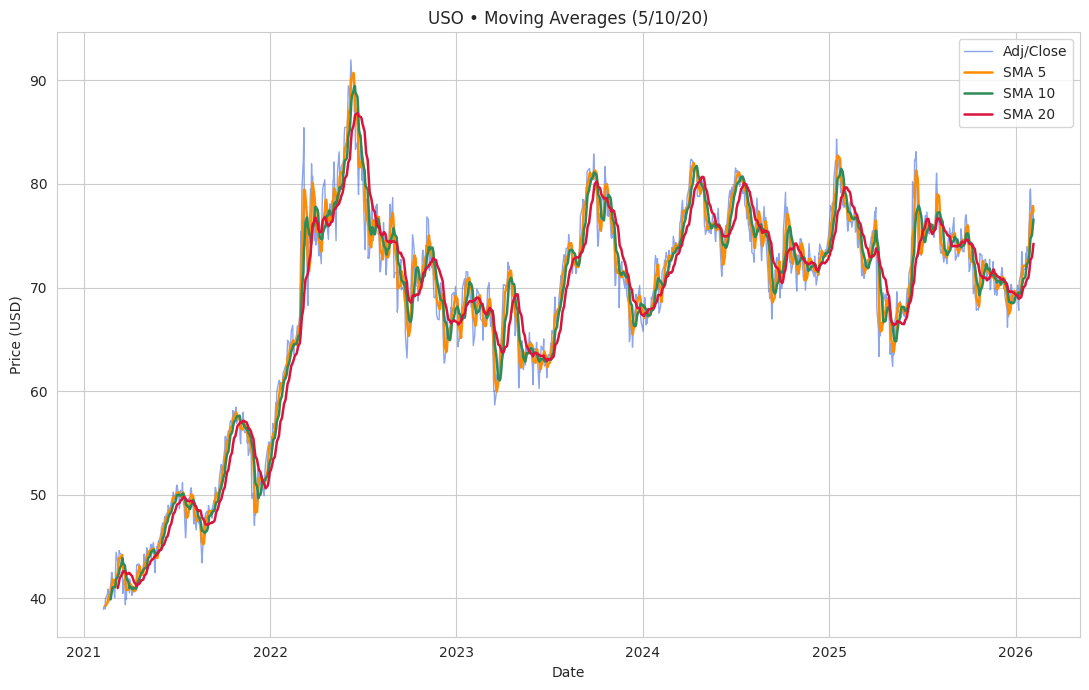

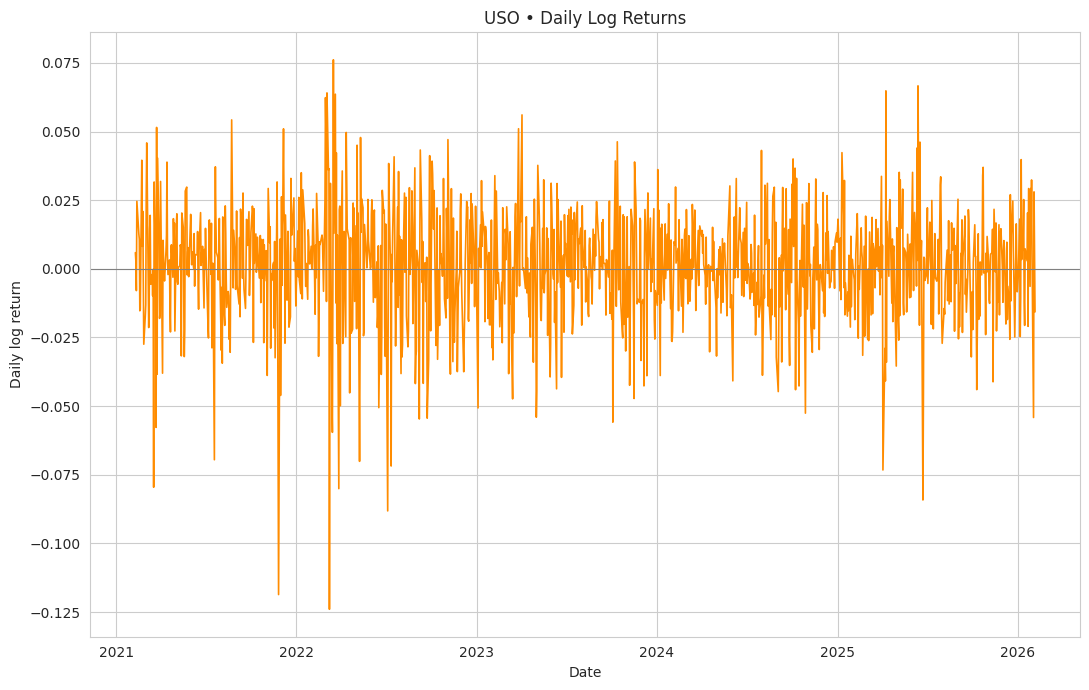

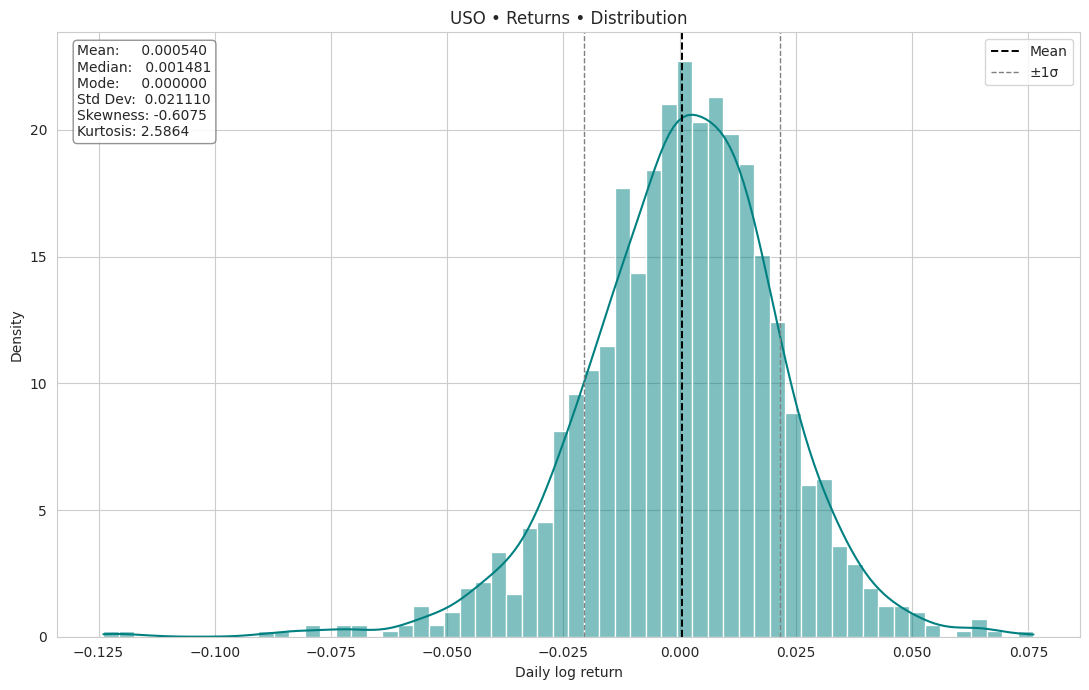

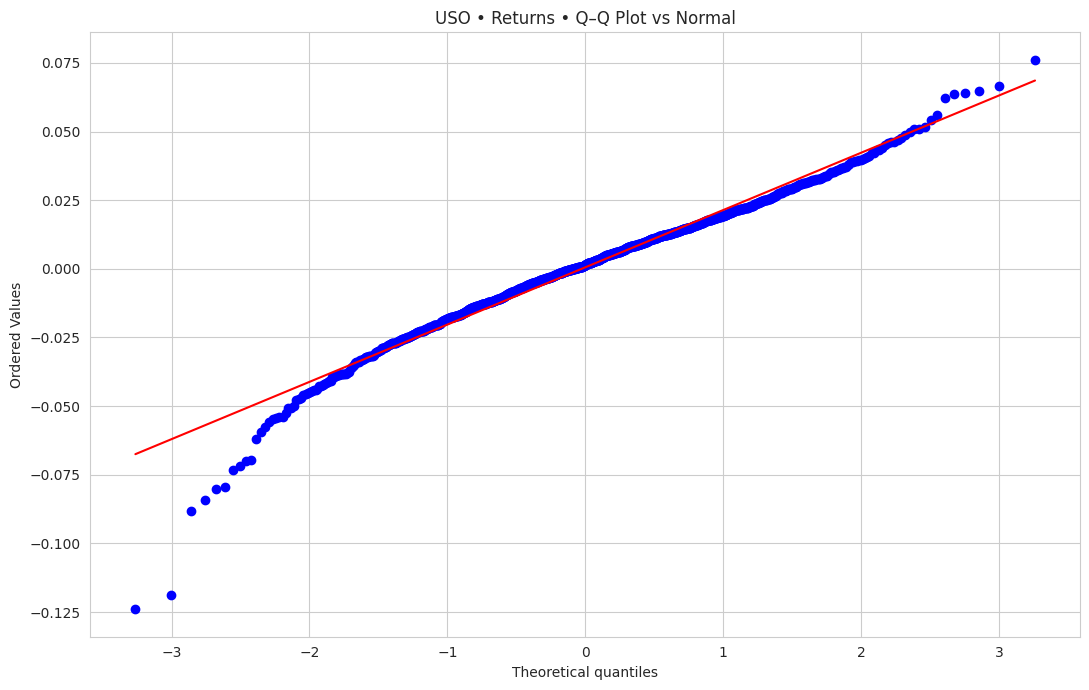

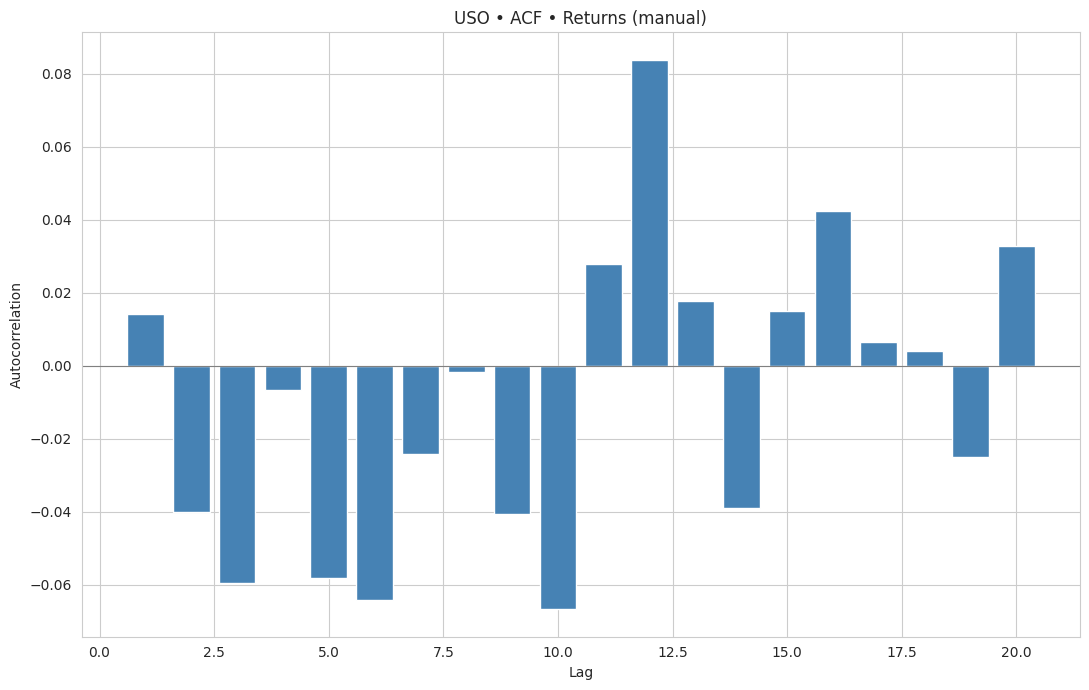

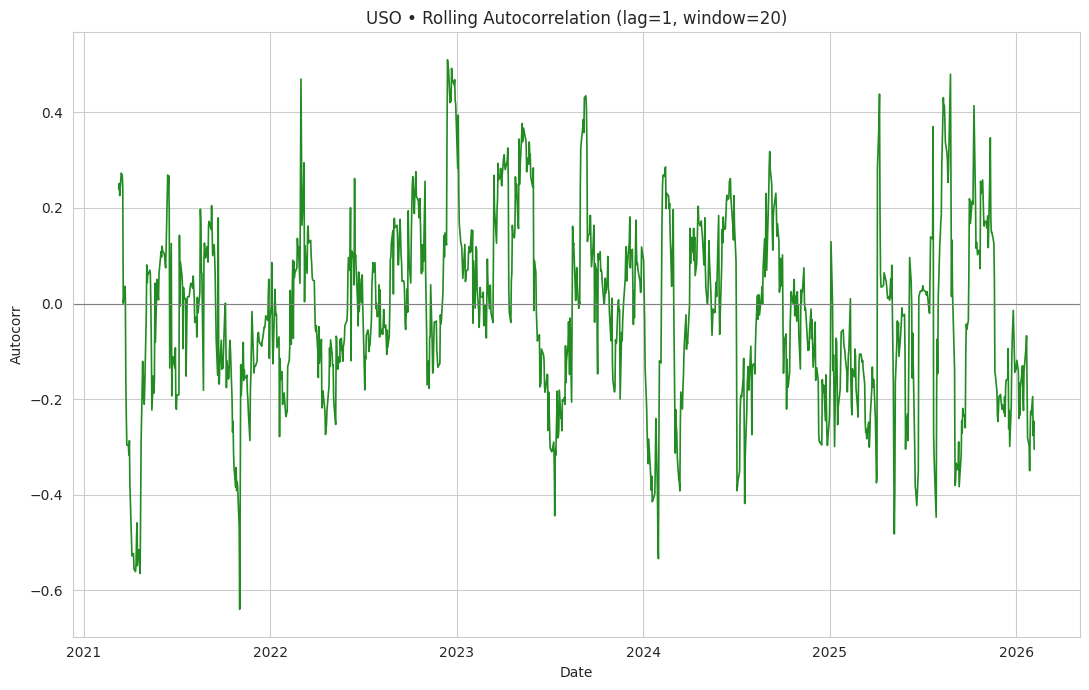

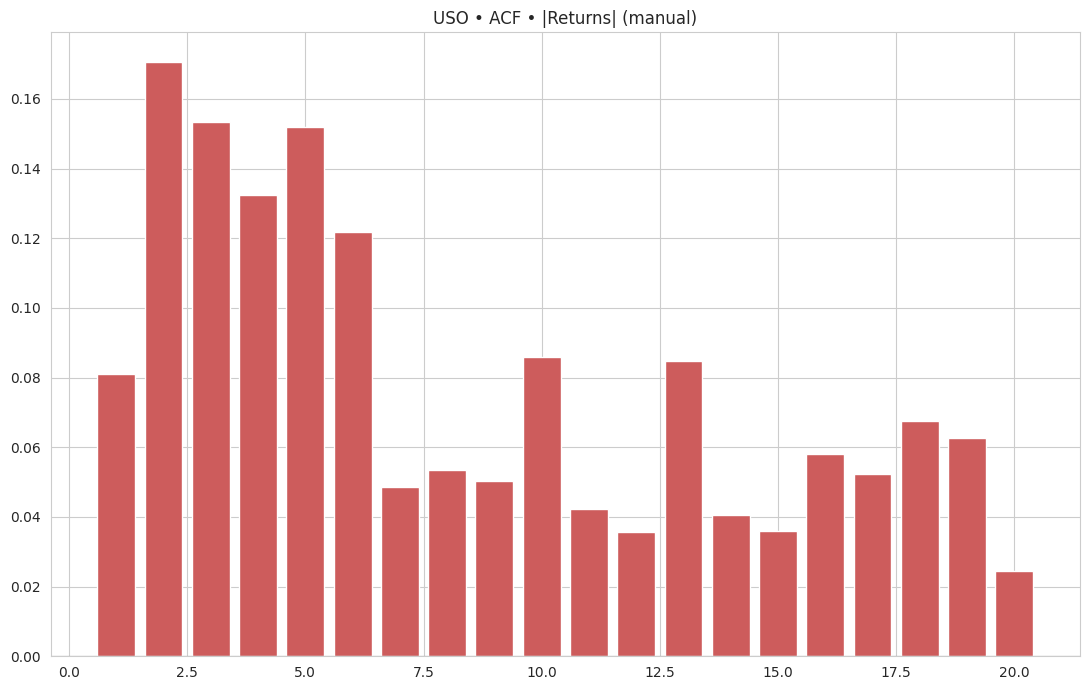

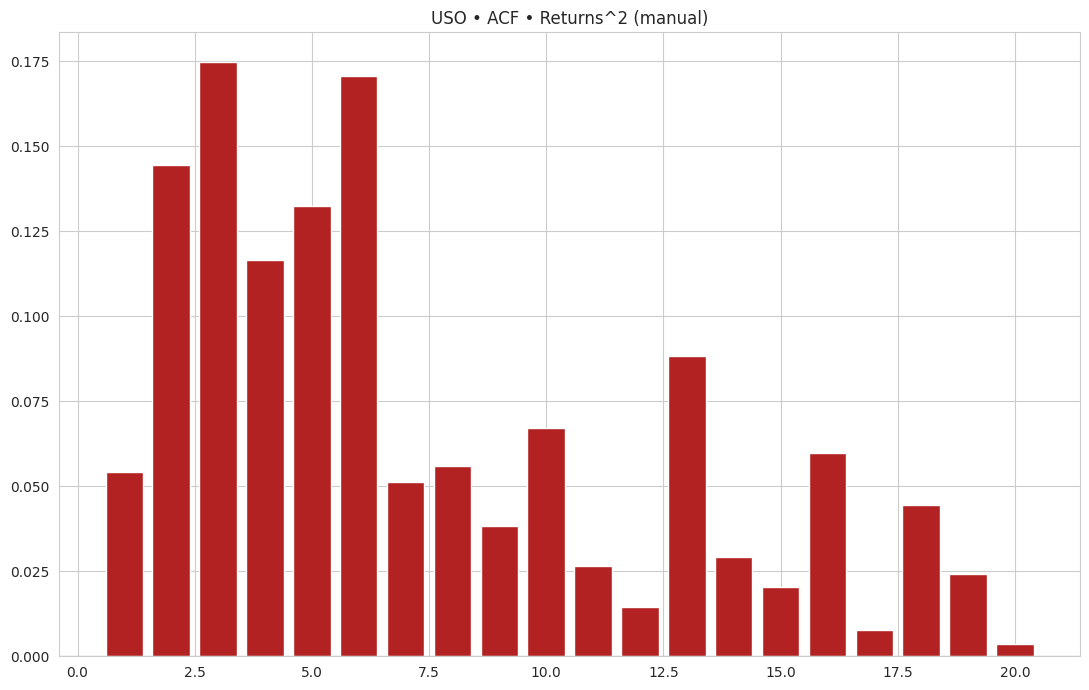

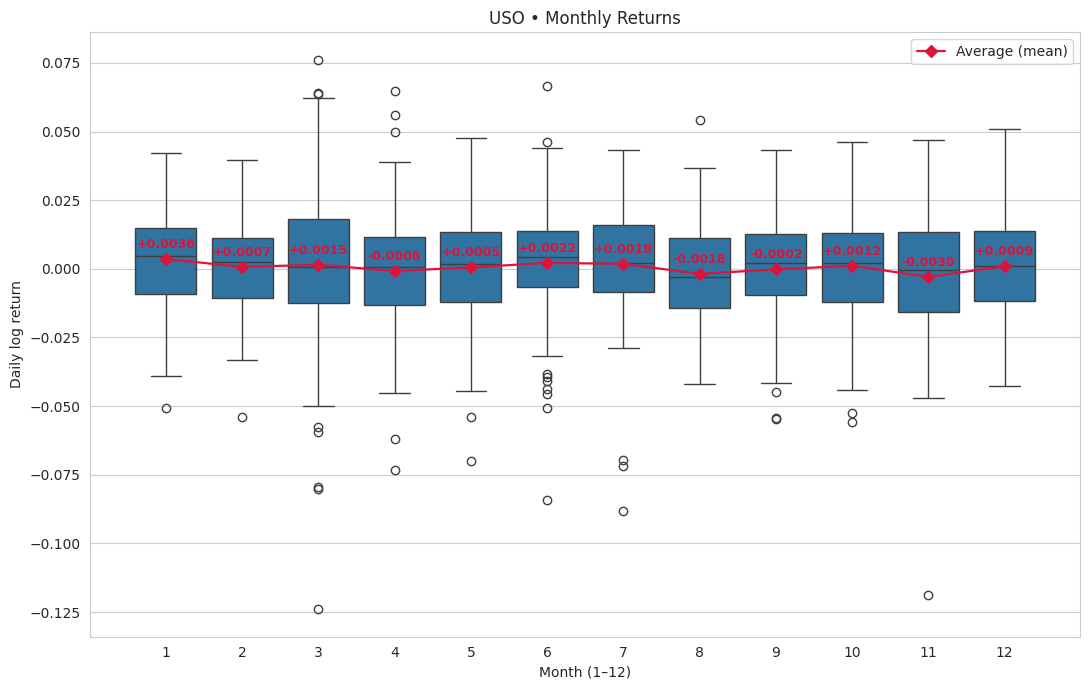

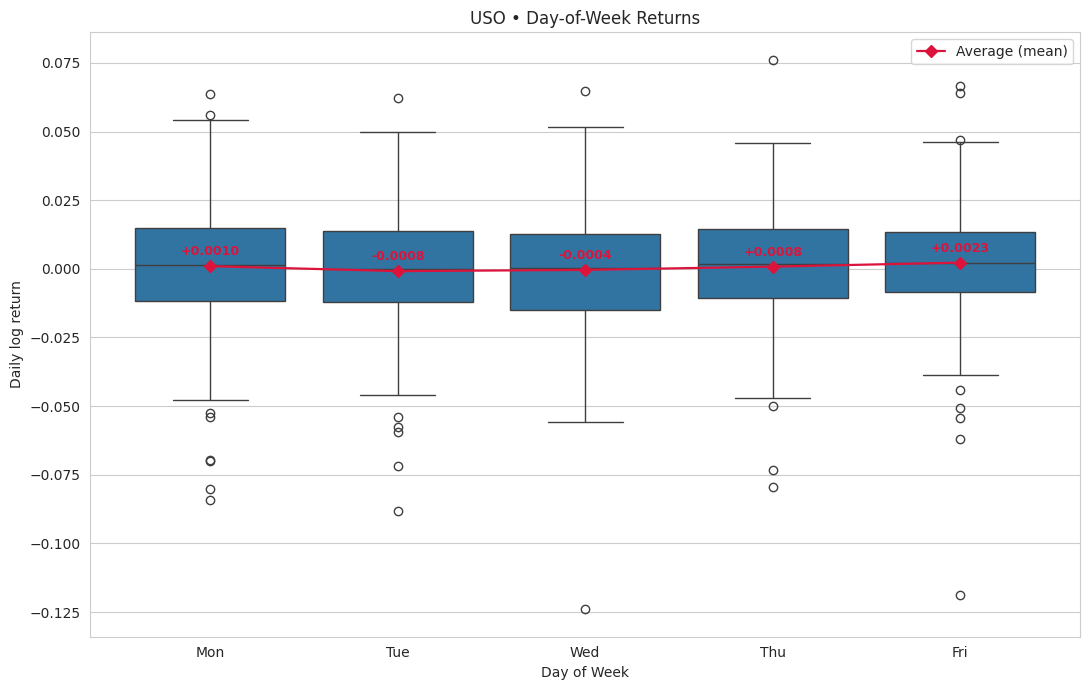

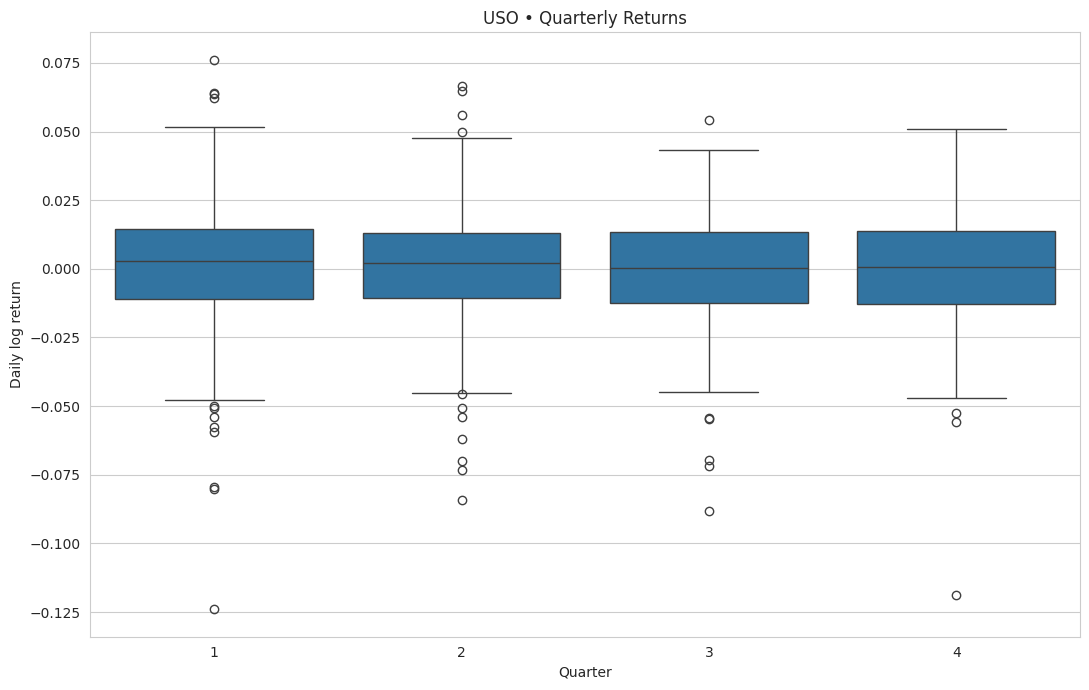

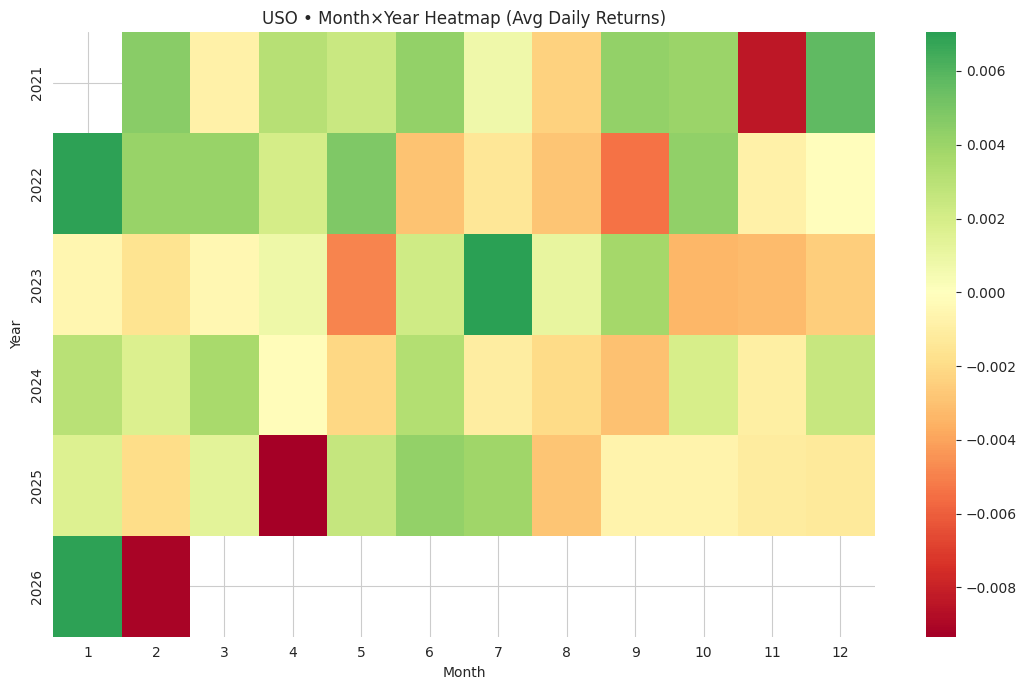

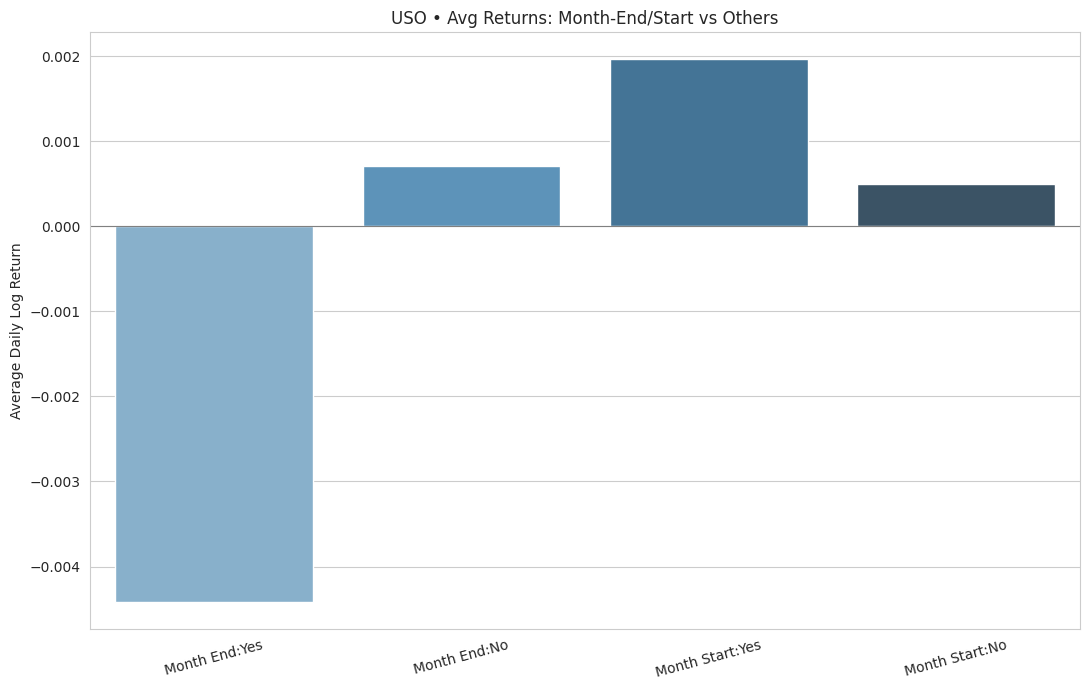

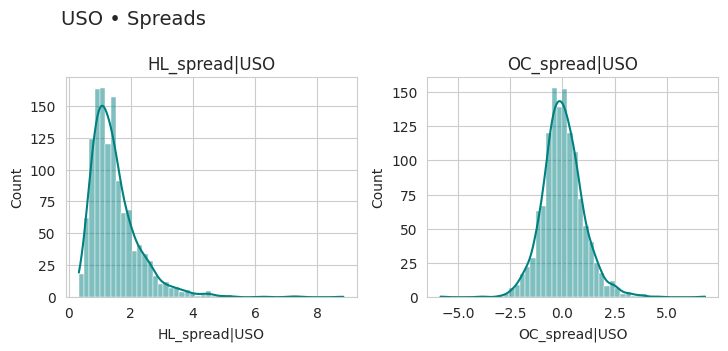

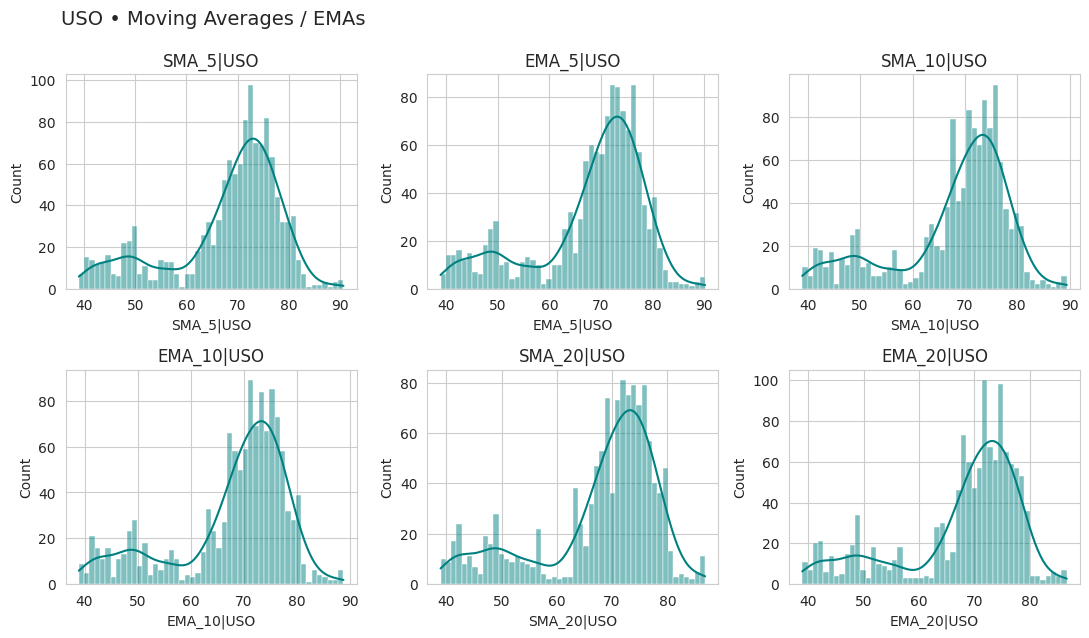

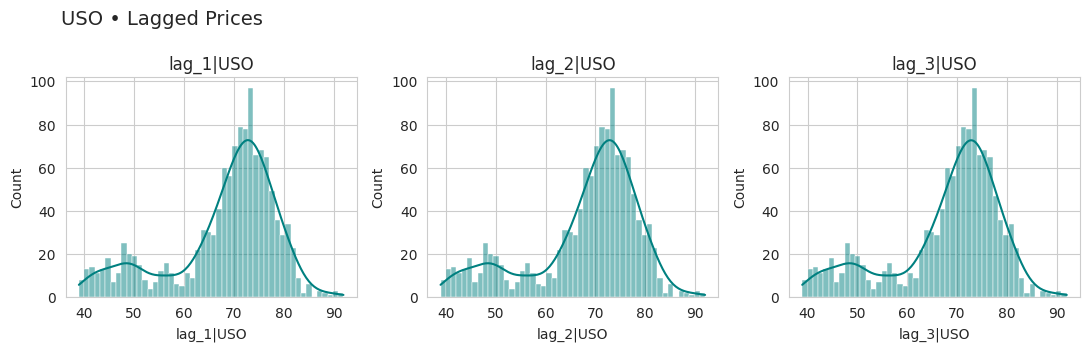

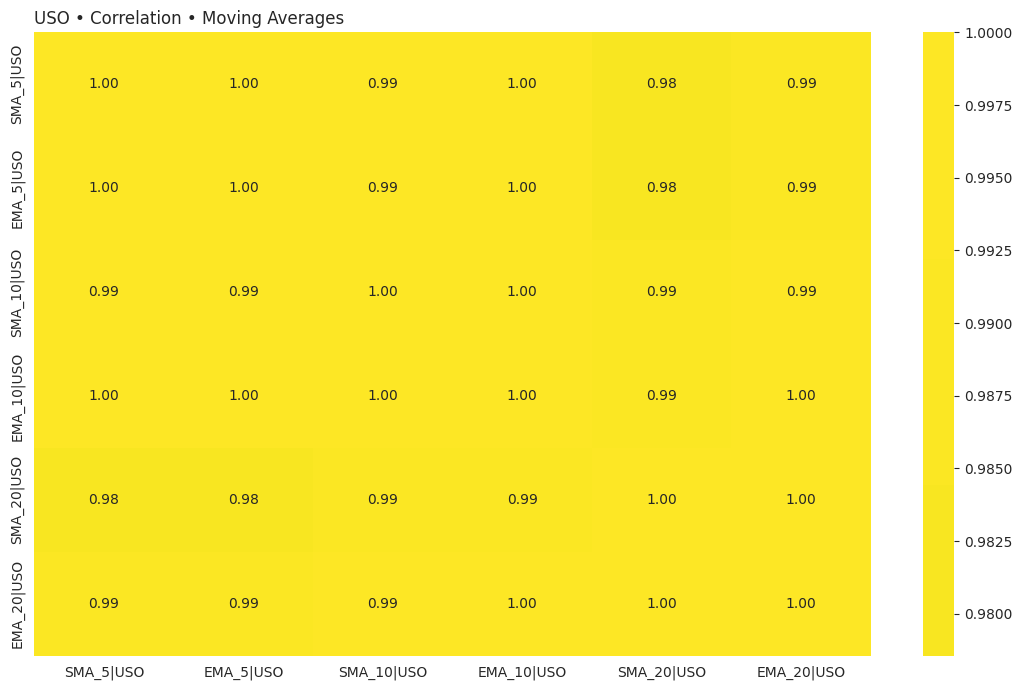

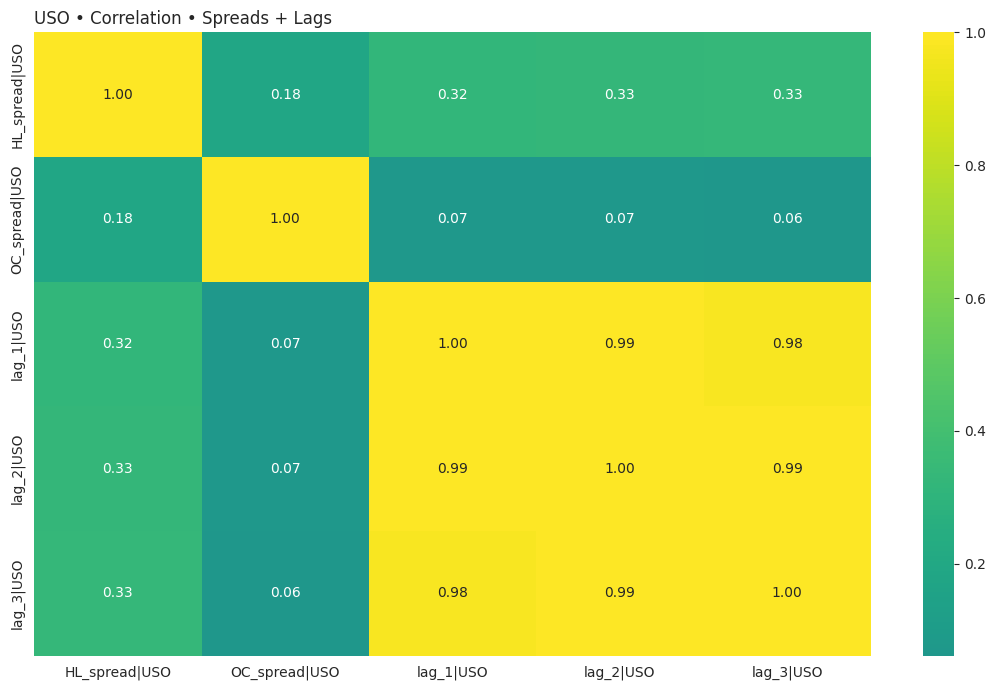

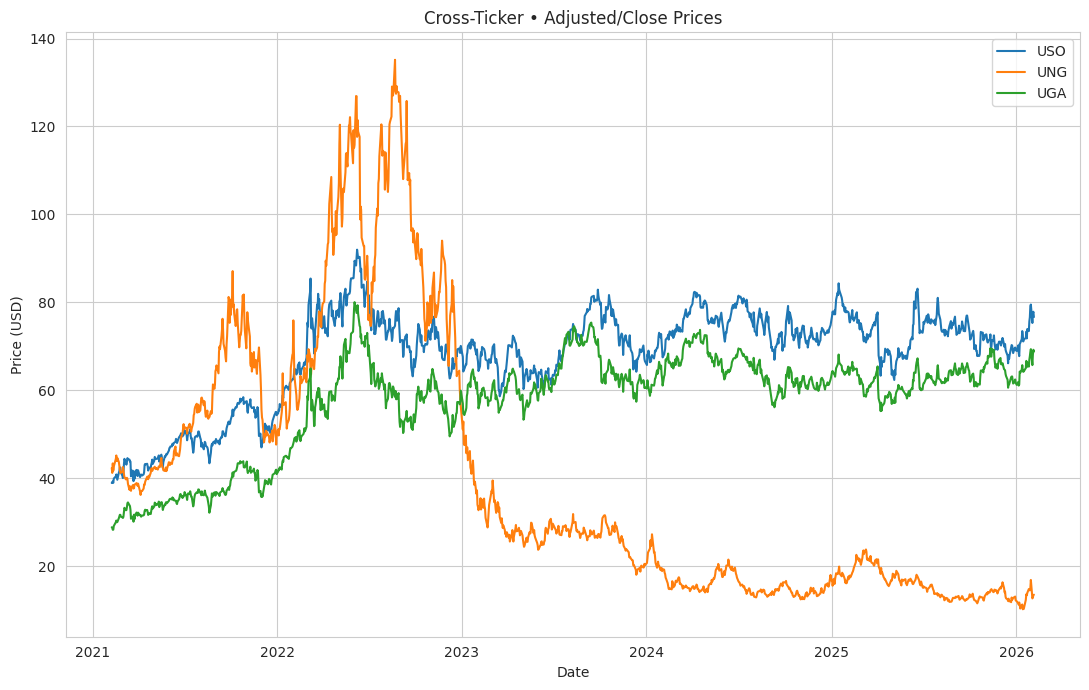

In [7]:
# -*- coding: utf-8 -*-
"""
ETF Plotting Suite — Stylized Facts & Seasonality (Single-Ticker Frames)

Updates:
- Seasonality is derived from the Date index (DatetimeIndex), not from columns.
- Returns histogram now shows Standard Deviation in the stats box and draws
  vertical guide lines at Mean and Mean ± 1σ.
- Monthly and Day-of-Week box plots now overlay the average (mean) value for
  each month/day and annotate those averages on the plot.

Usage:
    frames = {"USO": uso_df, "UNG": ung_df, "UGA": uga_df}
    build_energy_etf_report(frames, pdf_title="EDA energy ETF report.pdf", show_plots=True)
"""

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from typing import Dict, List, Optional
from scipy import stats

# ----------------------------
# Plot styling
# ----------------------------
plt.rcParams["figure.figsize"] = (11, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.autolayout"] = True
sns.set_style("whitegrid")

# ----------------------------
# Helpers
# ----------------------------
def _safe_title(name: str) -> str:
    return str(name).strip() if name else "Unknown"

def _table_figure_from_dataframe(df: pd.DataFrame, title: str, font_size: int = 9) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(11, min(7, 1 + 0.35 * (len(df) + 2))))
    ax.axis("off")
    ax.set_title(title, fontsize=14, pad=12, loc="left")
    tbl = ax.table(
        cellText=df.round(4).values.tolist(),
        colLabels=[str(c) for c in df.columns],
        loc="center",
        cellLoc="right",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(font_size)
    tbl.scale(1, 1.2)
    return fig

def _numeric_clean(series: pd.Series) -> pd.Series:
    """Coerce to numeric and drop NaNs."""
    return pd.to_numeric(series, errors="coerce").dropna()

def _adj_or_close_col(df: pd.DataFrame, ticker: str) -> Optional[str]:
    """Prefer 'Adj Close|TICKER', otherwise 'Close|TICKER' (case-insensitive fallback)."""
    for c in (f"Adj Close|{ticker}", f"Close|{ticker}"):
        if c in df.columns:
            return c
    low = {str(c).lower(): c for c in df.columns}
    key = f"close|{ticker}".lower()
    return low.get(key, None)

# ----------------------------
# Detect engineered feature columns
# ----------------------------
def _feature_cols_for_ticker(df: pd.DataFrame, ticker: str) -> Dict[str, List[str]]:
    spreads_pat = re.compile(rf'^(HL_spread|OC_spread)\|{ticker}$')
    ma_pat = re.compile(rf'^(SMA_\d+|EMA_\d+)\|{ticker}$')
    lag_pat = re.compile(rf'^lag_\d+\|{ticker}$')

    spreads = [c for c in df.columns if spreads_pat.match(str(c))]
    ma = [c for c in df.columns if ma_pat.match(str(c))]
    lags = [c for c in df.columns if lag_pat.match(str(c))]
    return {"spreads": spreads, "ma": ma, "lags": lags}

# ----------------------------
# Return series aggregator
# ----------------------------
def _get_return_series(df: pd.DataFrame, ticker: str) -> Optional[pd.Series]:
    """Returns daily log returns from engineered column or derives from price."""
    col = f"log_ret|{ticker}"
    if col in df.columns:
        s = _numeric_clean(df[col]).sort_index()
        return s if not s.empty else None
    price_col = _adj_or_close_col(df, ticker)
    if price_col:
        p = _numeric_clean(df[price_col]).sort_index()
        if not p.empty:
            return np.log(p / p.shift(1)).dropna()
    return None

# ----------------------------
# Core Plot Helpers (stylized facts)
# ----------------------------
def _plot_price_series(price: pd.Series, ticker: str) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.plot(price.index, price.values, label="Adj/Close", color="royalblue", lw=1.6)
    ax.set_title(f"{ticker} • Price")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (USD)")
    ax.legend(loc="best")
    return fig

def _plot_price_acf(price: pd.Series, ticker: str, max_lags: int = 20) -> plt.Figure:
    title = f"{ticker} • ACF • Price"
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig = plot_acf(price.dropna(), lags=max_lags)
        fig.axes[0].set_title(title)
        return fig
    except Exception:
        x = price.dropna()
        lags = list(range(1, max_lags + 1))
        values = [x.corr(x.shift(k)) for k in lags]
        fig, ax = plt.subplots()
        ax.bar(lags, values, color="slategray")
        ax.axhline(0, color="gray", lw=0.8)
        ax.set_title(f"{title} (manual)")
        ax.set_xlabel("Lag")
        ax.set_ylabel("Autocorrelation")
        return fig

def _plot_mas(price: pd.Series, ticker: str) -> plt.Figure:
    s = price.sort_index()
    ma_5  = s.rolling(window=5,  min_periods=5).mean()
    ma_10 = s.rolling(window=10, min_periods=10).mean()
    ma_20 = s.rolling(window=20, min_periods=20).mean()
    fig, ax = plt.subplots()
    ax.plot(s.index, s.values, color="royalblue", lw=1.0, alpha=0.6, label="Adj/Close")
    ax.plot(ma_5.index, ma_5.values, color="darkorange", lw=1.8, label="SMA 5")
    ax.plot(ma_10.index, ma_10.values, color="seagreen", lw=1.8, label="SMA 10")
    ax.plot(ma_20.index, ma_20.values, color="crimson", lw=1.8, label="SMA 20")
    ax.set_title(f"{ticker} • Moving Averages (5/10/20)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price (USD)")
    ax.legend(loc="best")
    return fig

def _plot_returns_ts(r: pd.Series, ticker: str) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.plot(r.index, r.values, color="darkorange", lw=1.2)
    ax.axhline(0.0, color="gray", lw=0.8)
    ax.set_title(f"{ticker} • Daily Log Returns")
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily log return")
    return fig

def _plot_returns_hist_qq(r: pd.Series, ticker: str) -> List[plt.Figure]:
    """Histogram + KDE with stats box (mean/median/mode/std/skew/kurt) and a Q–Q plot."""
    figs: List[plt.Figure] = []

    # Histogram + KDE + stats box
    fig_hist, ax_hist = plt.subplots()
    sns.histplot(r, bins=60, kde=True, stat="density", color="teal", ax=ax_hist)
    ax_hist.set_title(f"{ticker} • Returns • Distribution")
    ax_hist.set_xlabel("Daily log return")
    ax_hist.set_ylabel("Density")

    r_clean = _numeric_clean(r)
    mean  = float(r_clean.mean()) if len(r_clean) else np.nan
    median = float(r_clean.median()) if len(r_clean) else np.nan
    mode_series = r_clean.mode()
    mode_val = float(mode_series.iloc[0]) if not mode_series.empty else np.nan
    std   = float(r_clean.std(ddof=1)) if len(r_clean) else np.nan
    skew  = float(stats.skew(r_clean, bias=False, nan_policy="omit")) if len(r_clean) else np.nan
    kurt  = float(stats.kurtosis(r_clean, fisher=True, bias=False, nan_policy="omit")) if len(r_clean) else np.nan

    stats_text = "\n".join([
        f"Mean:     {mean:.6f}"   if not np.isnan(mean) else "Mean:     n/a",
        f"Median:   {median:.6f}" if not np.isnan(median) else "Median:   n/a",
        f"Mode:     {mode_val:.6f}" if not np.isnan(mode_val) else "Mode:     n/a",
        f"Std Dev:  {std:.6f}"    if not np.isnan(std) else "Std Dev:  n/a",
        f"Skewness: {skew:.4f}"   if not np.isnan(skew) else "Skewness: n/a",
        f"Kurtosis: {kurt:.4f}"   if not np.isnan(kurt) else "Kurtosis: n/a",
    ])
    ax_hist.text(
        0.02, 0.98, stats_text,
        transform=ax_hist.transAxes,
        fontsize=10,
        va="top", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="gray")
    )

    # Add guide lines for mean and ±1σ
    if not np.isnan(mean):
        ax_hist.axvline(mean, color="black", lw=1.4, linestyle="--", label="Mean")
    if not (np.isnan(mean) or np.isnan(std)):
        ax_hist.axvline(mean - std, color="gray", lw=1.0, linestyle="--", label="±1σ")
        ax_hist.axvline(mean + std, color="gray", lw=1.0, linestyle="--")
        # Avoid duplicate legend entries
        handles, labels = ax_hist.get_legend_handles_labels()
        if labels:
            ax_hist.legend(loc="best", frameon=True)

    figs.append(fig_hist)

    # Q–Q plot
    fig_qq, ax_qq = plt.subplots()
    stats.probplot(r_clean, dist="norm", plot=ax_qq)
    ax_qq.set_title(f"{ticker} • Returns • Q–Q Plot vs Normal")
    figs.append(fig_qq)

    return figs

def _plot_returns_acf(r: pd.Series, ticker: str, max_lags: int = 20) -> plt.Figure:
    title = f"{ticker} • ACF • Returns"
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig = plot_acf(r.dropna(), lags=max_lags)
        fig.axes[0].set_title(title)
        return fig
    except Exception:
        fig, ax = plt.subplots()
        lags = list(range(1, max_lags + 1))
        values = [r.corr(r.shift(k)) for k in lags]
        ax.bar(lags, values, color="steelblue")
        ax.axhline(0, color="gray", lw=0.8)
        ax.set_title(f"{title} (manual)")
        ax.set_xlabel("Lag")
        ax.set_ylabel("Autocorrelation")
        return fig

def _plot_rolling_autocorr(r: pd.Series, ticker: str, lag: int = 1, window: int = 20) -> plt.Figure:
    df_tmp = pd.DataFrame({"r": r}).dropna()
    df_tmp[f"r_lag_{lag}"] = df_tmp["r"].shift(lag)
    roll = df_tmp["r"].rolling(window).corr(df_tmp[f"r_lag_{lag}"])
    fig, ax = plt.subplots()
    ax.plot(roll.index, roll.values, color="forestgreen", lw=1.2)
    ax.axhline(0, color="gray", lw=0.8)
    ax.set_title(f"{ticker} • Rolling Autocorrelation (lag={lag}, window={window})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Autocorr")
    return fig

def _plot_vol_clustering(r: pd.Series, ticker: str, max_lags: int = 20) -> List[plt.Figure]:
    """ACF of |r| and r^2 to reveal volatility clustering."""
    figs: List[plt.Figure] = []
    abs_r = r.abs()
    sq_r  = r.pow(2)

    # ACF |r|
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig1 = plot_acf(abs_r.dropna(), lags=max_lags)
        fig1.axes[0].set_title(f"{ticker} • ACF • |Returns| (Volatility Clustering)")
        figs.append(fig1)
    except Exception:
        lags = list(range(1, max_lags + 1))
        values = [abs_r.corr(abs_r.shift(k)) for k in lags]
        fig1, ax1 = plt.subplots()
        ax1.bar(lags, values, color="indianred")
        ax1.axhline(0, color="gray", lw=0.8)
        ax1.set_title(f"{ticker} • ACF • |Returns| (manual)")
        figs.append(fig1)

    # ACF r^2
    try:
        from statsmodels.graphics.tsaplots import plot_acf
        fig2 = plot_acf(sq_r.dropna(), lags=max_lags)
        fig2.axes[0].set_title(f"{ticker} • ACF • Returns^2 (Volatility Clustering)")
        figs.append(fig2)
    except Exception:
        lags = list(range(1, max_lags + 1))
        values = [sq_r.corr(sq_r.shift(k)) for k in lags]
        fig2, ax2 = plt.subplots()
        ax2.bar(lags, values, color="firebrick")
        ax2.axhline(0, color="gray", lw=0.8)
        ax2.set_title(f"{ticker} • ACF • Returns^2 (manual)")
        figs.append(fig2)

    return figs

# ----------------------------
# Seasonality (derived from Date index)
# ----------------------------
def _seasonal_df_from_index(index_like: pd.Index) -> Optional[pd.DataFrame]:
    """Build seasonal fields from a Date-like index. Returns None if cannot coerce."""
    dt = pd.to_datetime(index_like, errors="coerce")
    if dt.isna().all():
        return None
    dt = pd.DatetimeIndex(dt)
    out = pd.DataFrame(
        {
            "month": dt.month,
            "day_of_week": dt.dayofweek,  # 0=Mon .. 6=Sun
            "quarter": dt.quarter,
            "year": dt.year,
            "is_month_end": dt.is_month_end.astype(int),
            "is_month_start": dt.is_month_start.astype(int),
        },
        index=index_like,
    )
    return out

def _plot_monthly_box_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season["month"]], axis=1).dropna(subset=["ret"])
    d["month"] = pd.to_numeric(d["month"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["month"])
    if d.empty:
        return None

    order = list(range(1, 13))
    fig, ax = plt.subplots()
    sns.boxplot(data=d, x="month", y="ret", ax=ax, order=order)
    ax.set_title(f"{ticker} • Monthly Returns")
    ax.set_xlabel("Month (1–12)")
    ax.set_ylabel("Daily log return")

    # ---- Overlay: Average (mean) by month + annotate values ----
    grp = d.groupby("month")["ret"].mean()
    # Use axis tick positions to align precisely with seaborn categorical placement
    x_positions = ax.get_xticks()  # typically 0..11
    means_in_order = [float(grp.get(m, np.nan)) for m in order]

    ax.plot(
        x_positions, means_in_order,
        color="crimson", marker="D", lw=1.6, label="Average (mean)", zorder=5
    )

    for x, y in zip(x_positions, means_in_order):
        if not (np.isnan(y) or np.isinf(y)):
            ax.annotate(
                f"{y:+.4f}", (x, y),
                textcoords="offset points", xytext=(0, 8),
                ha="center", fontsize=9, color="crimson", fontweight="bold"
            )

    # Add legend to expose the mean overlay
    handles, labels = ax.get_legend_handles_labels()
    if "Average (mean)" in labels:
        ax.legend(loc="best", frameon=True)

    return fig

def _plot_dow_box_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season["day_of_week"]], axis=1).dropna(subset=["ret"])
    d["day_of_week"] = pd.to_numeric(d["day_of_week"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["day_of_week"])
    if d.empty:
        return None

    labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    order = list(range(0, 7))
    fig, ax = plt.subplots()
    sns.boxplot(data=d, x="day_of_week", y="ret", ax=ax, order=order)
    ax.set_title(f"{ticker} • Day-of-Week Returns")
    ax.set_xlabel("Day of Week")
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Daily log return")

    # ---- Overlay: Average (mean) by day-of-week + annotate values ----
    grp = d.groupby("day_of_week")["ret"].mean()
    x_positions = ax.get_xticks()  # typically 0..6
    means_in_order = [float(grp.get(i, np.nan)) for i in order]

    ax.plot(
        x_positions, means_in_order,
        color="crimson", marker="D", lw=1.6, label="Average (mean)", zorder=5
    )

    for x, y in zip(x_positions, means_in_order):
        if not (np.isnan(y) or np.isinf(y)):
            ax.annotate(
                f"{y:+.4f}", (x, y),
                textcoords="offset points", xytext=(0, 8),
                ha="center", fontsize=9, color="crimson", fontweight="bold"
            )

    handles, labels_ = ax.get_legend_handles_labels()
    if "Average (mean)" in labels_:
        ax.legend(loc="best", frameon=True)

    return fig

def _plot_quarter_box_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season["quarter"]], axis=1).dropna(subset=["ret"])
    d["quarter"] = pd.to_numeric(d["quarter"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["quarter"])
    if d.empty:
        return None
    fig, ax = plt.subplots()
    sns.boxplot(data=d, x="quarter", y="ret", ax=ax, order=[1,2,3,4])
    ax.set_title(f"{ticker} • Quarterly Returns")
    ax.set_xlabel("Quarter")
    ax.set_ylabel("Daily log return")
    return fig

def _plot_month_year_heatmap_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season[["month","year"]]], axis=1).dropna(subset=["ret"])
    d["month"] = pd.to_numeric(d["month"], errors="coerce").astype("Int64")
    d["year"]  = pd.to_numeric(d["year"],  errors="coerce").astype("Int64")
    d = d.dropna(subset=["month","year"])
    if d.empty:
        return None
    piv = d.pivot_table(index="year", columns="month", values="ret", aggfunc="mean").sort_index()
    piv = piv.reindex(columns=list(range(1,13)))
    fig, ax = plt.subplots()
    sns.heatmap(piv, cmap="RdYlGn", center=0, annot=False, ax=ax)
    ax.set_title(f"{ticker} • Month×Year Heatmap (Avg Daily Returns)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Year")
    return fig

def _plot_month_end_start_bars_from_index(r: pd.Series, ticker: str) -> Optional[plt.Figure]:
    season = _seasonal_df_from_index(r.index)
    if season is None:
        return None
    d = pd.concat([r.rename("ret"), season[["is_month_end","is_month_start"]]], axis=1).dropna(subset=["ret"])
    # Already 0/1 ints from builder; ensure clean numerics
    d["is_month_end"] = pd.to_numeric(d["is_month_end"], errors="coerce").astype("Int64")
    d["is_month_start"] = pd.to_numeric(d["is_month_start"], errors="coerce").astype("Int64")
    d = d.dropna(subset=["is_month_end","is_month_start"])
    if d.empty:
        return None

    rows = []
    for col, label in [("is_month_end","Month End"), ("is_month_start","Month Start")]:
        grp = d.groupby(col)["ret"].mean()
        mean_yes = float(grp.get(1, np.nan))
        mean_no  = float(grp.get(0, np.nan))
        rows.append({"Group": f"{label}:Yes", "AvgRet": mean_yes})
        rows.append({"Group": f"{label}:No",  "AvgRet": mean_no})
    res = pd.DataFrame(rows)

    fig, ax = plt.subplots()
    sns.barplot(data=res, x="Group", y="AvgRet", palette="Blues_d", ax=ax)
    ax.axhline(0, color="gray", lw=0.8)
    ax.set_title(f"{ticker} • Avg Returns: Month-End/Start vs Others")
    ax.set_xlabel("")
    ax.set_ylabel("Average Daily Log Return")
    ax.tick_params(axis="x", rotation=15)
    return fig

# ----------------------------
# Engineered Feature Visuals
# ----------------------------
def _plot_feature_distributions(df: pd.DataFrame, cols: List[str], title_prefix: str, ticker: str) -> List[plt.Figure]:
    figs: List[plt.Figure] = []
    cols_num = [c for c in cols if c in df.columns and _numeric_clean(df[c]).size > 0]
    if not cols_num:
        return figs
    chunk_size = 6
    for i in range(0, len(cols_num), chunk_size):
        batch = cols_num[i:i + chunk_size]
        rows = int(np.ceil(len(batch) / 3))
        fig, axes = plt.subplots(rows, 3, figsize=(11, max(3.5, 3.2 * rows)))
        axes = np.array(axes).reshape(-1)
        for j, c in enumerate(batch):
            s = _numeric_clean(df[c])
            sns.histplot(s, bins=50, kde=True, ax=axes[j], color="teal")
            axes[j].set_title(c)
        for k in range(len(batch), len(axes)):
            fig.delaxes(axes[k])
        fig.suptitle(f"{ticker} • {title_prefix}", x=0.06, y=0.99, ha="left", fontsize=14)
        figs.append(fig)
    return figs

def _plot_feature_corr(df: pd.DataFrame, cols: List[str], title: str, ticker: str) -> Optional[plt.Figure]:
    cols_num = [c for c in cols if c in df.columns and _numeric_clean(df[c]).size > 0]
    if len(cols_num) < 2:
        return None
    data = df[cols_num].apply(pd.to_numeric, errors="coerce")
    corr = data.corr()
    fig, ax = plt.subplots()
    sns.heatmap(corr, cmap="viridis", center=0, annot=True, fmt=".2f", ax=ax)
    ax.set_title(f"{ticker} • {title}", loc="left")
    return fig

# ----------------------------
# Per-ticker report
# ----------------------------
def eda_single_ticker(name: str, df: pd.DataFrame) -> List[plt.Figure]:
    figs: List[plt.Figure] = []
    ticker = _safe_title(name)
    df = df.copy().sort_index()

    # Price series
    price_col = _adj_or_close_col(df, ticker)
    if price_col:
        price = _numeric_clean(df[price_col])
        if not price.empty:
            figs.append(_plot_price_series(price, ticker))
            figs.append(_plot_price_acf(price, ticker, max_lags=20))
            figs.append(_plot_mas(price, ticker))
    else:
        info_df = pd.DataFrame({"Message": [f"No Adj/Close column found for {ticker}."]})
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Price Not Available"))

    # Returns-driven stylized facts
    r = _get_return_series(df, ticker)
    if r is not None and not r.empty:
        figs.append(_plot_returns_ts(r, ticker))
        figs.extend(_plot_returns_hist_qq(r, ticker))  # <-- includes Std Dev & guide lines
        figs.append(_plot_returns_acf(r, ticker, max_lags=20))
        figs.append(_plot_rolling_autocorr(r, ticker, lag=1, window=20))
        figs.extend(_plot_vol_clustering(r, ticker, max_lags=20))

        # Seasonality — derived from the Date index of r
        fig_m = _plot_monthly_box_from_index(r, ticker);          figs.append(fig_m) if fig_m else None
        fig_d = _plot_dow_box_from_index(r, ticker);              figs.append(fig_d) if fig_d else None
        fig_q = _plot_quarter_box_from_index(r, ticker);          figs.append(fig_q) if fig_q else None
        fig_h = _plot_month_year_heatmap_from_index(r, ticker);   figs.append(fig_h) if fig_h else None
        fig_b = _plot_month_end_start_bars_from_index(r, ticker); figs.append(fig_b) if fig_b else None
    else:
        info_df = pd.DataFrame({"Message": [f"No return series found for {ticker}."]})
        figs.append(_table_figure_from_dataframe(info_df, f"{ticker} • Returns Not Available"))

    # Engineered feature plots
    feat = _feature_cols_for_ticker(df, ticker)
    figs.extend(_plot_feature_distributions(df, feat["spreads"], "Spreads", ticker))
    figs.extend(_plot_feature_distributions(df, feat["ma"], "Moving Averages / EMAs", ticker))
    figs.extend(_plot_feature_distributions(df, feat["lags"], "Lagged Prices", ticker))

    fm = _plot_feature_corr(df, feat["ma"], "Correlation • Moving Averages", ticker)
    if fm: figs.append(fm)
    fm2 = _plot_feature_corr(df, feat["spreads"] + feat["lags"], "Correlation • Spreads + Lags", ticker)
    if fm2: figs.append(fm2)

    return figs

# ----------------------------
# Cross-ticker overlay (Adj/Close)
# ----------------------------
def eda_cross_ticker_adjclose(frames: Dict[str, pd.DataFrame]) -> List[plt.Figure]:
    figs: List[plt.Figure] = []
    price_cols: Dict[str, pd.Series] = {}
    for name, df in frames.items():
        t = _safe_title(name)
        price_col = _adj_or_close_col(df, t)
        if price_col:
            series = _numeric_clean(df[price_col])
            if not series.empty:
                price_cols[t] = series
    if price_cols:
        prices = pd.DataFrame(price_cols).sort_index()
        fig, ax = plt.subplots()
        for name in prices.columns:
            ax.plot(prices.index, prices[name], lw=1.5, label=name)
        ax.set_title("Cross-Ticker • Adjusted/Close Prices")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price (USD)")
        ax.legend(loc="best")
        figs.append(fig)
    return figs

# ----------------------------
# Report Orchestration
# ----------------------------
def build_energy_etf_report(frames: Dict[str, pd.DataFrame],
                            pdf_title: str = "EDA energy ETF report.pdf",
                            show_plots: bool = True) -> None:
    """
    Build a multi-page PDF report covering stylized facts & seasonality
    for single-ticker ETF frames (USO, UNG, UGA).

    Seasonality is derived from the Date index (DatetimeIndex).
    """
    ordered_items = sorted(frames.items(), key=lambda kv: kv[0])
    figs: List[plt.Figure] = []

    # Per-ticker
    for name, df in ordered_items:
        figs.extend(eda_single_ticker(name, df))

    # Cross-ticker overlay
    figs.extend(eda_cross_ticker_adjclose(frames))

    with PdfPages(pdf_title) as pdf:
        # Cover page
        cover_fig, ax = plt.subplots()
        ax.axis("off")
        ax.text(0.0, 0.9, "EDA Energy ETF Report", fontsize=22, fontweight="bold", ha="left", va="top")
        tickers_list = ", ".join([_safe_title(k) for k, _ in ordered_items])
        ax.text(0.0, 0.78, f"Tickers: {tickers_list}", fontsize=12, ha="left", va="top")
        ax.text(0.0, 0.72, "Contents:", fontsize=14, fontweight="bold", ha="left", va="top")
        contents = [
            "• Price series & ACF(Price), Moving Averages (5/10/20)",
            "• Daily log-returns time series; Histogram+KDE (with Std Dev); Q–Q plot",
            "• ACF(Returns), Rolling Autocorr(Returns)",
            "• Volatility clustering: ACF(|r|) & ACF(r^2)",
            "• Seasonality (from Date index): Monthly/DOW/Quarterly boxplots; Month×Year heatmap; Month-End/Start bars",
            "• Feature distributions (Spreads/MAs/Lags) & correlation heatmaps",
            "• Cross-ticker adjusted/close overlay",
        ]
        for i, line in enumerate(contents):
            ax.text(0.02, 0.66 - i * 0.05, line, fontsize=12, ha="left", va="top")
        pdf.savefig(cover_fig)
        plt.close(cover_fig)

        # Content pages
        for fig in figs:
            pdf.savefig(fig)
            plt.close(fig)

    print(f"✅ PDF saved: {pdf_title}")

    if show_plots:
        # Recreate for display (since figures were closed after saving)
        display_figs: List[plt.Figure] = []
        for name, df in ordered_items:
            display_figs.extend(eda_single_ticker(name, df))
        display_figs.extend(eda_cross_ticker_adjclose(frames))
        for fig in display_figs:
            plt.show()

# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":
    # Provide your engineered frames, e.g.:
    # frames = {"USO": uso_df, "UNG": ung_df, "UGA": uga_df}
    # Ensure each df has price columns like "Adj Close|TICKER" or "Close|TICKER".
    build_energy_etf_report(frames, pdf_title="Energy ETF report.pdf", show_plots=True)
